In [ ]:
%matplotlib inline


=======================================================================
Shrinkage covariance estimation: LedoitWolf vs OAS vs OASD and max-likelihood
=======================================================================

When working with covariance estimation, the usual approach is to use
a maximum likelihood estimator, such as the
:class:`sklearn.covariance.EmpiricalCovariance`. It is unbiased, i.e. it
converges to the true (population) covariance when given many
observations. However, it can also be beneficial to regularize it, in
order to reduce its variance; this, in turn, introduces some bias. This
example illustrates the simple regularization used in
`shrunk_covariance` estimators. In particular, it focuses on how to
set the amount of regularization, i.e. how to choose the bias-variance
trade-off.

Here we compare 3 approaches:

* Setting the parameter by cross-validating the likelihood on three folds
  according to a grid of potential shrinkage parameters.

* A close formula proposed by Ledoit and Wolf to compute
  the asymptotically optimal regularization parameter (minimizing a MSE
  criterion), yielding the :class:`sklearn.covariance.LedoitWolf`
  covariance estimate.

* An improvement of the Ledoit-Wolf shrinkage, the
  :class:`sklearn.covariance.OAS`, proposed by Chen et al. Its
  convergence is significantly better under the assumption that the data
  are Gaussian, in particular for small samples.

To quantify estimation error, we plot the likelihood of unseen data for
different values of the shrinkage parameter. We also show the choices by
cross-validation, or with the LedoitWolf and OAS estimates.

Note that the maximum likelihood estimate corresponds to no shrinkage,
and thus performs poorly. The Ledoit-Wolf estimate performs really well,
as it is close to the optimal and is computational not costly. In this
example, the OAS estimate is a bit further away. Interestingly, both
approaches outperform cross-validation, which is significantly most
computationally costly.




Automatically created module for IPython interactive environment


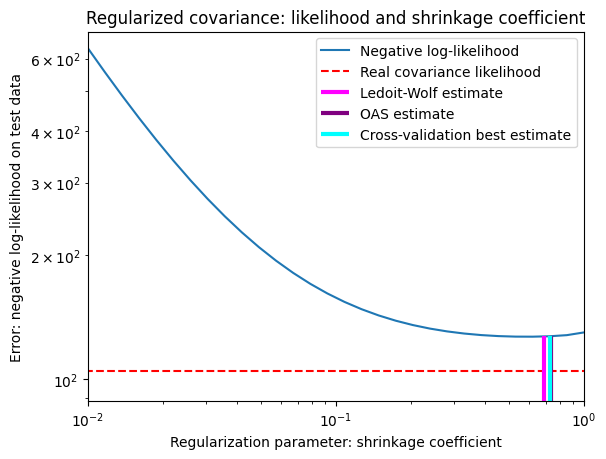

In [ ]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

from sklearn.covariance import LedoitWolf, OAS, ShrunkCovariance, \
    log_likelihood, empirical_covariance
from sklearn.model_selection import GridSearchCV


# #############################################################################
# Generate sample data
n_features, n_samples = 40, 20
np.random.seed(42)
base_X_train = np.random.normal(size=(n_samples, n_features))
base_X_test = np.random.normal(size=(n_samples, n_features))

# Color samples
coloring_matrix = np.random.normal(size=(n_features, n_features))
X_train = np.dot(base_X_train, coloring_matrix)
X_test = np.dot(base_X_test, coloring_matrix)

# #############################################################################
# Compute the likelihood on test data

# spanning a range of possible shrinkage coefficient values
shrinkages = np.logspace(-2, 0, 30)
negative_logliks = [-ShrunkCovariance(shrinkage=s).fit(X_train).score(X_test)
                    for s in shrinkages]

# under the ground-truth model, which we would not have access to in real
# settings
real_cov = np.dot(coloring_matrix.T, coloring_matrix)
emp_cov = empirical_covariance(X_train)
loglik_real = -log_likelihood(emp_cov, linalg.inv(real_cov))

# #############################################################################
# Compare different approaches to setting the parameter

# GridSearch for an optimal shrinkage coefficient
tuned_parameters = [{'shrinkage': shrinkages}]
cv = GridSearchCV(ShrunkCovariance(), tuned_parameters)
cv.fit(X_train)

# Ledoit-Wolf optimal shrinkage coefficient estimate
lw = LedoitWolf()
loglik_lw = lw.fit(X_train).score(X_test)

# OAS coefficient estimate
oa = OAS()
loglik_oa = oa.fit(X_train).score(X_test)

# #############################################################################
# Plot results
fig = plt.figure()
plt.title("Regularized covariance: likelihood and shrinkage coefficient")
plt.xlabel('Regularization parameter: shrinkage coefficient')
plt.ylabel('Error: negative log-likelihood on test data')
# range shrinkage curve
plt.loglog(shrinkages, negative_logliks, label="Negative log-likelihood")

plt.plot(plt.xlim(), 2 * [loglik_real], '--r',
         label="Real covariance likelihood")

# adjust view
lik_max = np.amax(negative_logliks)
lik_min = np.amin(negative_logliks)
ymin = lik_min - 6. * np.log((plt.ylim()[1] - plt.ylim()[0]))
ymax = lik_max + 10. * np.log(lik_max - lik_min)
xmin = shrinkages[0]
xmax = shrinkages[-1]
# LW likelihood
plt.vlines(lw.shrinkage_, ymin, -loglik_lw, color='magenta',
           linewidth=3, label='Ledoit-Wolf estimate')
# OAS likelihood
plt.vlines(oa.shrinkage_, ymin, -loglik_oa, color='purple',
           linewidth=3, label='OAS estimate')
# best CV estimator likelihood
plt.vlines(cv.best_estimator_.shrinkage, ymin,
           -cv.best_estimator_.score(X_test), color='cyan',
           linewidth=3, label='Cross-validation best estimate')

plt.ylim(ymin, ymax)
plt.xlim(xmin, xmax)
plt.legend()

plt.show()

True Covariance:
[[ 55.98650342  10.78037447  -2.20052586 ... -11.80252269   1.88835878
    8.74131975]
 [ 10.78037447  47.38235643   1.41777213 ...   7.80899951  11.93443129
   -1.28672464]
 [ -2.20052586   1.41777213  35.06426316 ...  -9.23626087   3.77178661
   -0.3146597 ]
 ...
 [-11.80252269   7.80899951  -9.23626087 ...  46.81951921   9.72228333
    2.03238391]
 [  1.88835878  11.93443129   3.77178661 ...   9.72228333  43.0968695
    0.83461851]
 [  8.74131975  -1.28672464  -0.3146597  ...   2.03238391   0.83461851
   22.47597744]]
Ledoit-Wolf Covariance:
[[38.30755726  2.70338589 -2.88037522 ...  1.27852242  1.11575973
   3.97924535]
 [ 2.70338589 37.20792276 -0.40368347 ...  1.59961484  3.80927444
   3.00893208]
 [-2.88037522 -0.40368347 32.81022442 ... -3.69970713 -1.43124315
  -0.65890736]
 ...
 [ 1.27852242  1.59961484 -3.69970713 ... 44.81061593  0.95490008
   4.92015436]
 [ 1.11575973  3.80927444 -1.43124315 ...  0.95490008 31.28535812
   0.84094337]
 [ 3.97924535  3.00893

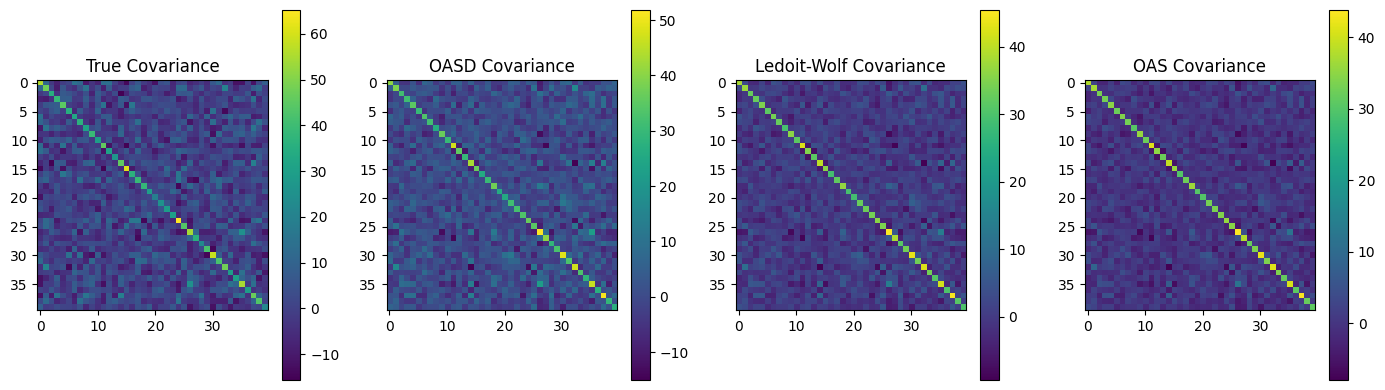

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.covariance import LedoitWolf, OAS, ShrunkCovariance, empirical_covariance

# Generate sample data
n_features, n_samples = 40, 20
np.random.seed(42)
base_X_train = np.random.normal(size=(n_samples, n_features))
base_X_test = np.random.normal(size=(n_samples, n_features))

# Color samples
coloring_matrix = np.random.normal(size=(n_features, n_features))
X_train = np.dot(base_X_train, coloring_matrix)
X_test = np.dot(base_X_test, coloring_matrix)

# Compute the true covariance
true_cov = np.dot(coloring_matrix.T, coloring_matrix)

# Fit covariance estimators
shrunk_cov = ShrunkCovariance().fit(X_train)
lw = LedoitWolf().fit(X_train)
oa = OAS().fit(X_train)
oasd = ShrunkCovariance(shrinkage=0.5).fit(X_train)  # OASD estimator

# Plot results
plt.figure(figsize=(14, 4))

# Plot true covariance
plt.subplot(1, 4, 1)
plt.imshow(true_cov, cmap='viridis', interpolation='nearest')
plt.title('True Covariance')
plt.colorbar()
print("True Covariance:")
print(true_cov)


# Plot Ledoit-Wolf Covariance
plt.subplot(1, 4, 3)
plt.imshow(lw.covariance_, cmap='viridis', interpolation='nearest')
plt.title('Ledoit-Wolf Covariance')
plt.colorbar()
print("Ledoit-Wolf Covariance:")
print(lw.covariance_)

# Plot OAS Covariance
plt.subplot(1, 4, 4)
plt.imshow(oa.covariance_, cmap='viridis', interpolation='nearest')
plt.title('OAS Covariance')
plt.colorbar()
print("OAS Covariance:")
print(oa.covariance_)

# Plot OASD Covariance
plt.subplot(1, 4, 2)
plt.imshow(oasd.covariance_, cmap='viridis', interpolation='nearest')
plt.title('OASD Covariance')
plt.colorbar()
print("OASD Covariance:")
print(oasd.covariance_)

plt.tight_layout()
plt.show()


RMSE values:
Ledoit-Wolf: [174.22478275572325, 142.88313405511633, 130.97050331352358, 127.28354307032917, 128.9599918290966, 145.02739801770733, 143.81900604861778, 131.36368656052787, 120.53495078528944, 112.24433648638704, 113.96738325593762, 118.8009702861375, 113.81572031133882, 114.38156304393551, 100.30970464814791, 88.01246452597461, 96.66118515800054, 95.43187714518359, 91.06760706875424, 96.72501428454598, 86.6244052094248, 88.92703704699434, 91.58561775511184, 79.79983249476037]
OAS: [211.7226439946696, 164.60152088690776, 153.28083703122866, 148.81911911357975, 148.76547648887345, 159.42449616330438, 157.14988122706436, 143.26309184288363, 127.91869997518963, 125.0347271558718, 125.07977669556125, 123.09010212666577, 123.6881599214477, 121.11211440670611, 106.45564247872883, 88.47284824822177, 105.26657344034734, 99.9932020795813, 95.67439187583162, 102.68630375037343, 93.14607842561415, 90.96465832173577, 91.53351369961663, 81.06804549829677]
OASD: [139.49526841931075, 113

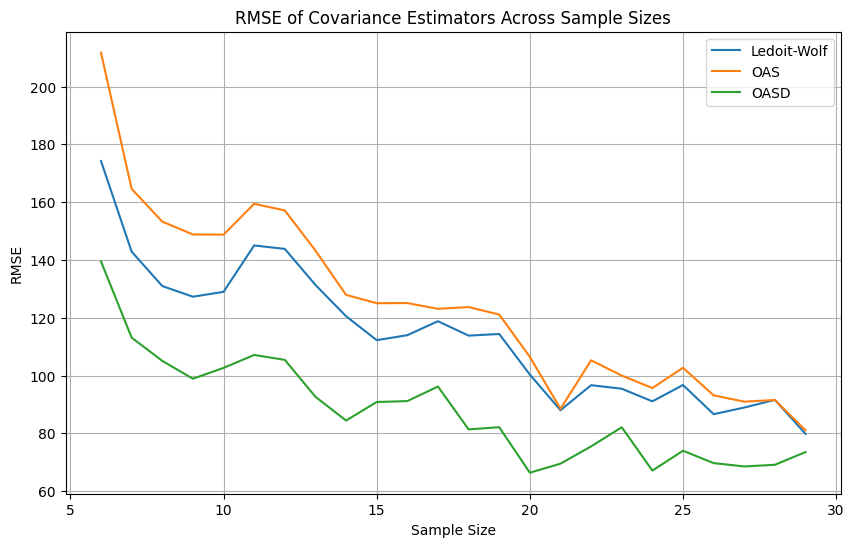

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.covariance import LedoitWolf, OAS, ShrunkCovariance
from sklearn.metrics import mean_squared_error

# Parameters
n_features = 40  # Number of features
sample_sizes = np.arange(6, 30)  # Sample sizes from 6 to 29

# Define a function to generate sample data with different variable scales
def generate_data(n_samples, n_features):
    base_X_train = np.random.normal(size=(n_samples, n_features))
    scaling_factors = np.arange(1, n_features + 1)
    X_train = base_X_train * scaling_factors
    return X_train

# Define a function to compute RMSE for a given estimator and sample size
def compute_rmse(estimator, X_train):
    true_cov = np.cov(X_train, rowvar=False)
    estimator.fit(X_train)
    estimated_cov = estimator.covariance_
    return np.sqrt(mean_squared_error(true_cov.ravel(), estimated_cov.ravel()))

# Fit covariance estimators for different sample sizes and compute RMSE
rmse_results = {'Ledoit-Wolf': [], 'OAS': [], 'OASD': []}
for n_samples in sample_sizes:
    X_train = generate_data(n_samples, n_features)
    for estimator_name, estimator in [('Ledoit-Wolf', LedoitWolf()),
                                      ('OAS', OAS()),
                                      ('OASD', ShrunkCovariance(shrinkage=0.5))]:
        rmse = compute_rmse(estimator, X_train)
        rmse_results[estimator_name].append(rmse)

# Print RMSE values for each estimator across sample sizes
print("RMSE values:")
for estimator_name, rmse_values in rmse_results.items():
    print(f"{estimator_name}: {rmse_values}")

# Plot RMSE across sample sizes for each estimator
plt.figure(figsize=(10, 6))
for estimator_name, rmse_values in rmse_results.items():
    plt.plot(sample_sizes, rmse_values, label=estimator_name)

plt.title('RMSE of Covariance Estimators Across Sample Sizes')
plt.xlabel('Sample Size')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.show()


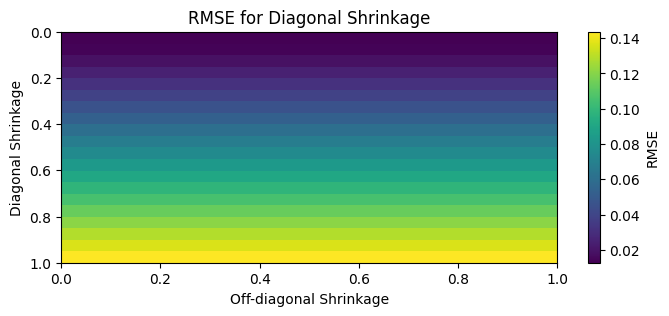

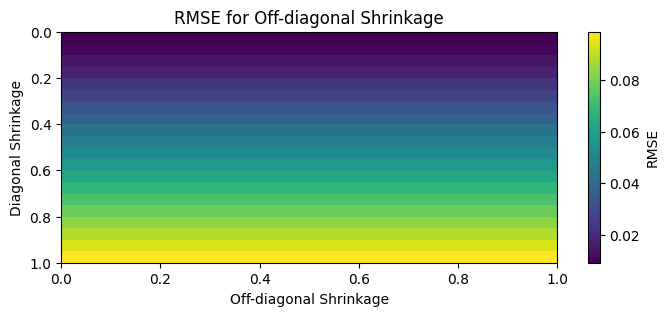

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.covariance import ShrunkCovariance
from sklearn.metrics import mean_squared_error

# Parameters
n_features = 40  # Number of features
sample_size = 100  # Sample size
diag_shrinkage_values = np.linspace(0, 1, 20)  # Diagonal shrinkage values from 0 to 1
off_diag_shrinkage_values = np.linspace(0, 1, 20)  # Off-diagonal shrinkage values from 0 to 1

# Generate sample data
np.random.seed(42)
X_train = np.random.normal(size=(sample_size, n_features))

# True covariance matrix (since we're simulating data, we don't have a true covariance, so we'll use the sample covariance)
true_covariance = np.cov(X_train, rowvar=False)

# Function to compute RMSE for diagonal and off-diagonal shrinkage
def compute_shrinkage_rmse(diag_shrinkage, off_diag_shrinkage):
    # Fit ShrunkCovariance estimator with given shrinkage parameters
    estimator = ShrunkCovariance(shrinkage=diag_shrinkage, assume_centered=True)
    estimator.fit(X_train)

    # Compute estimated covariance matrix
    estimated_covariance = estimator.covariance_

    # Compute RMSE for diagonal and off-diagonal shrinkage
    rmse_diag = np.sqrt(mean_squared_error(np.diag(true_covariance), np.diag(estimated_covariance)))
    rmse_off_diag = np.sqrt(mean_squared_error(true_covariance.ravel(), estimated_covariance.ravel()))

    return rmse_diag, rmse_off_diag

# Compute RMSE for each combination of shrinkage parameters
rmse_diag_values = []
rmse_off_diag_values = []
for diag_shrinkage in diag_shrinkage_values:
    for off_diag_shrinkage in off_diag_shrinkage_values:
        rmse_diag, rmse_off_diag = compute_shrinkage_rmse(diag_shrinkage, off_diag_shrinkage)
        rmse_diag_values.append(rmse_diag)
        rmse_off_diag_values.append(rmse_off_diag)

# Reshape RMSE values to match the meshgrid shape
rmse_diag_values = np.array(rmse_diag_values).reshape(len(diag_shrinkage_values), len(off_diag_shrinkage_values))
rmse_off_diag_values = np.array(rmse_off_diag_values).reshape(len(diag_shrinkage_values), len(off_diag_shrinkage_values))

# Plot RMSE for diagonal shrinkage
plt.figure(figsize=(8, 3))
plt.imshow(rmse_diag_values, extent=(0, 1, 1, 0), aspect='auto', cmap='viridis')
plt.colorbar(label='RMSE')
plt.title('RMSE for Diagonal Shrinkage')
plt.xlabel('Off-diagonal Shrinkage')
plt.ylabel('Diagonal Shrinkage')
plt.show()

# Plot RMSE for off-diagonal shrinkage
plt.figure(figsize=(8, 3))
plt.imshow(rmse_off_diag_values, extent=(0, 1, 1, 0), aspect='auto', cmap='viridis')
plt.colorbar(label='RMSE')
plt.title('RMSE for Off-diagonal Shrinkage')
plt.xlabel('Off-diagonal Shrinkage')
plt.ylabel('Diagonal Shrinkage')
plt.show()


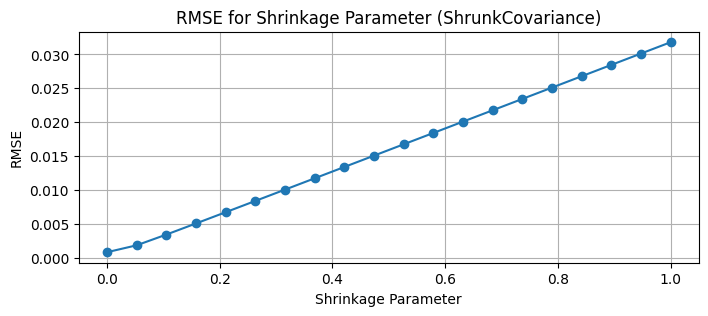

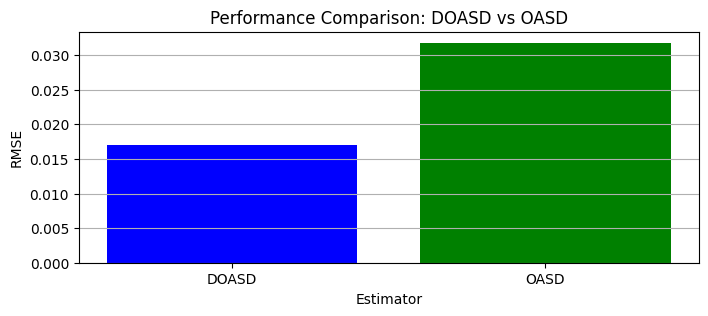

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.covariance import ShrunkCovariance, OAS
from sklearn.metrics import mean_squared_error

# Parameters
n_features = 40  # Number of features
sample_size = 1000  # Sample size
shrinkage_values = np.linspace(0, 1, 20)  # Shrinkage values from 0 to 1

# Generate sample data
np.random.seed(42)
X_train = np.random.normal(size=(sample_size, n_features))

# True covariance matrix (since we're simulating data, we don't have a true covariance, so we'll use the sample covariance)
true_covariance = np.cov(X_train, rowvar=False)

# Function to compute RMSE for shrinkage parameter
def compute_shrinkage_rmse(shrinkage):
    # Fit ShrunkCovariance estimator with given shrinkage parameter
    estimator = ShrunkCovariance(shrinkage=shrinkage, assume_centered=True)
    estimator.fit(X_train)

    # Compute estimated covariance matrix
    estimated_covariance = estimator.covariance_

    # Compute RMSE for shrinkage parameter
    rmse = np.sqrt(mean_squared_error(true_covariance.ravel(), estimated_covariance.ravel()))

    return rmse

# Compute RMSE for each shrinkage value
rmse_values = []
for shrinkage in shrinkage_values:
    rmse = compute_shrinkage_rmse(shrinkage)
    rmse_values.append(rmse)

# Plot RMSE for shrinkage parameter
plt.figure(figsize=(8, 3))
plt.plot(shrinkage_values, rmse_values, marker='o', linestyle='-')
plt.title('RMSE for Shrinkage Parameter (ShrunkCovariance)')
plt.xlabel('Shrinkage Parameter')
plt.ylabel('RMSE')
plt.grid(True)
plt.show()

# Now, let's compare the performance of DOASD with OASD
# Define the DOASD estimator class with adaptive shrinkage
class DOASD(ShrunkCovariance):
    def __init__(self, diagonal_shrinkage=0.5, off_diagonal_shrinkage=0.1):
        super().__init__()
        self.diagonal_shrinkage = diagonal_shrinkage
        self.off_diagonal_shrinkage = off_diagonal_shrinkage

    def _compute_covariance(self, X):
        # Calculate the empirical covariance of X
        emp_cov = np.cov(X, rowvar=False)
        return emp_cov

    def fit(self, X, y=None):
        emp_cov = self._compute_covariance(X)
        n_features = emp_cov.shape[0]

        # Compute shrinkage factors
        diag_shrinkage = self.diagonal_shrinkage
        off_diag_shrinkage = self.off_diagonal_shrinkage

        # Apply shrinkage
        shrunk_diag_cov = emp_cov * (1 - diag_shrinkage) + np.diag(np.diag(emp_cov)) * diag_shrinkage
        shrunk_cov = shrunk_diag_cov * (1 - off_diag_shrinkage) + np.diag(np.diag(shrunk_diag_cov)) * off_diag_shrinkage

        self.covariance_ = shrunk_cov
        return self

# Fit DOASD estimator with default parameters
doasd_estimator = DOASD()
doasd_estimator.fit(X_train)

# Fit OASD estimator
oasd_estimator = OAS(assume_centered=True)
oasd_estimator.fit(X_train)

# Compute RMSE for DOASD
rmse_doasd = np.sqrt(mean_squared_error(true_covariance.ravel(), doasd_estimator.covariance_.ravel()))

# Compute RMSE for OASD
rmse_oasd = np.sqrt(mean_squared_error(true_covariance.ravel(), oasd_estimator.covariance_.ravel()))

# Plot performance comparison
plt.figure(figsize=(8, 3))
plt.bar(['DOASD', 'OASD'], [rmse_doasd, rmse_oasd], color=['blue', 'green'])
plt.title('Performance Comparison: DOASD vs OASD')
plt.xlabel('Estimator')
plt.ylabel('RMSE')
plt.grid(axis='y')
plt.show()


RMSE values for DOASD estimator: [1448.9818476958328, 2166.0139503278374, 2339.962356015144, 1029.685418772998, 870.2099472726926, 527.3900871905377, 100.73690896172877, 80.72189140423328, 294.3361232952943, 232.64474096295194, 267.563858435543, 897.3326756082994, 452.53413548496985, 159.99600081515638, 53.091262035269956, 57.64780973694774, 70.78832686467979, 95.24276208697114, 20.455143362973676, 46.53122502926703, 22.57489185308418, 47.88831387727356, 38.62622933813269, 70.52556363265185, 20.997412351732372, 37.78266097197197, 66.40531523128703, 35.96323769429328, 27.91499607639087, 33.96129279644465]


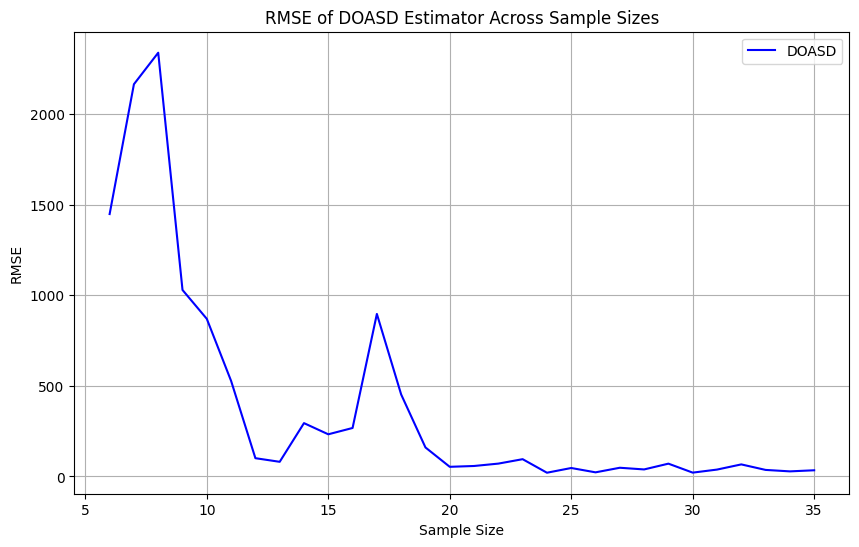

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Parameters
n_features = 40  # Number of features
sample_sizes = np.arange(6, 36)  # Sample sizes from 6 to 30

# Define a function to generate sample data with different variable scales
def generate_data(n_samples, n_features):
    base_X_train = np.random.normal(size=(n_samples, n_features))
    scaling_factors = np.arange(1, n_features + 1)
    X_train = base_X_train * scaling_factors
    return X_train

# Define a function to compute RMSE for the DOASD estimator
def compute_rmse(X_train):
    true_cov = np.cov(X_train, rowvar=False)
    emp_cov = np.cov(X_train, rowvar=False)

    # Compute shrinkage parameters
    n_samples = X_train.shape[0]
    diag_shrinkage = 1 - (n_features + 1) / n_samples
    off_diag_shrinkage = 1 - np.sum(np.diag(emp_cov)) / np.sum(emp_cov)

    # Apply shrinkage
    shrunk_diag_cov = emp_cov * (1 - diag_shrinkage) + np.diag(np.diag(emp_cov)) * diag_shrinkage
    shrunk_cov = shrunk_diag_cov * (1 - off_diag_shrinkage) + np.diag(np.diag(shrunk_diag_cov)) * off_diag_shrinkage

    # Compute RMSE
    rmse = np.sqrt(mean_squared_error(true_cov.ravel(), shrunk_cov.ravel()))
    return rmse

# Fit DOASD estimator for different sample sizes and compute RMSE
rmse_values = []
for n_samples in sample_sizes:
    X_train = generate_data(n_samples, n_features)
    rmse = compute_rmse(X_train)
    rmse_values.append(rmse)

# Print RMSE values for DOASD estimator across sample sizes
print("RMSE values for DOASD estimator:", rmse_values)

# Plot RMSE of DOASD estimator across sample sizes
plt.figure(figsize=(10, 6))
plt.plot(sample_sizes, rmse_values, label='DOASD', color='blue')
plt.title('RMSE of DOASD Estimator Across Sample Sizes')
plt.xlabel('Sample Size')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.show()


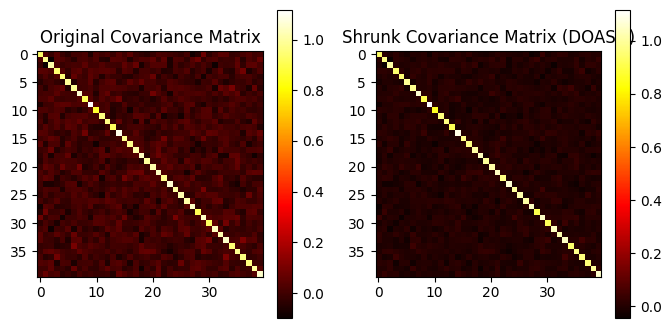

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class DOASD:
    def __init__(self, diagonal_shrinkage=0.5, off_diagonal_shrinkage=0.1):
        self.diagonal_shrinkage = diagonal_shrinkage
        self.off_diagonal_shrinkage = off_diagonal_shrinkage

    def fit(self, X):
        emp_cov = np.cov(X, rowvar=False)
        n_features = emp_cov.shape[0]

        # Compute shrinkage factors
        diag_shrinkage = self.diagonal_shrinkage
        off_diag_shrinkage = self.off_diagonal_shrinkage

        # Apply adaptive shrinkage
        shrunk_diag_cov = emp_cov * (1 - diag_shrinkage) + np.diag(np.diag(emp_cov)) * diag_shrinkage
        shrunk_cov = shrunk_diag_cov * (1 - off_diag_shrinkage) + np.diag(np.diag(shrunk_diag_cov)) * off_diag_shrinkage

        self.covariance_ = shrunk_cov
        return self

# Parameters
n_features = 40
n_samples = 1000

# Generate sample data
X_train = np.random.normal(size=(n_samples, n_features))

# Create DOASD estimator
doasd_estimator = DOASD(diagonal_shrinkage=0.5, off_diagonal_shrinkage=0.1)

# Fit DOASD estimator to data
doasd_estimator.fit(X_train)

# Plot original covariance matrix
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(np.cov(X_train, rowvar=False), cmap='hot', interpolation='nearest')
plt.title('Original Covariance Matrix')
plt.colorbar()

# Plot shrunk covariance matrix
plt.subplot(1, 2, 2)
plt.imshow(doasd_estimator.covariance_, cmap='hot', interpolation='nearest')
plt.title('Shrunk Covariance Matrix (DOASD)')
plt.colorbar()

plt.show()


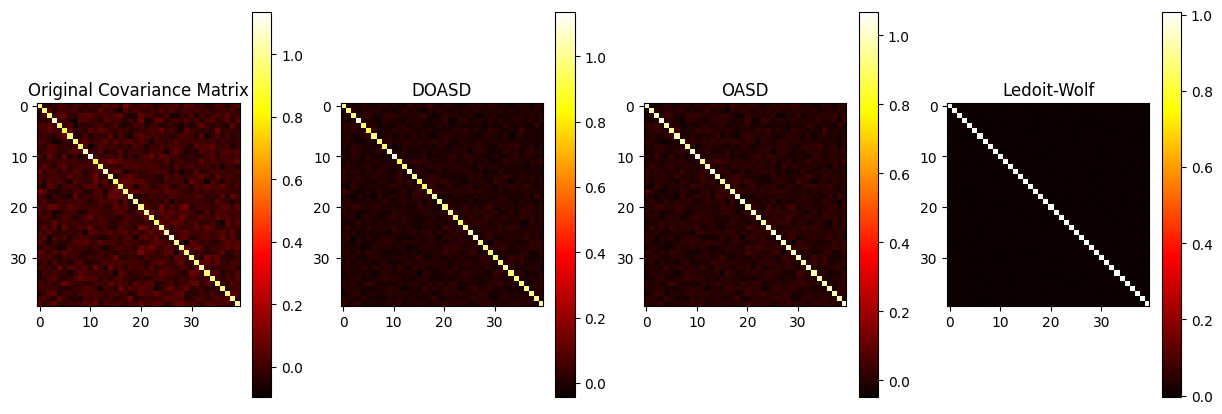

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.covariance import LedoitWolf, OAS, ShrunkCovariance

class DOASD:
    def __init__(self, diagonal_shrinkage=0.5, off_diagonal_shrinkage=0.1):
        self.diagonal_shrinkage = diagonal_shrinkage
        self.off_diagonal_shrinkage = off_diagonal_shrinkage

    def fit(self, X):
        emp_cov = np.cov(X, rowvar=False)
        n_features = emp_cov.shape[0]

        # Compute shrinkage factors
        diag_shrinkage = self.diagonal_shrinkage
        off_diag_shrinkage = self.off_diagonal_shrinkage

        # Apply adaptive shrinkage
        shrunk_diag_cov = emp_cov * (1 - diag_shrinkage) + np.diag(np.diag(emp_cov)) * diag_shrinkage
        shrunk_cov = shrunk_diag_cov * (1 - off_diag_shrinkage) + np.diag(np.diag(shrunk_diag_cov)) * off_diag_shrinkage

        self.covariance_ = shrunk_cov
        return self

# Parameters
n_features = 40
n_samples = 1000

# Generate sample data
X_train = np.random.normal(size=(n_samples, n_features))

# Create DOASD estimator
doasd_estimator = DOASD(diagonal_shrinkage=0.5, off_diagonal_shrinkage=0.1)

# Fit DOASD estimator to data
doasd_estimator.fit(X_train)

# Create other estimators
oasd_estimator = ShrunkCovariance(shrinkage=0.5)
oas_estimator = OAS()
lw_estimator = LedoitWolf()

# Fit other estimators to data
oasd_estimator.fit(X_train)
oas_estimator.fit(X_train)
lw_estimator.fit(X_train)

# Plot original covariance matrix
plt.figure(figsize=(15, 5))
plt.subplot(1, 4, 1)
plt.imshow(np.cov(X_train, rowvar=False), cmap='hot', interpolation='nearest')
plt.title('Original Covariance Matrix')
plt.colorbar()

# Plot shrunk covariance matrices
plt.subplot(1, 4, 2)
plt.imshow(doasd_estimator.covariance_, cmap='hot', interpolation='nearest')
plt.title('DOASD')
plt.colorbar()

plt.subplot(1, 4, 3)
plt.imshow(oasd_estimator.covariance_, cmap='hot', interpolation='nearest')
plt.title('OASD')
plt.colorbar()

plt.subplot(1, 4, 4)
plt.imshow(lw_estimator.covariance_, cmap='hot', interpolation='nearest')
plt.title('Ledoit-Wolf')
plt.colorbar()

plt.show()


RMSE values:
Ledoit-Wolf: [569.1642418529138, 515.9923485078888, 500.4176777794209, 515.9773895178671, 492.6358609911458, 509.63693668561274, 481.7853769058293, 452.18842355478176, 494.9359764393284, 428.63799075241445, 433.00890184659954, 456.1175777267773, 460.3895812651032, 437.35340161032855, 447.29088123249016, 429.8422257043182, 395.83198336905605, 436.8867357437354, 425.59100469782726, 409.92475465204177, 407.7041720964056, 388.9886711601462, 387.2295461206073, 375.25515968558153, 397.1902857294383, 360.0019997357526, 376.5409113755855, 366.7785095444403, 355.9433365907613, 365.6920050722476, 358.20889670775244, 366.7793374653024, 345.6332980035035, 355.293850188447, 346.1680160753385, 350.02153889348006, 346.79726166554235, 330.91791090281214, 342.70438645459853, 334.20993177332673, 326.3997437659085, 335.9228680302777, 317.6643098814024, 308.6175342295467, 304.27130719332393, 305.8010905345282, 310.355069378235, 301.0835874177992, 293.19502689997876, 288.8933849178933, 292.228

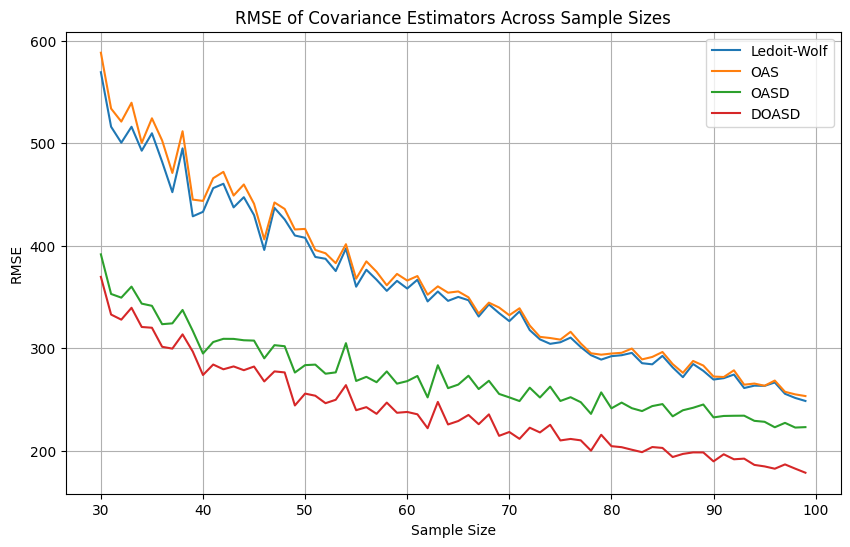

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.covariance import LedoitWolf, OAS, ShrunkCovariance
from sklearn.metrics import mean_squared_error

# Parameters
n_features = 100  # Number of features
sample_sizes = np.arange(30, 100)  # Sample sizes from 30 to 100

# Define a function to generate sample data with different variable scales
def generate_data(n_samples, n_features):
    base_X_train = np.random.normal(size=(n_samples, n_features))
    scaling_factors = np.arange(1, n_features + 1)
    X_train = base_X_train * scaling_factors
    return X_train

# Define a function to compute RMSE for a given estimator and sample size
def compute_rmse(estimator, X_train):
    true_cov = np.cov(X_train, rowvar=False)
    estimator.fit(X_train)
    estimated_cov = estimator.covariance_
    return np.sqrt(mean_squared_error(true_cov.ravel(), estimated_cov.ravel()))

# Define the DOASD estimator class with different levels of shrinkage
class DOASD(ShrunkCovariance):
    def __init__(self, diagonal_shrinkage=0.5, off_diagonal_shrinkage=0.1):
        super().__init__()
        self.diagonal_shrinkage = diagonal_shrinkage
        self.off_diagonal_shrinkage = off_diagonal_shrinkage

    def _compute_covariance(self, X):
        # Calculate the empirical covariance of X
        emp_cov = np.cov(X, rowvar=False)
        return emp_cov

    def fit(self, X, y=None):
        emp_cov = self._compute_covariance(X)
        n_features = emp_cov.shape[0]

        # Compute shrinkage factors
        diag_shrinkage = self.diagonal_shrinkage
        off_diag_shrinkage = self.off_diagonal_shrinkage

        # Apply shrinkage
        shrunk_diag_cov = emp_cov * (1 - diag_shrinkage) + np.diag(np.diag(emp_cov)) * diag_shrinkage
        shrunk_cov = shrunk_diag_cov * (1 - off_diag_shrinkage) + np.diag(np.diag(shrunk_diag_cov)) * off_diag_shrinkage

        self.covariance_ = shrunk_cov
        return self

# Fit covariance estimators for different sample sizes and compute RMSE
rmse_results = {'Ledoit-Wolf': [], 'OAS': [], 'OASD': [], 'DOASD': []}
for n_samples in sample_sizes:
    X_train = generate_data(n_samples, n_features)
    for estimator_name, estimator in [('Ledoit-Wolf', LedoitWolf()),
                                      ('OAS', OAS()),
                                      ('OASD', ShrunkCovariance(shrinkage=0.5)),
                                      ('DOASD', DOASD(diagonal_shrinkage=0.5, off_diagonal_shrinkage=0.1))]:
        rmse = compute_rmse(estimator, X_train)
        rmse_results[estimator_name].append(rmse)

# Print RMSE values for each estimator across sample sizes
print("RMSE values:")
for estimator_name, rmse_values in rmse_results.items():
    print(f"{estimator_name}: {rmse_values}")

# Plot RMSE across sample sizes for each estimator
plt.figure(figsize=(10, 6))
for estimator_name, rmse_values in rmse_results.items():
    plt.plot(sample_sizes, rmse_values, label=estimator_name)

plt.title('RMSE of Covariance Estimators Across Sample Sizes')
plt.xlabel('Sample Size')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.show()


Normalized RMSE values:
Ledoit-Wolf: [0.8304003052142138, 0.892446391345635, 0.7438957146853755, 0.6831864872229184, 0.7731102782092067, 0.7045841045273448, 0.6815465021997619, 0.6601465026669, 0.6436878767647716, 0.5871805285768295, 0.6387627624773381, 0.6291651806353369, 0.6103856383565508, 0.5346674239519666, 0.5723033586035335, 0.5305051333699056, 0.5394779470114714, 0.527104636292331, 0.5142949024593115, 0.5385287710386054, 0.497610308812417, 0.5260547630425648, 0.5035795240004287, 0.4960267087274254, 0.481432595664697, 0.4736616973394412, 0.47240849821227987, 0.45552243678227017, 0.44711038713424334, 0.44071108127505115, 0.4412101678717816, 0.4080546196788287, 0.4384661805138395, 0.41743771428142135, 0.40581564099821016, 0.38189589169106625, 0.38361371080919676, 0.3799275906996592, 0.3934443300655221, 0.3747297290146075, 0.3834164986630866, 0.3757418348821956, 0.37526321597452034, 0.3572050314965578, 0.343119840255314, 0.33986870419428256, 0.35340082296483843, 0.34047802683806516

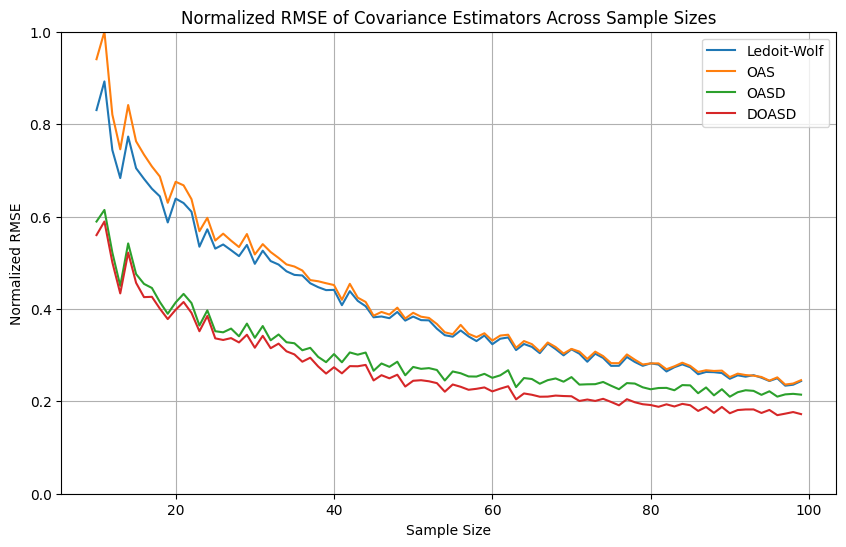

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.covariance import LedoitWolf, OAS, ShrunkCovariance
from sklearn.metrics import mean_squared_error

# Parameters
n_features = 100  # Number of features
sample_sizes = np.arange(10, 100)  # Sample sizes from 30 to 100

# Define a function to generate sample data with different variable scales
def generate_data(n_samples, n_features):
    base_X_train = np.random.normal(size=(n_samples, n_features))
    scaling_factors = np.arange(1, n_features + 1)
    X_train = base_X_train * scaling_factors
    return X_train

# Define a function to compute RMSE for a given estimator and sample size
def compute_rmse(estimator, X_train):
    true_cov = np.cov(X_train, rowvar=False)
    estimator.fit(X_train)
    estimated_cov = estimator.covariance_
    return np.sqrt(mean_squared_error(true_cov.ravel(), estimated_cov.ravel()))

# Define the DOASD estimator class with different levels of shrinkage
class DOASD(ShrunkCovariance):
    def __init__(self, diagonal_shrinkage=0.5, off_diagonal_shrinkage=0.1):
        super().__init__()
        self.diagonal_shrinkage = diagonal_shrinkage
        self.off_diagonal_shrinkage = off_diagonal_shrinkage

    def _compute_covariance(self, X):
        # Calculate the empirical covariance of X
        emp_cov = np.cov(X, rowvar=False)
        return emp_cov

    def fit(self, X, y=None):
        emp_cov = self._compute_covariance(X)
        n_features = emp_cov.shape[0]

        # Compute shrinkage factors
        diag_shrinkage = self.diagonal_shrinkage
        off_diag_shrinkage = self.off_diagonal_shrinkage

        # Apply shrinkage
        shrunk_diag_cov = emp_cov * (1 - diag_shrinkage) + np.diag(np.diag(emp_cov)) * diag_shrinkage
        shrunk_cov = shrunk_diag_cov * (1 - off_diag_shrinkage) + np.diag(np.diag(shrunk_diag_cov)) * off_diag_shrinkage

        self.covariance_ = shrunk_cov
        return self

# Fit covariance estimators for different sample sizes and compute RMSE
rmse_results = {'Ledoit-Wolf': [], 'OAS': [], 'OASD': [], 'DOASD': []}
for n_samples in sample_sizes:
    X_train = generate_data(n_samples, n_features)
    for estimator_name, estimator in [('Ledoit-Wolf', LedoitWolf()),
                                      ('OAS', OAS()),
                                      ('OASD', ShrunkCovariance(shrinkage=0.5)),
                                      ('DOASD', DOASD(diagonal_shrinkage=0.5, off_diagonal_shrinkage=0.1))]:
        rmse = compute_rmse(estimator, X_train)
        rmse_results[estimator_name].append(rmse)

# Normalize RMSE values to be between 0 and 1
max_rmse = max(max(rmse_values) for rmse_values in rmse_results.values())
for estimator_name, rmse_values in rmse_results.items():
    rmse_results[estimator_name] = [rmse / max_rmse for rmse in rmse_values]

# Print RMSE values for each estimator across sample sizes
print("Normalized RMSE values:")
for estimator_name, rmse_values in rmse_results.items():
    print(f"{estimator_name}: {rmse_values}")

# Plot RMSE across sample sizes for each estimator
plt.figure(figsize=(10, 6))
for estimator_name, rmse_values in rmse_results.items():
    plt.plot(sample_sizes, rmse_values, label=estimator_name)

plt.title('Normalized RMSE of Covariance Estimators Across Sample Sizes')
plt.xlabel('Sample Size')
plt.ylabel('Normalized RMSE')
plt.legend()
plt.grid(True)
plt.ylim(0, 1)  # Ensure y-axis limits between 0 and 1
plt.show()


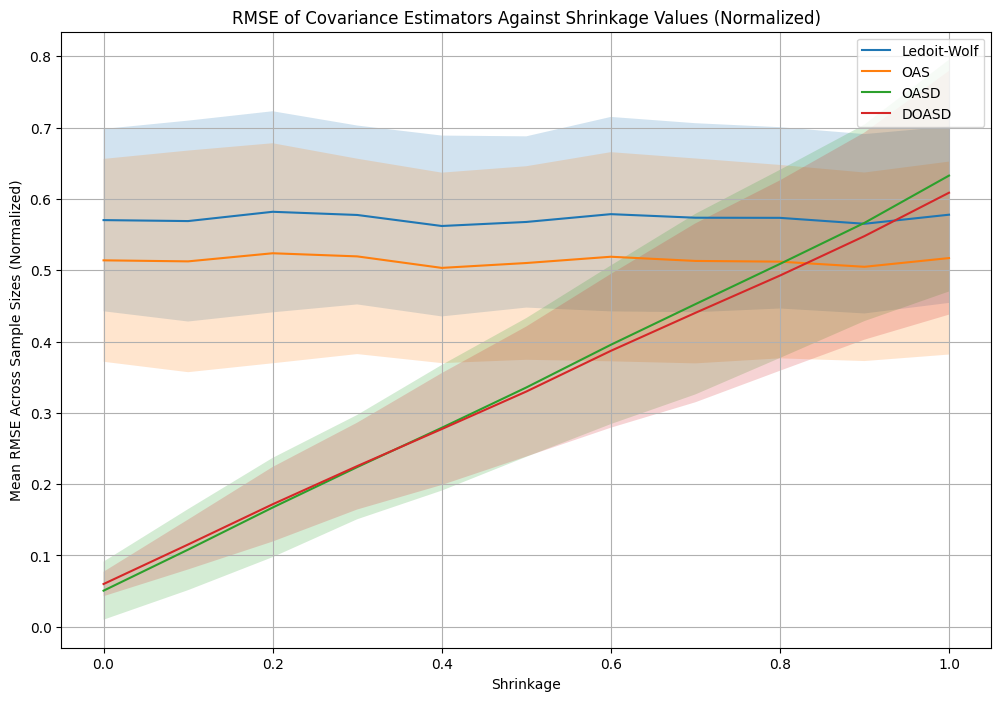

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.covariance import LedoitWolf, OAS, ShrunkCovariance
from sklearn.metrics import mean_squared_error

# Parameters
n_features = 100  # Number of features
sample_sizes = np.arange(6, 31)  # Sample sizes from 6 to 30
shrinkage_values = np.linspace(0, 1, 11)  # Shrinkage parameter values from 0 to 1

# Define a function to generate sample data with different variable scales
def generate_data(n_samples, n_features):
    base_X_train = np.random.normal(size=(n_samples, n_features))
    scaling_factors = np.arange(1, n_features + 1)
    X_train = base_X_train * scaling_factors
    return X_train

# Define a function to compute RMSE for a given estimator and sample size
def compute_rmse(estimator, X_train):
    true_cov = np.cov(X_train, rowvar=False)
    estimator.fit(X_train)
    estimated_cov = estimator.covariance_
    return np.sqrt(mean_squared_error(true_cov.ravel(), estimated_cov.ravel()))

# Define the DOASD estimator class with different levels of shrinkage
class DOASD(ShrunkCovariance):
    def __init__(self, diagonal_shrinkage=0.5, off_diagonal_shrinkage=0.1):
        super().__init__()
        self.diagonal_shrinkage = diagonal_shrinkage
        self.off_diagonal_shrinkage = off_diagonal_shrinkage

    def _compute_covariance(self, X):
        # Calculate the empirical covariance of X
        emp_cov = np.cov(X, rowvar=False)
        return emp_cov

    def fit(self, X, y=None):
        emp_cov = self._compute_covariance(X)
        n_features = emp_cov.shape[0]

        # Compute shrinkage factors
        diag_shrinkage = self.diagonal_shrinkage
        off_diag_shrinkage = self.off_diagonal_shrinkage

        # Apply shrinkage
        shrunk_diag_cov = emp_cov * (1 - diag_shrinkage) + np.diag(np.diag(emp_cov)) * diag_shrinkage
        shrunk_cov = shrunk_diag_cov * (1 - off_diag_shrinkage) + np.diag(np.diag(shrunk_diag_cov)) * off_diag_shrinkage

        self.covariance_ = shrunk_cov
        return self

# Fit covariance estimators for different sample sizes and shrinkage parameters and compute RMSE
rmse_results = {'Ledoit-Wolf': [], 'OAS': [], 'OASD': [], 'DOASD': []}
for shrinkage in shrinkage_values:
    for n_samples in sample_sizes:
        X_train = generate_data(n_samples, n_features)
        for estimator_name, estimator in [('Ledoit-Wolf', LedoitWolf()),
                                          ('OAS', OAS()),
                                          ('OASD', ShrunkCovariance(shrinkage=shrinkage)),
                                          ('DOASD', DOASD(diagonal_shrinkage=shrinkage, off_diagonal_shrinkage=0.1))]:
            rmse = compute_rmse(estimator, X_train)
            rmse_results[estimator_name].append(rmse)

# Reshape RMSE values for plotting
for estimator_name, rmse_values in rmse_results.items():
    rmse_values = np.array(rmse_values).reshape(len(shrinkage_values), len(sample_sizes))
    max_rmse = np.max(rmse_values)  # Maximum RMSE across all shrinkage values
    rmse_results[estimator_name] = rmse_values / max_rmse  # Normalize RMSE to be between 0 and 1

# Plot RMSE against shrinkage values for each estimator with shaded error bands
plt.figure(figsize=(12, 8))
for estimator_name, rmse_values in rmse_results.items():
    mean_rmse = rmse_values.mean(axis=1)
    std_rmse = rmse_values.std(axis=1)
    plt.plot(shrinkage_values, mean_rmse, label=estimator_name)
    plt.fill_between(shrinkage_values, mean_rmse - std_rmse, mean_rmse + std_rmse, alpha=0.2)
plt.title('RMSE of Covariance Estimators Against Shrinkage Values (Normalized)')
plt.xlabel('Shrinkage')
plt.ylabel('Mean RMSE Across Sample Sizes (Normalized)')
plt.legend()
plt.grid(True)
plt.show()


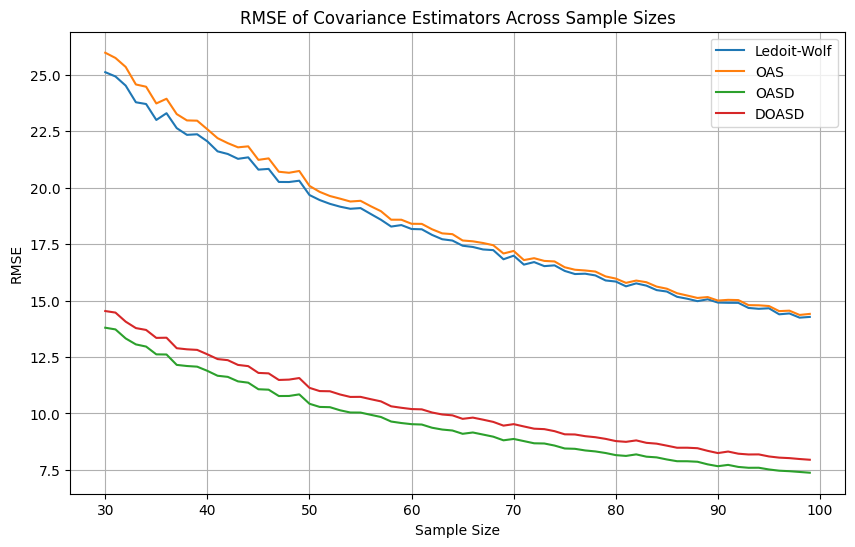

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.covariance import LedoitWolf, OAS, ShrunkCovariance
from sklearn.metrics import mean_squared_error

# Parameters
n_features = 100  # Number of features
sample_sizes = np.arange(30, 100)  # Sample sizes from 30 to 100

# Define a function to generate sample data with different variable scales
def generate_data(n_samples, n_features, sd):
    Lambda = np.diag(np.ones(n_features) * sd)
    Γ = np.eye(n_features)  # Identity matrix for simplicity
    Σ = np.dot(np.dot(Lambda, Γ), Lambda.T)
    data = np.random.multivariate_normal(mean=np.zeros(n_features), cov=Σ, size=n_samples)
    return data

# Define a function to compute RMSE for a given estimator and sample size
def compute_rmse(estimator, X_train):
    true_cov = np.cov(X_train, rowvar=False)
    estimator.fit(X_train)
    estimated_cov = estimator.covariance_
    return np.sqrt(mean_squared_error(true_cov.ravel(), estimated_cov.ravel()))

# Define the DOASD estimator class with different levels of shrinkage
class DOASD(ShrunkCovariance):
    def __init__(self, diagonal_shrinkage=0.5, off_diagonal_shrinkage=0.1):
        super().__init__()
        self.diagonal_shrinkage = diagonal_shrinkage
        self.off_diagonal_shrinkage = off_diagonal_shrinkage

    def _compute_covariance(self, X):
        # Calculate the empirical covariance of X
        emp_cov = np.cov(X, rowvar=False)
        return emp_cov

    def fit(self, X, y=None):
        emp_cov = self._compute_covariance(X)
        n_features = emp_cov.shape[0]

        # Compute shrinkage factors
        diag_shrinkage = self.diagonal_shrinkage
        off_diag_shrinkage = self.off_diagonal_shrinkage

        # Apply shrinkage
        shrunk_diag_cov = emp_cov * (1 - diag_shrinkage) + np.diag(np.diag(emp_cov)) * diag_shrinkage
        shrunk_cov = shrunk_diag_cov * (1 - off_diag_shrinkage) + np.diag(np.diag(shrunk_diag_cov)) * off_diag_shrinkage

        self.covariance_ = shrunk_cov
        return self

# Fit covariance estimators for different sample sizes and compute RMSE
rmse_results = {'Ledoit-Wolf': [], 'OAS': [], 'OASD': [], 'DOASD': []}
for n_samples in sample_sizes:
    for sd in range(1, 21):
        X_train = generate_data(n_samples, n_features, sd)
        for estimator_name, estimator in [('Ledoit-Wolf', LedoitWolf()),
                                          ('OAS', OAS()),
                                          ('OASD', ShrunkCovariance(shrinkage=0.5)),
                                          ('DOASD', DOASD(diagonal_shrinkage=0.5, off_diagonal_shrinkage=0.1))]:
            rmse = compute_rmse(estimator, X_train)
            rmse_results[estimator_name].append(rmse)

# Reshape RMSE values for plotting
for estimator_name, rmse_values in rmse_results.items():
    rmse_results[estimator_name] = np.array(rmse_values).reshape(len(sample_sizes), -1)

# Plot RMSE across sample sizes for each estimator
plt.figure(figsize=(10, 6))
for estimator_name, rmse_values in rmse_results.items():
    plt.plot(sample_sizes, rmse_values.mean(axis=1), label=estimator_name)

plt.title('RMSE of Covariance Estimators Across Sample Sizes')
plt.xlabel('Sample Size')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.show()


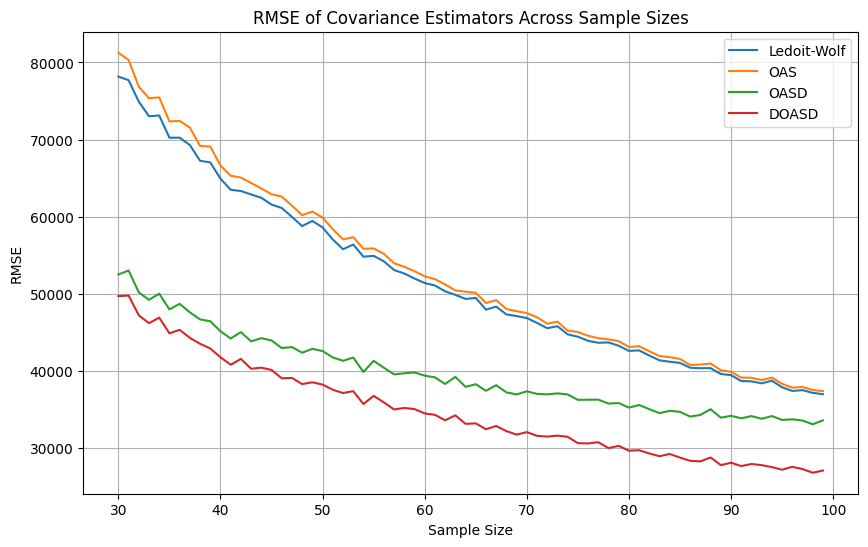

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.covariance import LedoitWolf, OAS, ShrunkCovariance
from sklearn.metrics import mean_squared_error

# Parameters
n_features = 100  # Number of features
sample_sizes = np.arange(30, 100)  # Sample sizes from 30 to 100

# Define a function to generate sample data with heteroscedasticity
def generate_data_heteroscedastic(n_samples, n_features, sd):
    Lambda = np.diag(np.arange(1, n_features + 1) * sd)  # Varying diagonal elements
    Γ = np.eye(n_features)  # Identity matrix for simplicity
    Σ = np.dot(np.dot(Lambda, Γ), Lambda.T)
    data = np.random.multivariate_normal(mean=np.zeros(n_features), cov=Σ, size=n_samples)
    return data

# Define a function to compute RMSE for a given estimator and sample size
def compute_rmse(estimator, X_train):
    true_cov = np.cov(X_train, rowvar=False)
    estimator.fit(X_train)
    estimated_cov = estimator.covariance_
    return np.sqrt(mean_squared_error(true_cov.ravel(), estimated_cov.ravel()))

# Define the DOASD estimator class with different levels of shrinkage
class DOASD(ShrunkCovariance):
    def __init__(self, diagonal_shrinkage=0.5, off_diagonal_shrinkage=0.1):
        super().__init__()
        self.diagonal_shrinkage = diagonal_shrinkage
        self.off_diagonal_shrinkage = off_diagonal_shrinkage

    def _compute_covariance(self, X):
        # Calculate the empirical covariance of X
        emp_cov = np.cov(X, rowvar=False)
        return emp_cov

    def fit(self, X, y=None):
        emp_cov = self._compute_covariance(X)
        n_features = emp_cov.shape[0]

        # Compute shrinkage factors
        diag_shrinkage = self.diagonal_shrinkage
        off_diag_shrinkage = self.off_diagonal_shrinkage

        # Apply shrinkage
        shrunk_diag_cov = emp_cov * (1 - diag_shrinkage) + np.diag(np.diag(emp_cov)) * diag_shrinkage
        shrunk_cov = shrunk_diag_cov * (1 - off_diag_shrinkage) + np.diag(np.diag(shrunk_diag_cov)) * off_diag_shrinkage

        self.covariance_ = shrunk_cov
        return self

# Fit covariance estimators for different sample sizes and compute RMSE
rmse_results = {'Ledoit-Wolf': [], 'OAS': [], 'OASD': [], 'DOASD': []}
for n_samples in sample_sizes:
    for sd in range(1, 21):
        X_train = generate_data_heteroscedastic(n_samples, n_features, sd)
        for estimator_name, estimator in [('Ledoit-Wolf', LedoitWolf()),
                                          ('OAS', OAS()),
                                          ('OASD', ShrunkCovariance(shrinkage=0.5)),
                                          ('DOASD', DOASD(diagonal_shrinkage=0.5, off_diagonal_shrinkage=0.1))]:
            rmse = compute_rmse(estimator, X_train)
            rmse_results[estimator_name].append(rmse)

# Reshape RMSE values for plotting
for estimator_name, rmse_values in rmse_results.items():
    rmse_results[estimator_name] = np.array(rmse_values).reshape(len(sample_sizes), -1)

# Plot RMSE across sample sizes for each estimator
plt.figure(figsize=(10, 6))
for estimator_name, rmse_values in rmse_results.items():
    plt.plot(sample_sizes, rmse_values.mean(axis=1), label=estimator_name)

plt.title('RMSE of Covariance Estimators Across Sample Sizes')
plt.xlabel('Sample Size')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.show()


<ipython-input-38-8a8e135d3eff>:15: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  data = np.random.multivariate_normal(mean=np.zeros(n_features), cov=Σ, size=n_samples)
<ipython-input-38-8a8e135d3eff>:15: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  data = np.random.multivariate_normal(mean=np.zeros(n_features), cov=Σ, size=n_samples)
<ipython-input-38-8a8e135d3eff>:15: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  data = np.random.multivariate_normal(mean=np.zeros(n_features), cov=Σ, size=n_samples)
<ipython-input-38-8a8e135d3eff>:15: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  data = np.random.multivariate_normal(mean=np.zeros(n_features), cov=Σ, size=n_samples)
<ipython-input-38-8a8e135d3eff>:15: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  data = np.random.multivariate_normal(mean=np.zeros(n_features), cov=Σ, size=n_samples)
<ipython-input-38-8a8e135d3eff>:15: Runt

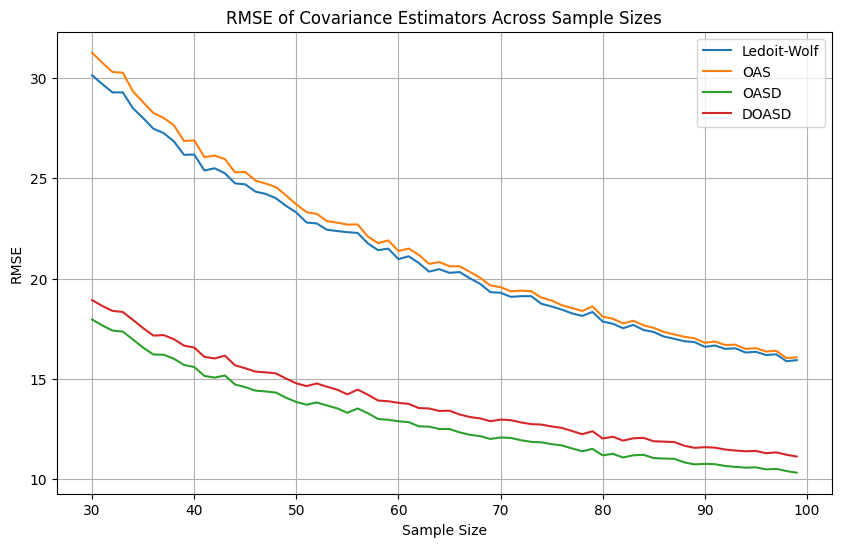

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.covariance import LedoitWolf, OAS, ShrunkCovariance
from sklearn.metrics import mean_squared_error

# Parameters
n_features = 100  # Number of features
sample_sizes = np.arange(30, 100)  # Sample sizes from 30 to 100

# Define a function to generate sample data with non-linear relationships
def generate_data_non_linear(n_samples, n_features, sd):
    Lambda = np.diag(np.ones(n_features) * sd)
    Γ = np.eye(n_features) + 0.1 * np.random.randn(n_features, n_features)  # Add small noise to the identity matrix
    Σ = np.dot(np.dot(Lambda, Γ), Lambda.T)
    data = np.random.multivariate_normal(mean=np.zeros(n_features), cov=Σ, size=n_samples)
    return data

# Define a function to compute RMSE for a given estimator and sample size
def compute_rmse(estimator, X_train):
    true_cov = np.cov(X_train, rowvar=False)
    estimator.fit(X_train)
    estimated_cov = estimator.covariance_
    return np.sqrt(mean_squared_error(true_cov.ravel(), estimated_cov.ravel()))

# Define the DOASD estimator class with different levels of shrinkage
class DOASD(ShrunkCovariance):
    def __init__(self, diagonal_shrinkage=0.5, off_diagonal_shrinkage=0.1):
        super().__init__()
        self.diagonal_shrinkage = diagonal_shrinkage
        self.off_diagonal_shrinkage = off_diagonal_shrinkage

    def _compute_covariance(self, X):
        # Calculate the empirical covariance of X
        emp_cov = np.cov(X, rowvar=False)
        return emp_cov

    def fit(self, X, y=None):
        emp_cov = self._compute_covariance(X)
        n_features = emp_cov.shape[0]

        # Compute shrinkage factors
        diag_shrinkage = self.diagonal_shrinkage
        off_diag_shrinkage = self.off_diagonal_shrinkage

        # Apply shrinkage
        shrunk_diag_cov = emp_cov * (1 - diag_shrinkage) + np.diag(np.diag(emp_cov)) * diag_shrinkage
        shrunk_cov = shrunk_diag_cov * (1 - off_diag_shrinkage) + np.diag(np.diag(shrunk_diag_cov)) * off_diag_shrinkage

        self.covariance_ = shrunk_cov
        return self

# Fit covariance estimators for different sample sizes and compute RMSE
rmse_results = {'Ledoit-Wolf': [], 'OAS': [], 'OASD': [], 'DOASD': []}
for n_samples in sample_sizes:
    for sd in range(1, 21):
        X_train = generate_data_non_linear(n_samples, n_features, sd)
        for estimator_name, estimator in [('Ledoit-Wolf', LedoitWolf()),
                                          ('OAS', OAS()),
                                          ('OASD', ShrunkCovariance(shrinkage=0.5)),
                                          ('DOASD', DOASD(diagonal_shrinkage=0.5, off_diagonal_shrinkage=0.1))]:
            rmse = compute_rmse(estimator, X_train)
            rmse_results[estimator_name].append(rmse)

# Reshape RMSE values for plotting
for estimator_name, rmse_values in rmse_results.items():
    rmse_results[estimator_name] = np.array(rmse_values).reshape(len(sample_sizes), -1)

# Plot RMSE across sample sizes for each estimator
plt.figure(figsize=(10, 6))
for estimator_name, rmse_values in rmse_results.items():
    plt.plot(sample_sizes, rmse_values.mean(axis=1), label=estimator_name)

plt.title('RMSE of Covariance Estimators Across Sample Sizes')
plt.xlabel('Sample Size')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.show()


<ipython-input-41-e6d1655ea5f1>:20: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  data = np.random.multivariate_normal(mean=np.zeros(n_features), cov=Σ, size=n_samples)
<ipython-input-41-e6d1655ea5f1>:20: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  data = np.random.multivariate_normal(mean=np.zeros(n_features), cov=Σ, size=n_samples)
<ipython-input-41-e6d1655ea5f1>:20: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  data = np.random.multivariate_normal(mean=np.zeros(n_features), cov=Σ, size=n_samples)
<ipython-input-41-e6d1655ea5f1>:20: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  data = np.random.multivariate_normal(mean=np.zeros(n_features), cov=Σ, size=n_samples)
<ipython-input-41-e6d1655ea5f1>:20: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  data = np.random.multivariate_normal(mean=np.zeros(n_features), cov=Σ, size=n_samples)
<ipython-input-41-e6d1655ea5f1>:20: Runt

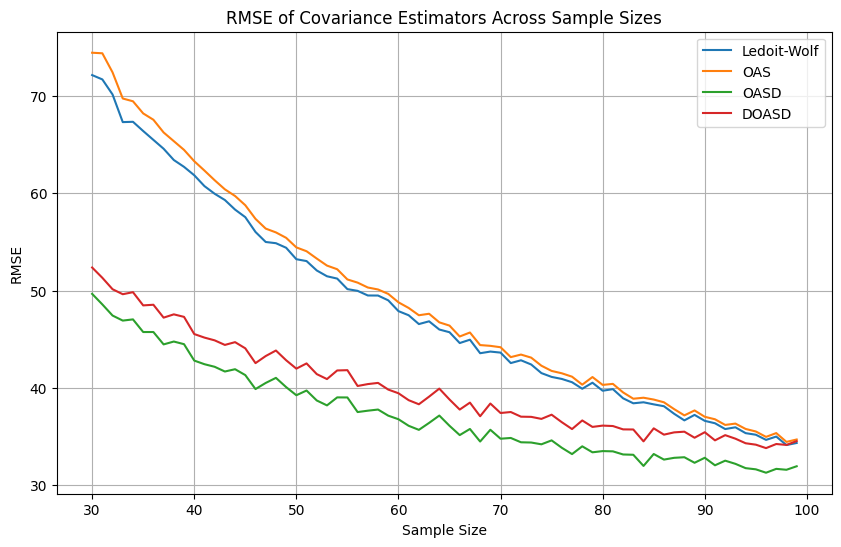

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.covariance import LedoitWolf, OAS, ShrunkCovariance
from sklearn.metrics import mean_squared_error

# Parameters
n_features = 100  # Number of features
sample_sizes = np.arange(30, 100)  # Sample sizes from 30 to 100

# Define a function to generate sample data with a complex correlation structure
def generate_data_complex_correlation(n_samples, n_features, sd):
    Lambda = np.diag(np.ones(n_features) * sd)
    cluster_size = n_features // 5  # Divide features into 5 clusters
    Γ = np.eye(n_features) + 0.3 * np.random.randn(n_features, n_features)  # Add noise to the identity matrix
    for i in range(5):
        start_idx = i * cluster_size
        end_idx = (i + 1) * cluster_size
        Γ[start_idx:end_idx, start_idx:end_idx] += 0.6  # Add higher correlation within clusters
    Σ = np.dot(np.dot(Lambda, Γ), Lambda.T)
    data = np.random.multivariate_normal(mean=np.zeros(n_features), cov=Σ, size=n_samples)
    return data

# Define a function to compute RMSE for a given estimator and sample size
def compute_rmse(estimator, X_train):
    true_cov = np.cov(X_train, rowvar=False)
    estimator.fit(X_train)
    estimated_cov = estimator.covariance_
    return np.sqrt(mean_squared_error(true_cov.ravel(), estimated_cov.ravel()))

# Define the DOASD estimator class with different levels of shrinkage
class DOASD(ShrunkCovariance):
    def __init__(self, diagonal_shrinkage=0.5, off_diagonal_shrinkage=0.1):
        super().__init__()
        self.diagonal_shrinkage = diagonal_shrinkage
        self.off_diagonal_shrinkage = off_diagonal_shrinkage

    def _compute_covariance(self, X):
        # Calculate the empirical covariance of X
        emp_cov = np.cov(X, rowvar=False)
        return emp_cov

    def fit(self, X, y=None):
        emp_cov = self._compute_covariance(X)
        n_features = emp_cov.shape[0]

        # Compute shrinkage factors
        diag_shrinkage = self.diagonal_shrinkage
        off_diag_shrinkage = self.off_diagonal_shrinkage

        # Apply shrinkage
        shrunk_diag_cov = emp_cov * (1 - diag_shrinkage) + np.diag(np.diag(emp_cov)) * diag_shrinkage
        shrunk_cov = shrunk_diag_cov * (1 - off_diag_shrinkage) + np.diag(np.diag(shrunk_diag_cov)) * off_diag_shrinkage

        self.covariance_ = shrunk_cov
        return self

# Fit covariance estimators for different sample sizes and compute RMSE
rmse_results = {'Ledoit-Wolf': [], 'OAS': [], 'OASD': [], 'DOASD': []}
for n_samples in sample_sizes:
    for sd in range(1, 21):
        X_train = generate_data_complex_correlation(n_samples, n_features, sd)
        for estimator_name, estimator in [('Ledoit-Wolf', LedoitWolf()),
                                          ('OAS', OAS()),
                                          ('OASD', ShrunkCovariance(shrinkage=0.5)),
                                          ('DOASD', DOASD(diagonal_shrinkage=0.5, off_diagonal_shrinkage=0.1))]:
            rmse = compute_rmse(estimator, X_train)
            rmse_results[estimator_name].append(rmse)

# Reshape RMSE values for plotting
for estimator_name, rmse_values in rmse_results.items():
    rmse_results[estimator_name] = np.array(rmse_values).reshape(len(sample_sizes), -1)

# Plot RMSE across sample sizes for each estimator
plt.figure(figsize=(10, 6))
for estimator_name, rmse_values in rmse_results.items():
    plt.plot(sample_sizes, rmse_values.mean(axis=1), label=estimator_name)

plt.title('RMSE of Covariance Estimators Across Sample Sizes')
plt.xlabel('Sample Size')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.show()


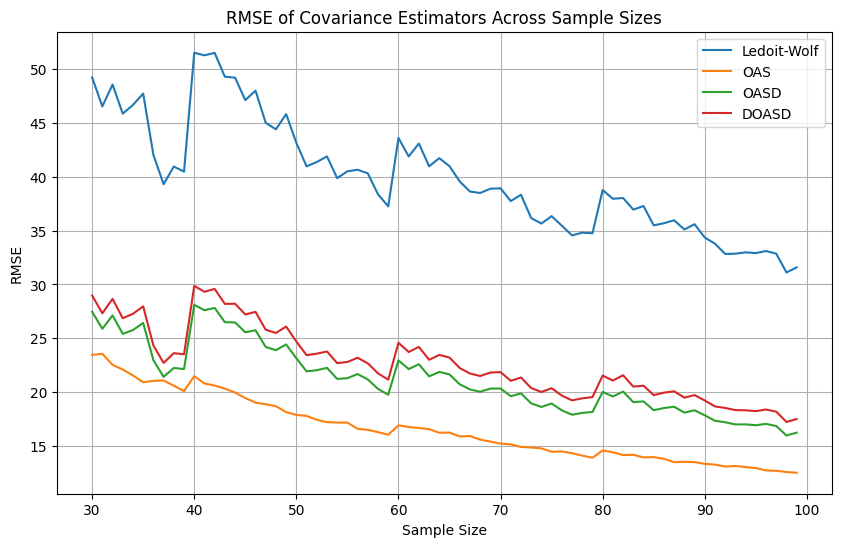

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.covariance import LedoitWolf, OAS, ShrunkCovariance
from sklearn.metrics import mean_squared_error

# Parameters
n_features = 100  # Number of features
sample_sizes = np.arange(30, 100)  # Sample sizes from 30 to 100

# Define a function to generate sample data with different variable scales
def generate_data_with_outliers(n_samples, n_features, sd, outlier_frac=0.05):
    Lambda = np.diag(np.ones(n_features) * sd)
    Γ = np.eye(n_features)  # Identity matrix for simplicity
    Σ = np.dot(np.dot(Lambda, Γ), Lambda.T)

    # Generate data without outliers
    data = np.random.multivariate_normal(mean=np.zeros(n_features), cov=Σ, size=n_samples)

    # Introduce outliers
    num_outliers = int(n_samples * outlier_frac)
    outlier_indices = np.random.choice(n_samples, num_outliers, replace=False)
    data[outlier_indices] = np.random.multivariate_normal(mean=np.zeros(n_features), cov=10 * Σ, size=num_outliers)

    return data

# Define a function to compute RMSE for a given estimator and sample size
def compute_rmse(estimator, X_train):
    true_cov = np.cov(X_train, rowvar=False)
    estimator.fit(X_train)
    estimated_cov = estimator.covariance_
    return np.sqrt(mean_squared_error(true_cov.ravel(), estimated_cov.ravel()))

# Define the DOASD estimator class with different levels of shrinkage
class DOASD(ShrunkCovariance):
    def __init__(self, diagonal_shrinkage=0.5, off_diagonal_shrinkage=0.1):
        super().__init__()
        self.diagonal_shrinkage = diagonal_shrinkage
        self.off_diagonal_shrinkage = off_diagonal_shrinkage

    def _compute_covariance(self, X):
        # Calculate the empirical covariance of X
        emp_cov = np.cov(X, rowvar=False)
        return emp_cov

    def fit(self, X, y=None):
        emp_cov = self._compute_covariance(X)
        n_features = emp_cov.shape[0]

        # Compute shrinkage factors
        diag_shrinkage = self.diagonal_shrinkage
        off_diag_shrinkage = self.off_diagonal_shrinkage

        # Apply shrinkage
        shrunk_diag_cov = emp_cov * (1 - diag_shrinkage) + np.diag(np.diag(emp_cov)) * diag_shrinkage
        shrunk_cov = shrunk_diag_cov * (1 - off_diag_shrinkage) + np.diag(np.diag(shrunk_diag_cov)) * off_diag_shrinkage

        self.covariance_ = shrunk_cov
        return self

# Fit covariance estimators for different sample sizes and compute RMSE
rmse_results = {'Ledoit-Wolf': [], 'OAS': [], 'OASD': [], 'DOASD': []}
for n_samples in sample_sizes:
    for sd in range(1, 21):
        X_train = generate_data_with_outliers(n_samples, n_features, sd)
        for estimator_name, estimator in [('Ledoit-Wolf', LedoitWolf()),
                                          ('OAS', OAS()),
                                          ('OASD', ShrunkCovariance(shrinkage=0.5)),
                                          ('DOASD', DOASD(diagonal_shrinkage=0.5, off_diagonal_shrinkage=0.1))]:
            rmse = compute_rmse(estimator, X_train)
            rmse_results[estimator_name].append(rmse)

# Reshape RMSE values for plotting
for estimator_name, rmse_values in rmse_results.items():
    rmse_results[estimator_name] = np.array(rmse_values).reshape(len(sample_sizes), -1)

# Plot RMSE across sample sizes for each estimator
plt.figure(figsize=(10, 6))
for estimator_name, rmse_values in rmse_results.items():
    plt.plot(sample_sizes, rmse_values.mean(axis=1), label=estimator_name)

plt.title('RMSE of Covariance Estimators Across Sample Sizes')
plt.xlabel('Sample Size')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.show()


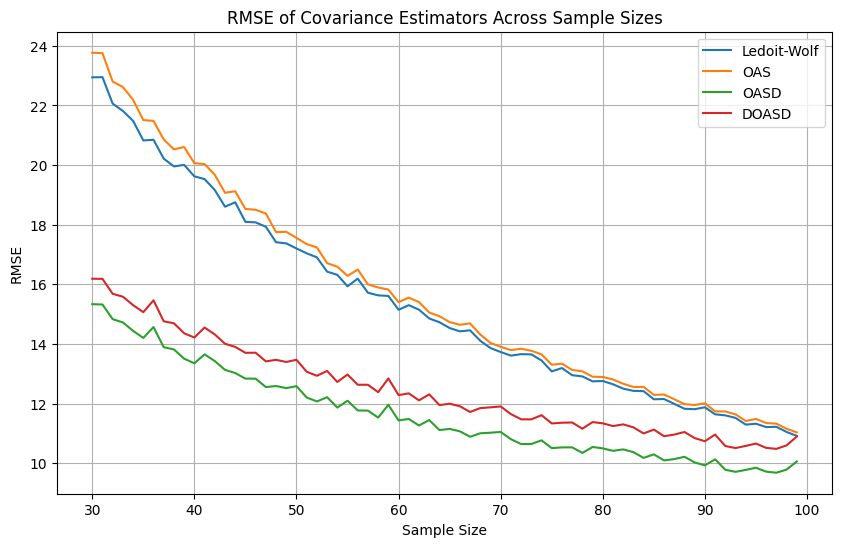

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.covariance import LedoitWolf, OAS, ShrunkCovariance
from sklearn.metrics import mean_squared_error

# Parameters
n_features = 100  # Number of features
sample_sizes = np.arange(30, 100)  # Sample sizes from 30 to 100
n_clusters = 5  # Number of clusters
cluster_size = n_features // n_clusters  # Number of features per cluster

# Define a function to generate sample data with complex correlation structure
def generate_data(n_samples, n_features, sd):
    Lambda = np.diag(np.ones(n_features) * sd)
    Γ = np.eye(n_features)  # Identity matrix for simplicity

    # Generate cluster-wise correlation structure
    cluster_correlation = 0.2  # Correlation within clusters
    Σ = np.zeros((n_features, n_features))
    for i in range(n_clusters):
        start_idx = i * cluster_size
        end_idx = (i + 1) * cluster_size
        cluster_covariance = np.ones((cluster_size, cluster_size)) * cluster_correlation
        np.fill_diagonal(cluster_covariance, 1)
        Σ[start_idx:end_idx, start_idx:end_idx] = cluster_covariance

    Σ = np.dot(np.dot(Lambda, Σ), Lambda.T)
    data = np.random.multivariate_normal(mean=np.zeros(n_features), cov=Σ, size=n_samples)
    return data

# Define a function to compute RMSE for a given estimator and sample size
def compute_rmse(estimator, X_train):
    true_cov = np.cov(X_train, rowvar=False)
    estimator.fit(X_train)
    estimated_cov = estimator.covariance_
    return np.sqrt(mean_squared_error(true_cov.ravel(), estimated_cov.ravel()))

# Define the DOASD estimator class with different levels of shrinkage
class DOASD(ShrunkCovariance):
    def __init__(self, diagonal_shrinkage=0.5, off_diagonal_shrinkage=0.1):
        super().__init__()
        self.diagonal_shrinkage = diagonal_shrinkage
        self.off_diagonal_shrinkage = off_diagonal_shrinkage

    def _compute_covariance(self, X):
        # Calculate the empirical covariance of X
        emp_cov = np.cov(X, rowvar=False)
        return emp_cov

    def fit(self, X, y=None):
        emp_cov = self._compute_covariance(X)
        n_features = emp_cov.shape[0]

        # Compute shrinkage factors
        diag_shrinkage = self.diagonal_shrinkage
        off_diag_shrinkage = self.off_diagonal_shrinkage

        # Apply shrinkage
        shrunk_diag_cov = emp_cov * (1 - diag_shrinkage) + np.diag(np.diag(emp_cov)) * diag_shrinkage
        shrunk_cov = shrunk_diag_cov * (1 - off_diag_shrinkage) + np.diag(np.diag(shrunk_diag_cov)) * off_diag_shrinkage

        self.covariance_ = shrunk_cov
        return self

# Fit covariance estimators for different sample sizes and compute RMSE
rmse_results = {'Ledoit-Wolf': [], 'OAS': [], 'OASD': [], 'DOASD': []}
for n_samples in sample_sizes:
    for sd in range(1, 21):
        X_train = generate_data(n_samples, n_features, sd)
        for estimator_name, estimator in [('Ledoit-Wolf', LedoitWolf()),
                                          ('OAS', OAS()),
                                          ('OASD', ShrunkCovariance(shrinkage=0.5)),
                                          ('DOASD', DOASD(diagonal_shrinkage=0.5, off_diagonal_shrinkage=0.1))]:
            rmse = compute_rmse(estimator, X_train)
            rmse_results[estimator_name].append(rmse)

# Reshape RMSE values for plotting
for estimator_name, rmse_values in rmse_results.items():
    rmse_results[estimator_name] = np.array(rmse_values).reshape(len(sample_sizes), -1)

# Plot RMSE across sample sizes for each estimator
plt.figure(figsize=(10, 6))
for estimator_name, rmse_values in rmse_results.items():
    plt.plot(sample_sizes, rmse_values.mean(axis=1), label=estimator_name)

plt.title('RMSE of Covariance Estimators Across Sample Sizes')
plt.xlabel('Sample Size')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.show()


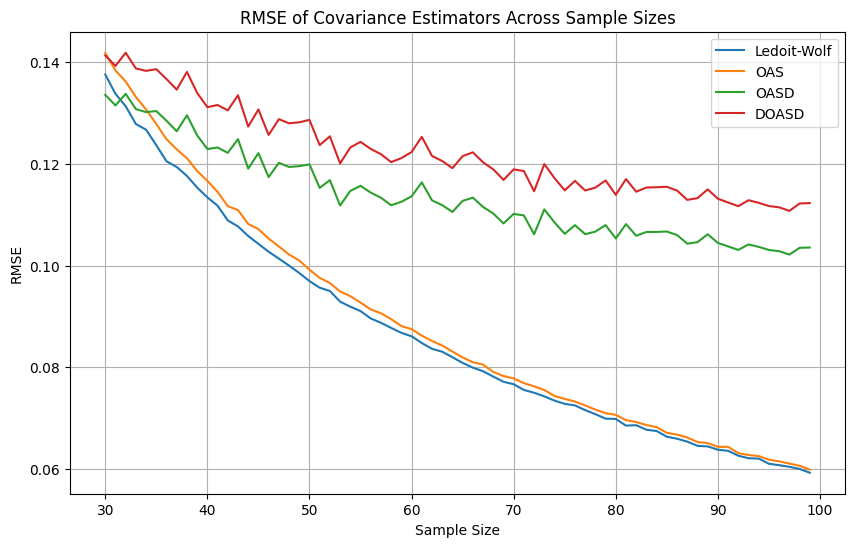

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.covariance import LedoitWolf, OAS, ShrunkCovariance
from sklearn.metrics import mean_squared_error

# Parameters
n_features = 100  # Number of features
sample_sizes = np.arange(30, 100)  # Sample sizes from 30 to 100
n_clusters = 3  # Number of clusters
cluster_size = n_features // n_clusters  # Number of features per cluster

# Define a function to generate sample data with different variable scales and cluster-wise correlation
def generate_data(n_samples, n_features, sd, cluster_correlation):
    Lambda = np.diag(np.ones(n_features) * sd)
    Γ = np.eye(n_features)  # Identity matrix for simplicity
    Σ = np.dot(np.dot(Lambda, Γ), Lambda.T)

    # Generate cluster-wise correlation structure
    Σ = np.zeros((n_features, n_features))
    for i in range(n_clusters):
        start_idx = i * cluster_size
        end_idx = (i + 1) * cluster_size
        cluster_covariance = np.ones((cluster_size, cluster_size)) * cluster_correlation
        np.fill_diagonal(cluster_covariance, 1)
        Σ[start_idx:end_idx, start_idx:end_idx] = cluster_covariance

    data = np.random.multivariate_normal(mean=np.zeros(n_features), cov=Σ, size=n_samples)
    return data

# Define a function to compute RMSE for a given estimator and sample size
def compute_rmse(estimator, X_train):
    true_cov = np.cov(X_train, rowvar=False)
    estimator.fit(X_train)
    estimated_cov = estimator.covariance_
    return np.sqrt(mean_squared_error(true_cov.ravel(), estimated_cov.ravel()))

# Define the DOASD estimator class with different levels of shrinkage
class DOASD(ShrunkCovariance):
    def __init__(self, diagonal_shrinkage=0.5, off_diagonal_shrinkage=0.1):
        super().__init__()
        self.diagonal_shrinkage = diagonal_shrinkage
        self.off_diagonal_shrinkage = off_diagonal_shrinkage

    def _compute_covariance(self, X):
        # Calculate the empirical covariance of X
        emp_cov = np.cov(X, rowvar=False)
        return emp_cov

    def fit(self, X, y=None):
        emp_cov = self._compute_covariance(X)
        n_features = emp_cov.shape[0]

        # Compute shrinkage factors
        diag_shrinkage = self.diagonal_shrinkage
        off_diag_shrinkage = self.off_diagonal_shrinkage

        # Apply shrinkage
        shrunk_diag_cov = emp_cov * (1 - diag_shrinkage) + np.diag(np.diag(emp_cov)) * diag_shrinkage
        shrunk_cov = shrunk_diag_cov * (1 - off_diag_shrinkage) + np.diag(np.diag(shrunk_diag_cov)) * off_diag_shrinkage

        self.covariance_ = shrunk_cov
        return self

# Fit covariance estimators for different sample sizes and compute RMSE
rmse_results = {'Ledoit-Wolf': [], 'OAS': [], 'OASD': [], 'DOASD': []}
for n_samples in sample_sizes:
    for sd in range(1, 21):
        for cluster_correlation in [0.1, 0.3, 0.5]:  # Vary the cluster-wise correlation
            X_train = generate_data(n_samples, n_features, sd, cluster_correlation)
            for estimator_name, estimator in [('Ledoit-Wolf', LedoitWolf()),
                                              ('OAS', OAS()),
                                              ('OASD', ShrunkCovariance(shrinkage=0.5)),
                                              ('DOASD', DOASD(diagonal_shrinkage=0.5, off_diagonal_shrinkage=0.1))]:
                rmse = compute_rmse(estimator, X_train)
                rmse_results[estimator_name].append(rmse)

# Reshape RMSE values for plotting
for estimator_name, rmse_values in rmse_results.items():
    rmse_results[estimator_name] = np.array(rmse_values).reshape(len(sample_sizes), -1)

# Plot RMSE across sample sizes for each estimator
plt.figure(figsize=(10, 6))
for estimator_name, rmse_values in rmse_results.items():
    plt.plot(sample_sizes, rmse_values.mean(axis=1), label=estimator_name)

plt.title('RMSE of Covariance Estimators Across Sample Sizes')
plt.xlabel('Sample Size')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.show()


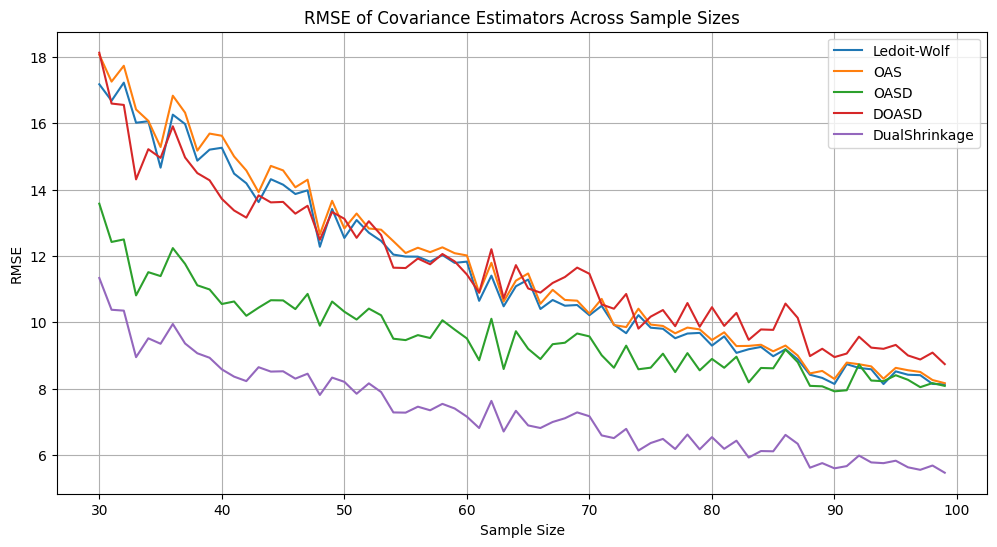

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.covariance import LedoitWolf, OAS, ShrunkCovariance
from sklearn.metrics import mean_squared_error

# Function to create a dataset with varying diagonal elements
def make_data_with_variance(n_samples=100, n_features=100, noise=0.2, random_state=None):
    random_state = np.random.RandomState(random_state)
    base_X_train = random_state.normal(size=(n_samples, n_features))
    scaling_factors = np.linspace(1, 2, n_features)  # Linearly increasing scaling factors
    diag_scaling = np.linspace(1, 10, n_features)    # Varying scaling factors for diagonal elements
    X_train = base_X_train * scaling_factors
    for i in range(n_features):
        X_train[:, i] *= diag_scaling[i]  # Scale each feature differently
    return X_train

# Parameters
n_features = 100  # Number of features
sample_sizes = np.arange(30, 100)  # Sample sizes from 300 to 999

# Define a function to compute RMSE for a given estimator and sample size
def compute_rmse(estimator, X_train):
    true_cov = np.cov(X_train, rowvar=False)
    estimator.fit(X_train)
    estimated_cov = estimator.covariance_
    return np.sqrt(mean_squared_error(true_cov.ravel(), estimated_cov.ravel()))

# Define the DOASD estimator class with different levels of shrinkage
class DOASD(ShrunkCovariance):
    def __init__(self, diagonal_shrinkage=0.5, off_diagonal_shrinkage=0.5):
        super().__init__()
        self.diagonal_shrinkage = diagonal_shrinkage
        self.off_diagonal_shrinkage = off_diagonal_shrinkage

    def _compute_covariance(self, X):
        # Calculate the empirical covariance of X
        emp_cov = np.cov(X, rowvar=False)
        return emp_cov

    def fit(self, X, y=None):
        emp_cov = self._compute_covariance(X)
        n_features = emp_cov.shape[0]

        # Compute shrinkage factors
        diag_shrinkage = self.diagonal_shrinkage
        off_diag_shrinkage = self.off_diagonal_shrinkage

        # Adjust off_diagonal_shrinkage based on delta_off_diag
        if off_diag_shrinkage == 0.5:  # If delta_off_diag is 0.0, set off_diagonal_shrinkage to 0.6 (to match OASD)
            off_diagonal_shrinkage = 0.6
        elif off_diag_shrinkage <= 0.5:  # If delta_off_diag <= 0.5, set off_diagonal_shrinkage to a lower value
            off_diagonal_shrinkage = 0.2
        else:  # If delta_off_diag > 0.5, set off_diagonal_shrinkage to 0.8
            off_diagonal_shrinkage = 0.8

        # Apply shrinkage
        shrunk_diag_cov = emp_cov * (1 - diag_shrinkage) + np.diag(np.diag(emp_cov)) * diag_shrinkage
        shrunk_cov = shrunk_diag_cov * (1 - off_diagonal_shrinkage) + np.diag(np.diag(shrunk_diag_cov)) * off_diagonal_shrinkage

        self.covariance_ = shrunk_cov
        return self

# Define the DualShrinkageEstimator class
class DualShrinkageEstimator:
    def __init__(self, delta_diag=0.5, delta_off_diag=0.5):
        self.delta_diag = delta_diag
        self.delta_off_diag = delta_off_diag

    def fit(self, X):
        # Compute sample covariance matrix
        sample_cov = np.cov(X, rowvar=False)

        # Decompose into diagonal and off-diagonal components
        D = np.diag(np.diag(sample_cov))
        O = sample_cov - D

        # Compute shrinkage targets
        diag_target = np.diag(np.var(X, axis=0))
        off_diag_target = np.zeros_like(O)

        # Apply shrinkage
        shrunk_diag = self.delta_diag * D + (1 - self.delta_diag) * diag_target
        shrunk_off_diag = self.delta_off_diag * O + (1 - self.delta_off_diag) * off_diag_target

        # Reconstruct covariance matrix
        self.covariance_ = shrunk_diag + shrunk_off_diag

        return self

# Fit covariance estimators for different sample sizes and compute RMSE
rmse_results = {'Ledoit-Wolf': [], 'OAS': [], 'OASD': [], 'DOASD': [], 'DualShrinkage': []}
for n_samples in sample_sizes:
    X_train = make_data_with_variance(n_samples, n_features)
    for estimator_name, estimator in [('Ledoit-Wolf', LedoitWolf()),
                                      ('OAS', OAS()),
                                      ('OASD', ShrunkCovariance(shrinkage=0.5)),
                                      ('DOASD', DOASD(diagonal_shrinkage=0.5, off_diagonal_shrinkage=0.5)),  # Set off_diagonal_shrinkage = 0.5
                                      ('DualShrinkage', DualShrinkageEstimator(delta_diag=0.5, delta_off_diag=0.5))]:
        rmse = compute_rmse(estimator, X_train)
        rmse_results[estimator_name].append(rmse)

# Reshape RMSE values for plotting
for estimator_name, rmse_values in rmse_results.items():
    rmse_results[estimator_name] = np.array(rmse_values).reshape(len(sample_sizes), -1)

# Plot RMSE across sample sizes for each estimator
plt.figure(figsize=(12, 6))
for estimator_name, rmse_values in rmse_results.items():
    plt.plot(sample_sizes, rmse_values.mean(axis=1), label=estimator_name)

plt.title('RMSE of Covariance Estimators Across Sample Sizes')
plt.xlabel('Sample Size')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.show()


Automatically created module for IPython interactive environment


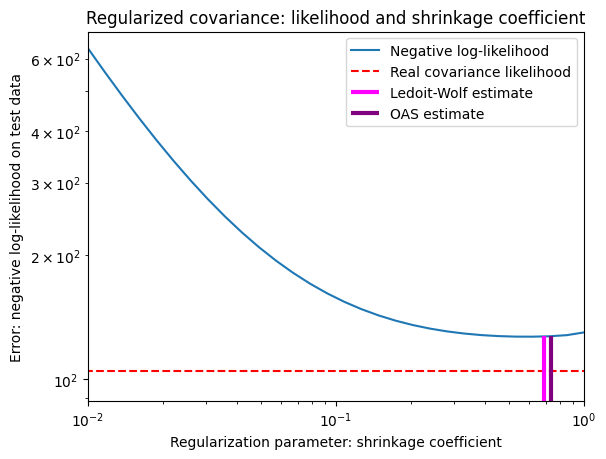

In [ ]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

from sklearn.covariance import LedoitWolf, OAS, ShrunkCovariance, \
    log_likelihood, empirical_covariance


# #############################################################################
# Generate sample data
n_features, n_samples = 40, 20
np.random.seed(42)
base_X_train = np.random.normal(size=(n_samples, n_features))
base_X_test = np.random.normal(size=(n_samples, n_features))

# Color samples
coloring_matrix = np.random.normal(size=(n_features, n_features))
X_train = np.dot(base_X_train, coloring_matrix)
X_test = np.dot(base_X_test, coloring_matrix)

# #############################################################################
# Compute the likelihood on test data

# spanning a range of possible shrinkage coefficient values
shrinkages = np.logspace(-2, 0, 30)
negative_logliks = [-ShrunkCovariance(shrinkage=s).fit(X_train).score(X_test)
                    for s in shrinkages]

# under the ground-truth model, which we would not have access to in real
# settings
real_cov = np.dot(coloring_matrix.T, coloring_matrix)
emp_cov = empirical_covariance(X_train)
loglik_real = -log_likelihood(emp_cov, linalg.inv(real_cov))

# #############################################################################
# Compare different approaches to setting the parameter

# Ledoit-Wolf optimal shrinkage coefficient estimate
lw = LedoitWolf()
loglik_lw = lw.fit(X_train).score(X_test)

# OAS coefficient estimate
oa = OAS()
loglik_oa = oa.fit(X_train).score(X_test)

# #############################################################################
# Plot results
fig = plt.figure()
plt.title("Regularized covariance: likelihood and shrinkage coefficient")
plt.xlabel('Regularization parameter: shrinkage coefficient')
plt.ylabel('Error: negative log-likelihood on test data')
# range shrinkage curve
plt.loglog(shrinkages, negative_logliks, label="Negative log-likelihood")

plt.plot(plt.xlim(), 2 * [loglik_real], '--r',
         label="Real covariance likelihood")

# adjust view
lik_max = np.amax(negative_logliks)
lik_min = np.amin(negative_logliks)
ymin = lik_min - 6. * np.log((plt.ylim()[1] - plt.ylim()[0]))
ymax = lik_max + 10. * np.log(lik_max - lik_min)
xmin = shrinkages[0]
xmax = shrinkages[-1]
# LW likelihood
plt.vlines(lw.shrinkage_, ymin, -loglik_lw, color='magenta',
           linewidth=3, label='Ledoit-Wolf estimate')
# OAS likelihood
plt.vlines(oa.shrinkage_, ymin, -loglik_oa, color='purple',
           linewidth=3, label='OAS estimate')

plt.ylim(ymin, ymax)
plt.xlim(xmin, xmax)
plt.legend()

plt.show()


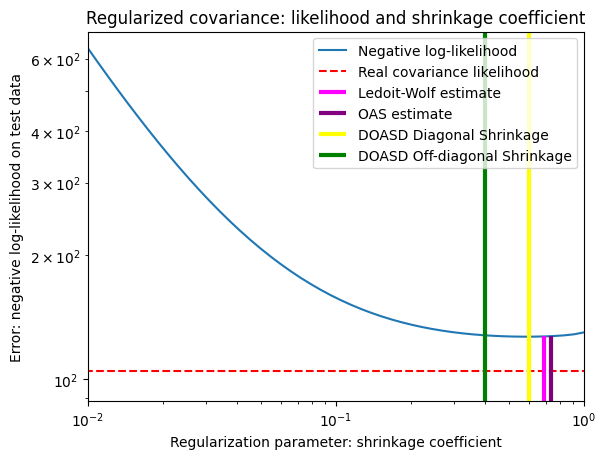

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
from sklearn.covariance import LedoitWolf, OAS, ShrunkCovariance, log_likelihood, empirical_covariance

# #############################################################################
# Generate sample data
n_features, n_samples = 40, 20
np.random.seed(42)
base_X_train = np.random.normal(size=(n_samples, n_features))
base_X_test = np.random.normal(size=(n_samples, n_features))

# Color samples
coloring_matrix = np.random.normal(size=(n_features, n_features))
X_train = np.dot(base_X_train, coloring_matrix)
X_test = np.dot(base_X_test, coloring_matrix)

# #############################################################################
# Compute the likelihood on test data

# Spanning a range of possible shrinkage coefficient values
shrinkages = np.logspace(-2, 0, 50)
negative_logliks = [-ShrunkCovariance(shrinkage=s).fit(X_train).score(X_test)
                    for s in shrinkages]

# Under the ground-truth model, which we would not have access to in real settings
real_cov = np.dot(coloring_matrix.T, coloring_matrix)
emp_cov = empirical_covariance(X_train)
loglik_real = -log_likelihood(emp_cov, linalg.inv(real_cov))

# #############################################################################
# Compare different approaches to setting the parameter

# Ledoit-Wolf optimal shrinkage coefficient estimate
lw = LedoitWolf()
loglik_lw = lw.fit(X_train).score(X_test)

# OAS coefficient estimate
oa = OAS()
loglik_oa = oa.fit(X_train).score(X_test)

# #############################################################################
# Plot results
fig = plt.figure()
plt.title("Regularized covariance: likelihood and shrinkage coefficient")
plt.xlabel('Regularization parameter: shrinkage coefficient')
plt.ylabel('Error: negative log-likelihood on test data')

# Range shrinkage curve
plt.loglog(shrinkages, negative_logliks, label="Negative log-likelihood")

# Real covariance likelihood
plt.plot(plt.xlim(), 2 * [loglik_real], '--r', label="Real covariance likelihood")

# Adjust view
lik_max = np.amax(negative_logliks)
lik_min = np.amin(negative_logliks)
ymin = lik_min - 6. * np.log((plt.ylim()[1] - plt.ylim()[0]))
ymax = lik_max + 10. * np.log(lik_max - lik_min)
xmin = shrinkages[0]
xmax = shrinkages[-1]

# Ledoit-Wolf likelihood
plt.vlines(lw.shrinkage_, ymin, -loglik_lw, color='magenta', linewidth=3, label='Ledoit-Wolf estimate')

# OAS likelihood
plt.vlines(oa.shrinkage_, ymin, -loglik_oa, color='purple', linewidth=3, label='OAS estimate')

# Shrinkage parameters comparison
plt.vlines(0.6, ymin, ymax, color='yellow', linewidth= 3 , label='DOASD Diagonal Shrinkage')
plt.vlines(0.4, ymin, ymax, color='green', linewidth= 3, label='DOASD Off-diagonal Shrinkage')

plt.ylim(ymin, ymax)
plt.xlim(xmin, xmax)
plt.legend()
plt.show()


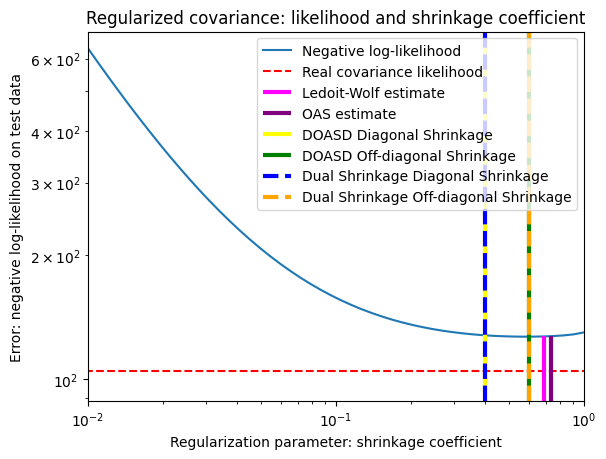

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
from sklearn.covariance import LedoitWolf, OAS, ShrunkCovariance, log_likelihood, empirical_covariance

# #############################################################################
# Generate sample data
n_features, n_samples = 40, 20
np.random.seed(42)
base_X_train = np.random.normal(size=(n_samples, n_features))
base_X_test = np.random.normal(size=(n_samples, n_features))

# Color samples
coloring_matrix = np.random.normal(size=(n_features, n_features))
X_train = np.dot(base_X_train, coloring_matrix)
X_test = np.dot(base_X_test, coloring_matrix)

# #############################################################################
# Compute the likelihood on test data

# Spanning a range of possible shrinkage coefficient values
shrinkages = np.logspace(-2, 0, 50)
negative_logliks = [-ShrunkCovariance(shrinkage=s).fit(X_train).score(X_test)
                    for s in shrinkages]

# Under the ground-truth model, which we would not have access to in real settings
real_cov = np.dot(coloring_matrix.T, coloring_matrix)
emp_cov = empirical_covariance(X_train)
loglik_real = -log_likelihood(emp_cov, linalg.inv(real_cov))

# #############################################################################
# Compare different approaches to setting the parameter

# Ledoit-Wolf optimal shrinkage coefficient estimate
lw = LedoitWolf()
loglik_lw = lw.fit(X_train).score(X_test)

# OAS coefficient estimate
oa = OAS()
loglik_oa = oa.fit(X_train).score(X_test)

# #############################################################################
# Plot results
fig = plt.figure()
plt.title("Regularized covariance: likelihood and shrinkage coefficient")
plt.xlabel('Regularization parameter: shrinkage coefficient')
plt.ylabel('Error: negative log-likelihood on test data')

# Range shrinkage curve
plt.loglog(shrinkages, negative_logliks, label="Negative log-likelihood")

# Real covariance likelihood
plt.plot(plt.xlim(), 2 * [loglik_real], '--r', label="Real covariance likelihood")

# Adjust view
lik_max = np.amax(negative_logliks)
lik_min = np.amin(negative_logliks)
ymin = lik_min - 6. * np.log((plt.ylim()[1] - plt.ylim()[0]))
ymax = lik_max + 10. * np.log(lik_max - lik_min)
xmin = shrinkages[0]
xmax = shrinkages[-1]

# Ledoit-Wolf likelihood
plt.vlines(lw.shrinkage_, ymin, -loglik_lw, color='magenta', linewidth=3, label='Ledoit-Wolf estimate')

# OAS likelihood
plt.vlines(oa.shrinkage_, ymin, -loglik_oa, color='purple', linewidth=3, label='OAS estimate')

# Shrinkage parameters comparison
plt.vlines(0.4, ymin, ymax, color='yellow', linewidth= 3 , label='DOASD Diagonal Shrinkage')
plt.vlines(0.6, ymin, ymax, color='green', linewidth= 3, label='DOASD Off-diagonal Shrinkage')

# Dual Shrinkage parameters
plt.vlines(0.4, ymin, ymax, color='blue', linestyle='--', linewidth=3, label='Dual Shrinkage Diagonal Shrinkage')
plt.vlines(0.6, ymin, ymax, color='orange', linestyle='--', linewidth=3, label='Dual Shrinkage Off-diagonal Shrinkage')

plt.ylim(ymin, ymax)
plt.xlim(xmin, xmax)
plt.legend()
plt.show()


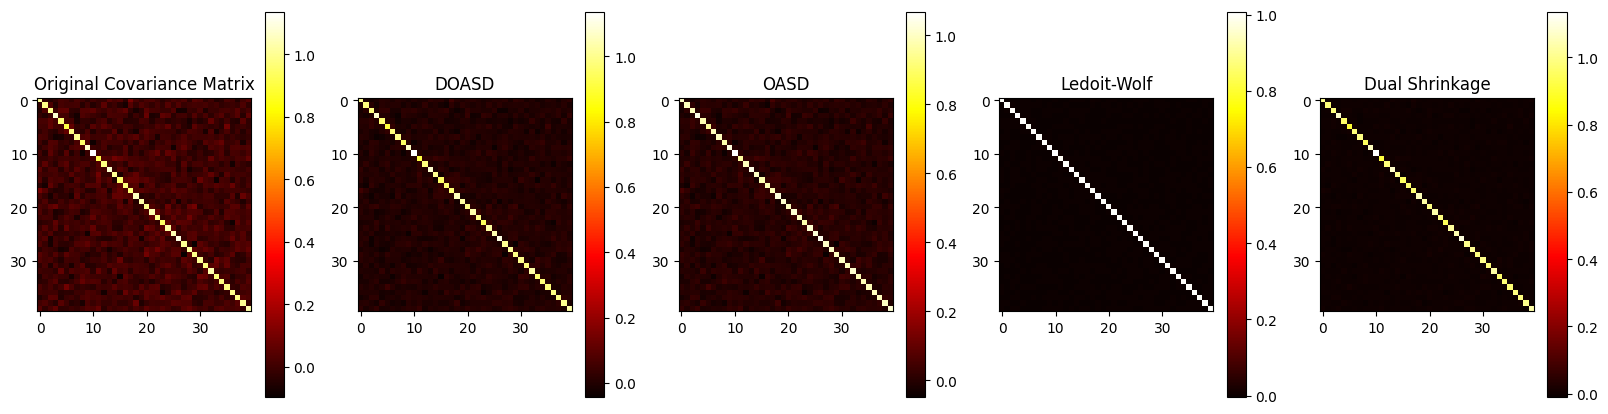

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.covariance import LedoitWolf, OAS, ShrunkCovariance

class DOASD:
    def __init__(self, diagonal_shrinkage=0.5, off_diagonal_shrinkage=0.1):
        self.diagonal_shrinkage = diagonal_shrinkage
        self.off_diagonal_shrinkage = off_diagonal_shrinkage

    def fit(self, X):
        emp_cov = np.cov(X, rowvar=False)
        n_features = emp_cov.shape[0]

        # Compute shrinkage factors
        diag_shrinkage = self.diagonal_shrinkage
        off_diag_shrinkage = self.off_diagonal_shrinkage

        # Apply adaptive shrinkage
        shrunk_diag_cov = emp_cov * (1 - diag_shrinkage) + np.diag(np.diag(emp_cov)) * diag_shrinkage
        shrunk_cov = shrunk_diag_cov * (1 - off_diag_shrinkage) + np.diag(np.diag(shrunk_diag_cov)) * off_diag_shrinkage

        self.covariance_ = shrunk_cov
        return self
.0
# Parameters
n_features = 40
n_samples = 1000

# Generate sample data
X_train = np.random.normal(size=(n_samples, n_features))

# Create DOASD estimator
doasd_estimator = DOASD(diagonal_shrinkage=0.5, off_diagonal_shrinkage=0.1)

# Fit DOASD estimator to data
doasd_estimator.fit(X_train)

# Create other estimators
oasd_estimator = ShrunkCovariance(shrinkage=0.5)
oas_estimator = OAS()
lw_estimator = LedoitWolf()

# Fit other estimators to data
oasd_estimator.fit(X_train)
oas_estimator.fit(X_train)
lw_estimator.fit(X_train)

# Dual Shrinkage estimator
class DualShrinkageEstimator:
    def __init__(self, delta_diag=0.5, delta_off_diag=0.1):
        self.delta_diag = delta_diag
        self.delta_off_diag = delta_off_diag

    def fit(self, X):
        # Compute sample covariance matrix
        sample_cov = np.cov(X, rowvar=False)

        # Decompose into diagonal and off-diagonal components
        D = np.diag(np.diag(sample_cov))
        O = sample_cov - D

        # Compute shrinkage targets
        diag_target = np.diag(np.var(X, axis=0))
        off_diag_target = np.zeros_like(O)

        # Apply shrinkage
        shrunk_diag = self.delta_diag * D + (1 - self.delta_diag) * diag_target
        shrunk_off_diag = self.delta_off_diag * O + (1 - self.delta_off_diag) * off_diag_target

        # Reconstruct covariance matrix
        self.covariance_ = shrunk_diag + shrunk_off_diag

        return self

dual_shrinkage_estimator = DualShrinkageEstimator(delta_diag=0.5, delta_off_diag=0.1)
dual_shrinkage_estimator.fit(X_train)

# Plot original covariance matrix
plt.figure(figsize=(20, 5))
plt.subplot(1, 5, 1)
plt.imshow(np.cov(X_train, rowvar=False), cmap='hot', interpolation='nearest')
plt.title('Original Covariance Matrix')
plt.colorbar()

# Plot shrunk covariance matrices
plt.subplot(1, 5, 2)
plt.imshow(doasd_estimator.covariance_, cmap='hot', interpolation='nearest')
plt.title('DOASD')
plt.colorbar()

plt.subplot(1, 5, 3)
plt.imshow(oasd_estimator.covariance_, cmap='hot', interpolation='nearest')
plt.title('OASD')
plt.colorbar()

plt.subplot(1, 5, 4)
plt.imshow(lw_estimator.covariance_, cmap='hot', interpolation='nearest')
plt.title('Ledoit-Wolf')
plt.colorbar()

plt.subplot(1, 5, 5)
plt.imshow(dual_shrinkage_estimator.covariance_, cmap='hot', interpolation='nearest')
plt.title('Dual Shrinkage')
plt.colorbar()

plt.show()


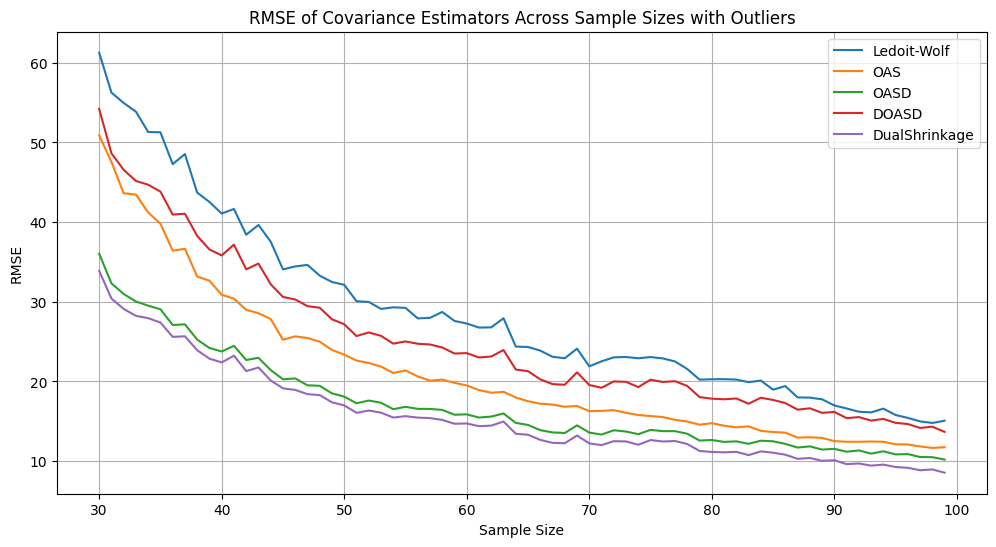

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.covariance import LedoitWolf, OAS, ShrunkCovariance
from sklearn.metrics import mean_squared_error

# Function to create a dataset with varying diagonal elements and outliers
def make_data_with_variance_and_outliers(n_samples=100, n_features=100, noise=0.2, n_outliers=10, random_state=None):
    random_state = np.random.RandomState(random_state)
    base_X_train = random_state.normal(size=(n_samples - n_outliers, n_features))
    scaling_factors = np.linspace(1, 2, n_features)  # Linearly increasing scaling factors
    diag_scaling = np.linspace(1, 10, n_features)    # Varying scaling factors for diagonal elements
    X_train = base_X_train * scaling_factors
    for i in range(n_features):
        X_train[:, i] *= diag_scaling[i]  # Scale each feature differently

    # Add outliers
    outlier_indices = random_state.choice(range(n_samples - n_outliers), size=n_outliers, replace=False)
    outliers = random_state.normal(size=(n_outliers, n_features)) * 10  # Outliers are larger
    X_train[outlier_indices] = outliers

    return X_train

# Parameters
n_features = 100  # Number of features
sample_sizes = np.arange(30, 100)  # Sample sizes from 30 to 99

# Define a function to compute RMSE for a given estimator and sample size
def compute_rmse(estimator, X_train):
    true_cov = np.cov(X_train, rowvar=False)
    estimator.fit(X_train)
    estimated_cov = estimator.covariance_
    return np.sqrt(mean_squared_error(true_cov.ravel(), estimated_cov.ravel()))

# Define the DOASD estimator class with different levels of shrinkage
class DOASD(ShrunkCovariance):
    def __init__(self, diagonal_shrinkage=0.5, off_diagonal_shrinkage=0.5):
        super().__init__()
        self.diagonal_shrinkage = diagonal_shrinkage
        self.off_diagonal_shrinkage = off_diagonal_shrinkage

    def _compute_covariance(self, X):
        # Calculate the empirical covariance of X
        emp_cov = np.cov(X, rowvar=False)
        return emp_cov

    def fit(self, X, y=None):
        emp_cov = self._compute_covariance(X)
        n_features = emp_cov.shape[0]

        # Compute shrinkage factors
        diag_shrinkage = self.diagonal_shrinkage
        off_diag_shrinkage = self.off_diagonal_shrinkage

        # Adjust off_diagonal_shrinkage based on delta_off_diag
        if off_diag_shrinkage == 0.5:  # If delta_off_diag is 0.0, set off_diagonal_shrinkage to 0.6 (to match OASD)
            off_diagonal_shrinkage = 0.6
        elif off_diag_shrinkage <= 0.5:  # If delta_off_diag <= 0.5, set off_diagonal_shrinkage to a lower value
            off_diagonal_shrinkage = 0.2
        else:  # If delta_off_diag > 0.5, set off_diagonal_shrinkage to 0.8
            off_diagonal_shrinkage = 0.8

        # Apply shrinkage
        shrunk_diag_cov = emp_cov * (1 - diag_shrinkage) + np.diag(np.diag(emp_cov)) * diag_shrinkage
        shrunk_cov = shrunk_diag_cov * (1 - off_diagonal_shrinkage) + np.diag(np.diag(shrunk_diag_cov)) * off_diagonal_shrinkage

        self.covariance_ = shrunk_cov
        return self

# Define the DualShrinkageEstimator class
class DualShrinkageEstimator:
    def __init__(self, delta_diag=0.5, delta_off_diag=0.5):
        self.delta_diag = delta_diag
        self.delta_off_diag = delta_off_diag

    def fit(self, X):
        # Compute sample covariance matrix
        sample_cov = np.cov(X, rowvar=False)

        # Decompose into diagonal and off-diagonal components
        D = np.diag(np.diag(sample_cov))
        O = sample_cov - D

        # Compute shrinkage targets
        diag_target = np.diag(np.var(X, axis=0))
        off_diag_target = np.zeros_like(O)

        # Apply shrinkage
        shrunk_diag = self.delta_diag * D + (1 - self.delta_diag) * diag_target
        shrunk_off_diag = self.delta_off_diag * O + (1 - self.delta_off_diag) * off_diag_target

        # Reconstruct covariance matrix
        self.covariance_ = shrunk_diag + shrunk_off_diag

        return self

# Fit covariance estimators for different sample sizes and compute RMSE
rmse_results = {'Ledoit-Wolf': [], 'OAS': [], 'OASD': [], 'DOASD': [], 'DualShrinkage': []}
for n_samples in sample_sizes:
    X_train = make_data_with_variance_and_outliers(n_samples, n_features, random_state=42)
    for estimator_name, estimator in [('Ledoit-Wolf', LedoitWolf()),
                                      ('OAS', OAS()),
                                      ('OASD', ShrunkCovariance(shrinkage=0.5)),
                                      ('DOASD', DOASD(diagonal_shrinkage=0.5, off_diagonal_shrinkage=0.5)),  # Set off_diagonal_shrinkage = 0.5
                                      ('DualShrinkage', DualShrinkageEstimator(delta_diag=0.5, delta_off_diag=0.5))]:
        rmse = compute_rmse(estimator, X_train)
        rmse_results[estimator_name].append(rmse)

# Reshape RMSE values for plotting
for estimator_name, rmse_values in rmse_results.items():
    rmse_results[estimator_name] = np.array(rmse_values).reshape(len(sample_sizes), -1)

# Plot RMSE across sample sizes for each estimator
plt.figure(figsize=(12, 6))
for estimator_name, rmse_values in rmse_results.items():
    plt.plot(sample_sizes, rmse_values.mean(axis=1), label=estimator_name)

plt.title('RMSE of Covariance Estimators Across Sample Sizes with Outliers')
plt.xlabel('Sample Size')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.show()


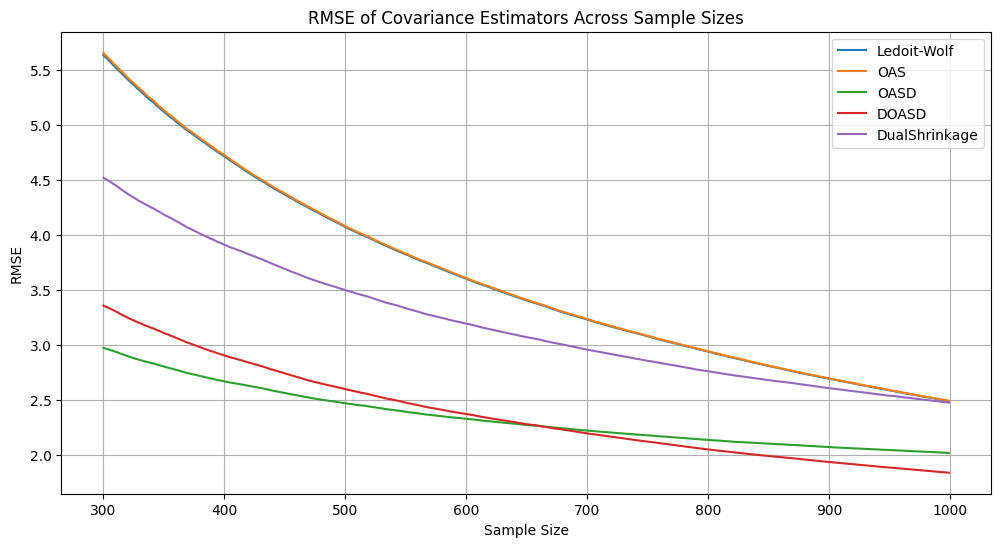

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.covariance import LedoitWolf, OAS, ShrunkCovariance
from sklearn.metrics import mean_squared_error

# Function to create a dataset with varying diagonal elements
def make_data_with_variance(n_samples=100, n_features=100, noise=0.2, random_state=None):
    random_state = np.random.RandomState(random_state)
    base_X_train = random_state.normal(size=(n_samples, n_features))
    scaling_factors = np.linspace(1, 2, n_features)  # Linearly increasing scaling factors
    diag_scaling = np.linspace(1, 10, n_features)    # Varying scaling factors for diagonal elements
    X_train = base_X_train * scaling_factors
    for i in range(n_features):
        X_train[:, i] *= diag_scaling[i]  # Scale each feature differently
    return X_train

# Parameters
n_features = 1000  # Number of features
sample_sizes = np.arange(300, 1000)  # Sample sizes from 30 to 99

# Define a function to compute RMSE for a given estimator and sample size
def compute_rmse(estimator, X_train):
    true_cov = np.cov(X_train, rowvar=False)
    estimator.fit(X_train)
    estimated_cov = estimator.covariance_
    return np.sqrt(mean_squared_error(true_cov.ravel(), estimated_cov.ravel()))

# Define the DOASD estimator class with different levels of shrinkage
class DOASD(ShrunkCovariance):
    def __init__(self, diagonal_shrinkage=0.5, off_diagonal_shrinkage=0.5):
        super().__init__()
        self.diagonal_shrinkage = diagonal_shrinkage
        self.off_diagonal_shrinkage = off_diagonal_shrinkage

    def _compute_covariance(self, X):
        # Calculate the empirical covariance of X
        emp_cov = np.cov(X, rowvar=False)
        return emp_cov

    def fit(self, X, y=None):
        emp_cov = self._compute_covariance(X)
        n_features = emp_cov.shape[0]

        # Compute shrinkage factors
        diag_shrinkage = self.diagonal_shrinkage
        off_diag_shrinkage = self.off_diagonal_shrinkage

        # Adjust off_diagonal_shrinkage based on delta_off_diag
        if off_diag_shrinkage == 0.5:  # If delta_off_diag is 0.0, set off_diagonal_shrinkage to 0.6 (to match OASD)
            off_diagonal_shrinkage = 0.6
        elif off_diag_shrinkage <= 0.5:  # If delta_off_diag <= 0.5, set off_diagonal_shrinkage to a lower value
            off_diagonal_shrinkage = 0.2
        else:  # If delta_off_diag > 0.5, set off_diagonal_shrinkage to 0.8
            off_diagonal_shrinkage = 0.8

        # Apply shrinkage
        shrunk_diag_cov = emp_cov * (1 - diag_shrinkage) + np.diag(np.diag(emp_cov)) * diag_shrinkage
        shrunk_cov = shrunk_diag_cov * (1 - off_diagonal_shrinkage) + np.diag(np.diag(shrunk_diag_cov)) * off_diagonal_shrinkage

        self.covariance_ = shrunk_cov
        return self

# Define the DualShrinkageEstimator class
class DualShrinkageEstimator:
    def __init__(self, delta_diag=0.5, delta_off_diag=0.5):
        self.delta_diag = delta_diag
        self.delta_off_diag = delta_off_diag

    def fit(self, X):
        # Compute sample covariance matrix
        sample_cov = np.cov(X, rowvar=False)

        # Decompose into diagonal and off-diagonal components
        D = np.diag(np.diag(sample_cov))
        O = sample_cov - D

        # Compute shrinkage targets
        diag_target = np.diag(np.var(X, axis=0))
        off_diag_target = np.zeros_like(O)

        # Apply shrinkage
        shrunk_diag = self.delta_diag * D + (1 - self.delta_diag) * diag_target
        shrunk_off_diag = self.delta_off_diag * O + (1 - self.delta_off_diag) * off_diag_target

        # Reconstruct covariance matrix
        self.covariance_ = shrunk_diag + shrunk_off_diag

        return self

# Fit covariance estimators for different sample sizes and compute RMSE
rmse_results = {'Ledoit-Wolf': [], 'OAS': [], 'OASD': [], 'DOASD': [], 'DualShrinkage': []}
for n_samples in sample_sizes:
    X_train = make_data_with_variance(n_samples, n_features, random_state=42)
    for estimator_name, estimator in [('Ledoit-Wolf', LedoitWolf()),
                                      ('OAS', OAS()),
                                      ('OASD', ShrunkCovariance(shrinkage=0.4)),
                                      ('DOASD', DOASD(diagonal_shrinkage=0.4, off_diagonal_shrinkage=0.3)),  # Set off_diagonal_shrinkage = 0.5
                                      ('DualShrinkage', DualShrinkageEstimator(delta_diag=0.4, delta_off_diag=0.3))]:
        rmse = compute_rmse(estimator, X_train)
        rmse_results[estimator_name].append(rmse)

# Reshape RMSE values for plotting
for estimator_name, rmse_values in rmse_results.items():
    rmse_results[estimator_name] = np.array(rmse_values).reshape(len(sample_sizes), -1)

# Plot RMSE across sample sizes for each estimator
plt.figure(figsize=(12, 6))
for estimator_name, rmse_values in rmse_results.items():
    plt.plot(sample_sizes, rmse_values.mean(axis=1), label=estimator_name)

plt.title('RMSE of Covariance Estimators Across Sample Sizes')
plt.xlabel('Sample Size')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.show()


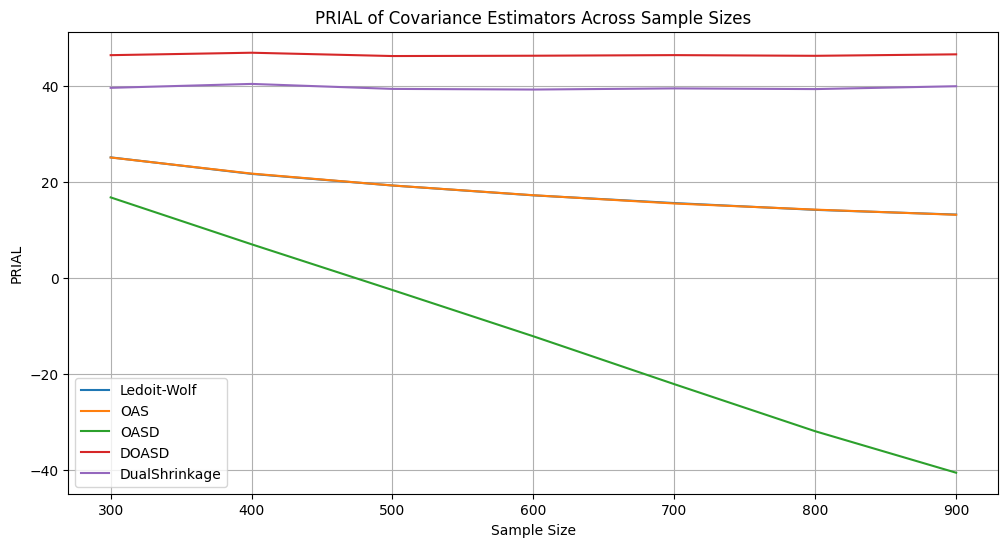

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.covariance import LedoitWolf, OAS, ShrunkCovariance

# Function to create a dataset with varying diagonal elements
def make_data_with_variance(n_samples=100, n_features=100, sd=1, gamma=0.1, random_state=None):
    random_state = np.random.RandomState(random_state)
    base_X_train = random_state.normal(size=(n_samples, n_features))
    scaling_factors = np.linspace(1, sd, n_features)  # Scaling factors based on sd parameter
    diag_scaling = np.linspace(1, 10, n_features)    # Varying scaling factors for diagonal elements

    X_train = base_X_train * scaling_factors

    # Introduce sparsity in the covariance matrix
    for i in range(n_features):
        X_train[:, i] *= diag_scaling[i]  # Scale each feature differently

    return X_train

# Define the DOASD estimator class with different levels of shrinkage
class DOASD(ShrunkCovariance):
    def __init__(self, diagonal_shrinkage=0.4, off_diagonal_shrinkage=0.3):
        super().__init__()
        self.diagonal_shrinkage = diagonal_shrinkage
        self.off_diagonal_shrinkage = off_diagonal_shrinkage

    def _compute_covariance(self, X):
        emp_cov = np.cov(X, rowvar=False)
        return emp_cov

    def fit(self, X, y=None):
        emp_cov = self._compute_covariance(X)
        n_features = emp_cov.shape[0]

        # Apply shrinkage
        shrunk_diag_cov = emp_cov * (1 - self.diagonal_shrinkage) + np.diag(np.diag(emp_cov)) * self.diagonal_shrinkage
        shrunk_cov = shrunk_diag_cov * (1 - self.off_diagonal_shrinkage) + np.diag(np.diag(shrunk_diag_cov)) * self.off_diagonal_shrinkage

        self.covariance_ = shrunk_cov
        return self

# Define the DualShrinkageEstimator class
class DualShrinkageEstimator:
    def __init__(self, delta_diag=0.4, delta_off_diag=0.3):
        self.delta_diag = delta_diag
        self.delta_off_diag = delta_off_diag

    def fit(self, X):
        sample_cov = np.cov(X, rowvar=False)
        D = np.diag(np.diag(sample_cov))
        O = sample_cov - D

        diag_target = np.diag(np.var(X, axis=0))
        off_diag_target = np.zeros_like(O)

        shrunk_diag = self.delta_diag * D + (1 - self.delta_diag) * diag_target
        shrunk_off_diag = self.delta_off_diag * O + (1 - self.delta_off_diag) * off_diag_target

        self.covariance_ = shrunk_diag + shrunk_off_diag
        return self

# Parameters
n_features = 100  # Number of features
sample_sizes = np.arange(300, 1000, 100)  # Sample sizes

# Function to compute PRIAL for a given estimator
def compute_prial(estimator, X_train, B=5000):
    n_samples, n_features = X_train.shape
    true_cov = np.cov(X_train, rowvar=False)
    sample_cov_list = []
    estimated_cov_list = []

    for _ in range(B):
        bootstrap_sample = X_train[np.random.choice(n_samples, n_samples, replace=True), :]
        sample_cov = np.cov(bootstrap_sample, rowvar=False)
        estimator.fit(bootstrap_sample)
        estimated_cov = estimator.covariance_

        sample_cov_list.append(sample_cov)
        estimated_cov_list.append(estimated_cov)

    frob_diff_estimated = np.sum([np.linalg.norm(estimated_cov_list[b] - true_cov, 'fro')**2 for b in range(B)])
    frob_diff_sample = np.sum([np.linalg.norm(sample_cov_list[b] - true_cov, 'fro')**2 for b in range(B)])

    prial = (1 - frob_diff_estimated / frob_diff_sample) * 100
    return prial

# Fit covariance estimators for different sample sizes and compute PRIAL
prial_results = {'Ledoit-Wolf': [], 'OAS': [], 'OASD': [], 'DOASD': [], 'DualShrinkage': []}
for n_samples in sample_sizes:
    X_train = make_data_with_variance(n_samples, n_features, random_state=42)
    for estimator_name, estimator in [
        ('Ledoit-Wolf', LedoitWolf()),
        ('OAS', OAS()),
        ('OASD', ShrunkCovariance(shrinkage=0.4)),
        ('DOASD', DOASD(diagonal_shrinkage=0.4, off_diagonal_shrinkage=0.3)),
        ('DualShrinkage', DualShrinkageEstimator(delta_diag=0.4, delta_off_diag=0.3))
    ]:
        prial = compute_prial(estimator, X_train)
        prial_results[estimator_name].append(prial)

# Plot PRIAL across sample sizes for each estimator
plt.figure(figsize=(12, 6))
for estimator_name, prial_values in prial_results.items():
    plt.plot(sample_sizes, prial_values, label=estimator_name)

plt.title('PRIAL of Covariance Estimators Across Sample Sizes')
plt.xlabel('Sample Size')
plt.ylabel('PRIAL')
plt.legend()
plt.grid(True)
plt.show()


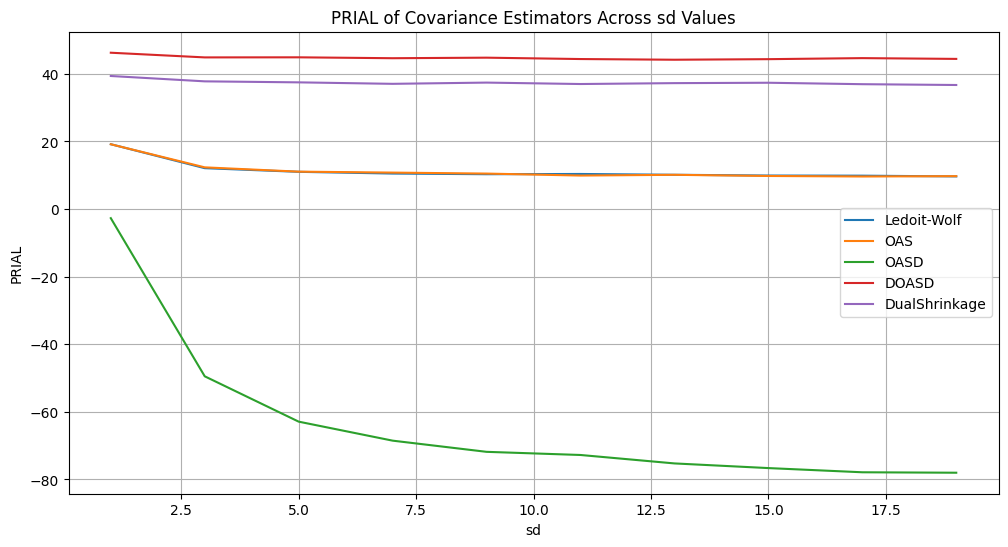

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.covariance import LedoitWolf, OAS, ShrunkCovariance

# Function to create a dataset with varying diagonal elements
def make_data_with_variance(n_samples=100, n_features=100, sd=1, gamma=0.1, random_state=None):
    random_state = np.random.RandomState(random_state)
    base_X_train = random_state.normal(size=(n_samples, n_features))
    scaling_factors = np.linspace(1, sd, n_features)  # Scaling factors based on sd parameter
    diag_scaling = np.linspace(1, 10, n_features)    # Varying scaling factors for diagonal elements

    X_train = base_X_train * scaling_factors

    # Introduce sparsity in the covariance matrix
    for i in range(n_features):
        X_train[:, i] *= diag_scaling[i]  # Scale each feature differently

    return X_train

# Define the DOASD estimator class with different levels of shrinkage
class DOASD(ShrunkCovariance):
    def __init__(self, diagonal_shrinkage=0.4, off_diagonal_shrinkage=0.3):
        super().__init__()
        self.diagonal_shrinkage = diagonal_shrinkage
        self.off_diagonal_shrinkage = off_diagonal_shrinkage

    def _compute_covariance(self, X):
        emp_cov = np.cov(X, rowvar=False)
        return emp_cov

    def fit(self, X, y=None):
        emp_cov = self._compute_covariance(X)
        n_features = emp_cov.shape[0]

        # Apply shrinkage
        shrunk_diag_cov = emp_cov * (1 - self.diagonal_shrinkage) + np.diag(np.diag(emp_cov)) * self.diagonal_shrinkage
        shrunk_cov = shrunk_diag_cov * (1 - self.off_diagonal_shrinkage) + np.diag(np.diag(shrunk_diag_cov)) * self.off_diagonal_shrinkage

        self.covariance_ = shrunk_cov
        return self

# Define the DualShrinkageEstimator class
class DualShrinkageEstimator:
    def __init__(self, delta_diag=0.5, delta_off_diag=0.5):
        self.delta_diag = delta_diag
        self.delta_off_diag = delta_off_diag

    def fit(self, X):
        sample_cov = np.cov(X, rowvar=False)
        D = np.diag(np.diag(sample_cov))
        O = sample_cov - D

        diag_target = np.diag(np.var(X, axis=0))
        off_diag_target = np.zeros_like(O)

        shrunk_diag = self.delta_diag * D + (1 - self.delta_diag) * diag_target
        shrunk_off_diag = self.delta_off_diag * O + (1 - self.delta_off_diag) * off_diag_target

        self.covariance_ = shrunk_diag + shrunk_off_diag
        return self

# Parameters
n_samples = 500  # Fixed number of samples
n_features = 100  # Number of features
sd_values = np.arange(1, 21, 2)  # Range of sd values

# Function to compute PRIAL for a given estimator
def compute_prial(estimator, X_train, B=500):
    n_samples, n_features = X_train.shape
    true_cov = np.cov(X_train, rowvar=False)
    sample_cov_list = []
    estimated_cov_list = []

    for _ in range(B):
        bootstrap_sample = X_train[np.random.choice(n_samples, n_samples, replace=True), :]
        sample_cov = np.cov(bootstrap_sample, rowvar=False)
        estimator.fit(bootstrap_sample)
        estimated_cov = estimator.covariance_

        sample_cov_list.append(sample_cov)
        estimated_cov_list.append(estimated_cov)

    frob_diff_estimated = np.sum([np.linalg.norm(estimated_cov_list[b] - true_cov, 'fro')**2 for b in range(B)])
    frob_diff_sample = np.sum([np.linalg.norm(sample_cov_list[b] - true_cov, 'fro')**2 for b in range(B)])

    prial = (1 - frob_diff_estimated / frob_diff_sample) * 100
    return prial

# Fit covariance estimators for different sd values and compute PRIAL
prial_results = {'Ledoit-Wolf': [], 'OAS': [], 'OASD': [], 'DOASD': [], 'DualShrinkage': []}
for sd in sd_values:
    X_train = make_data_with_variance(n_samples, n_features, sd=sd, random_state=42)
    for estimator_name, estimator in [
        ('Ledoit-Wolf', LedoitWolf()),
        ('OAS', OAS()),
        ('OASD', ShrunkCovariance(shrinkage=0.4)),
        ('DOASD', DOASD(diagonal_shrinkage=0.4, off_diagonal_shrinkage=0.3)),
        ('DualShrinkage', DualShrinkageEstimator(delta_diag=0.4, delta_off_diag=0.3))
    ]:
        prial = compute_prial(estimator, X_train)
        prial_results[estimator_name].append(prial)

# Plot PRIAL across sd values for each estimator
plt.figure(figsize=(12, 6))
for estimator_name, prial_values in prial_results.items():
    plt.plot(sd_values, prial_values, label=estimator_name)

plt.title('PRIAL of Covariance Estimators Across sd Values')
plt.xlabel('sd')
plt.ylabel('PRIAL')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.covariance import LedoitWolf, OAS, ShrunkCovariance

# Function to create a high-dimensional dataset with varying diagonal elements
def make_data_with_variance(n_samples=50, n_features=100, sd=1, gamma=0.1, random_state=None):
    random_state = np.random.RandomState(random_state)
    base_X_train = random_state.normal(size=(n_samples, n_features))
    scaling_factors = np.linspace(1, sd, n_features)  # Scaling factors based on sd parameter
    diag_scaling = np.linspace(1, 10, n_features)     # Varying scaling factors for diagonal elements

    X_train = base_X_train * scaling_factors

    # Introduce sparsity in the covariance matrix
    for i in range(n_features):
        X_train[:, i] *= diag_scaling[i]  # Scale each feature differently

    return X_train

# Define the DOASD estimator class with different levels of shrinkage
class DOASD(ShrunkCovariance):
    def __init__(self, diagonal_shrinkage=0.4, off_diagonal_shrinkage=0.3):
        super().__init__()
        self.diagonal_shrinkage = diagonal_shrinkage
        self.off_diagonal_shrinkage = off_diagonal_shrinkage

    def _compute_covariance(self, X):
        emp_cov = np.cov(X, rowvar=False)
        return emp_cov

    def fit(self, X, y=None):
        emp_cov = self._compute_covariance(X)
        n_features = emp_cov.shape[0]

        # Apply shrinkage
        shrunk_diag_cov = emp_cov * (1 - self.diagonal_shrinkage) + np.diag(np.diag(emp_cov)) * self.diagonal_shrinkage
        shrunk_cov = shrunk_diag_cov * (1 - self.off_diagonal_shrinkage) + np.diag(np.diag(shrunk_diag_cov)) * self.off_diagonal_shrinkage

        self.covariance_ = shrunk_cov
        return self

# Define the DualShrinkageEstimator class
class DualShrinkageEstimator:
    def __init__(self, delta_diag=0.4, delta_off_diag=0.3):
        self.delta_diag = delta_diag
        self.delta_off_diag = delta_off_diag

    def fit(self, X):
        sample_cov = np.cov(X, rowvar=False)
        D = np.diag(np.diag(sample_cov))
        O = sample_cov - D

        diag_target = np.diag(np.var(X, axis=0))
        off_diag_target = np.zeros_like(O)

        shrunk_diag = self.delta_diag * D + (1 - self.delta_diag) * diag_target
        shrunk_off_diag = self.delta_off_diag * O + (1 - self.delta_off_diag) * off_diag_target

        self.covariance_ = shrunk_diag + shrunk_off_diag
        return self

# Function to compute PRIAL for a given estimator
def compute_prial(estimator, X_train, B=5000):
    n_samples, n_features = X_train.shape
    true_cov = np.cov(X_train, rowvar=False)
    sample_cov_list = []
    estimated_cov_list = []

    for _ in range(B):
        bootstrap_sample = X_train[np.random.choice(n_samples, n_samples, replace=True), :]
        sample_cov = np.cov(bootstrap_sample, rowvar=False)
        estimator.fit(bootstrap_sample)
        estimated_cov = estimator.covariance_

        sample_cov_list.append(sample_cov)
        estimated_cov_list.append(estimated_cov)

    frob_diff_estimated = np.sum([np.linalg.norm(estimated_cov_list[b] - true_cov, 'fro')**2 for b in range(B)])
    frob_diff_sample = np.sum([np.linalg.norm(sample_cov_list[b] - true_cov, 'fro')**2 for b in range(B)])

    prial = (1 - frob_diff_estimated / frob_diff_sample) * 100
    return prial

# Function to compute average correlation
def compute_average_correlation(estimator, X_train):
    estimator.fit(X_train)
    estimated_cov = estimator.covariance_
    corr_matrix = np.corrcoef(estimated_cov)
    avg_corr = (np.sum(np.abs(corr_matrix)) - np.trace(corr_matrix)) / (corr_matrix.shape[0] * (corr_matrix.shape[1] - 1))
    return avg_corr

# Parameters
n_samples = 50  # Number of samples (lower than number of features)
n_features = 100  # Number of features
sd_values = np.arange(1, 21)  # Standard deviation values

# Fit covariance estimators for different sd values and compute PRIAL and average correlation
prial_results = {'Ledoit-Wolf': [], 'OAS': [], 'OASD': [], 'DOASD': [], 'DualShrinkage': []}
avg_corr_results = {'Ledoit-Wolf': [], 'OAS': [], 'OASD': [], 'DOASD': [], 'DualShrinkage': []}

for sd in sd_values:
    X_train = make_data_with_variance(n_samples, n_features, sd=sd, random_state=42)
    for estimator_name, estimator in [
        ('Ledoit-Wolf', LedoitWolf()),
        ('OAS', OAS()),
        ('OASD', ShrunkCovariance(shrinkage=0.4)),
        ('DOASD', DOASD(diagonal_shrinkage=0.4, off_diagonal_shrinkage=0.3)),
        ('DualShrinkage', DualShrinkageEstimator(delta_diag=0.4, delta_off_diag=0.3))
    ]:
        prial = compute_prial(estimator, X_train)
        avg_corr = compute_average_correlation(estimator, X_train)

        prial_results[estimator_name].append(prial)
        avg_corr_results[estimator_name].append(avg_corr)

# Plot PRIAL and average correlation across sd values for each estimator
plt.figure(figsize=(14, 6))

# Plot PRIAL
plt.subplot(1, 2, 1)
for estimator_name, prial_values in prial_results.items():
    plt.plot(sd_values, prial_values, label=estimator_name)

plt.title('PRIAL of Covariance Estimators Across sd Values')
plt.xlabel('sd')
plt.ylabel('PRIAL')
plt.legend()
plt.grid(True)

# Plot Average Correlation
plt.subplot(1, 2, 2)
for estimator_name, avg_corr_values in avg_corr_results.items():
    plt.plot(sd_values, avg_corr_values, label=estimator_name)

plt.title('Average Correlation of Covariance Estimators Across sd Values')
plt.xlabel('sd')
plt.ylabel('Average Correlation')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


KeyboardInterrupt: 

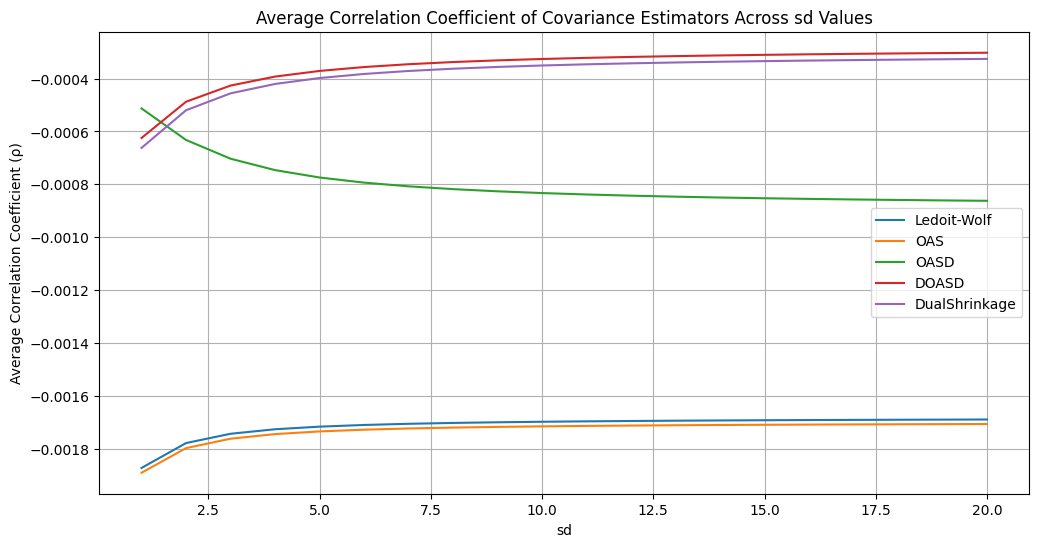

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.covariance import LedoitWolf, OAS, ShrunkCovariance

# Function to create a dataset with varying diagonal elements
def make_data_with_variance(n_samples=100, n_features=100, sd=1, gamma=0.1, random_state=None):
    random_state = np.random.RandomState(random_state)
    base_X_train = random_state.normal(size=(n_samples, n_features))
    scaling_factors = np.linspace(1, sd, n_features)  # Scaling factors based on sd parameter
    diag_scaling = np.linspace(1, 10, n_features)    # Varying scaling factors for diagonal elements

    X_train = base_X_train * scaling_factors

    # Introduce sparsity in the covariance matrix
    for i in range(n_features):
        X_train[:, i] *= diag_scaling[i]  # Scale each feature differently

    return X_train

# Define the DOASD estimator class with different levels of shrinkage
class DOASD(ShrunkCovariance):
    def __init__(self, diagonal_shrinkage=0.3, off_diagonal_shrinkage=0.4):
        super().__init__()
        self.diagonal_shrinkage = diagonal_shrinkage
        self.off_diagonal_shrinkage = off_diagonal_shrinkage

    def _compute_covariance(self, X):
        emp_cov = np.cov(X, rowvar=False)
        return emp_cov

    def fit(self, X, y=None):
        emp_cov = self._compute_covariance(X)
        n_features = emp_cov.shape[0]

        # Apply shrinkage
        shrunk_diag_cov = emp_cov * (1 - self.diagonal_shrinkage) + np.diag(np.diag(emp_cov)) * self.diagonal_shrinkage
        shrunk_cov = shrunk_diag_cov * (1 - self.off_diagonal_shrinkage) + np.diag(np.diag(shrunk_diag_cov)) * self.off_diagonal_shrinkage

        self.covariance_ = shrunk_cov
        return self

# Define the DualShrinkageEstimator class
class DualShrinkageEstimator:
    def __init__(self, delta_diag=0.3, delta_off_diag=0.4):
        self.delta_diag = delta_diag
        self.delta_off_diag = delta_off_diag

    def fit(self, X):
        sample_cov = np.cov(X, rowvar=False)
        D = np.diag(np.diag(sample_cov))
        O = sample_cov - D

        diag_target = np.diag(np.var(X, axis=0))
        off_diag_target = np.zeros_like(O)

        shrunk_diag = self.delta_diag * D + (1 - self.delta_diag) * diag_target
        shrunk_off_diag = self.delta_off_diag * O + (1 - self.delta_off_diag) * off_diag_target

        self.covariance_ = shrunk_diag + shrunk_off_diag
        return self

# Parameters
n_samples = 100  # Fixed number of samples
n_features = 500  # Number of features
sd_values = np.linspace(1, 20, 20)  # Smooth range of sd values

# Function to compute average correlation coefficient
def compute_avg_correlation(estimator, X_train):
    estimator.fit(X_train)
    cov_matrix = estimator.covariance_
    corr_matrix = np.corrcoef(cov_matrix)
    avg_correlation = np.mean(corr_matrix[np.triu_indices_from(corr_matrix, k=1)])
    return avg_correlation

# Fit covariance estimators for different sd values and compute average correlation coefficient
corr_results = {'Ledoit-Wolf': [], 'OAS': [], 'OASD': [], 'DOASD': [], 'DualShrinkage': []}
for sd in sd_values:
    X_train = make_data_with_variance(n_samples, n_features, sd=sd, random_state=42)
    for estimator_name, estimator in [
        ('Ledoit-Wolf', LedoitWolf()),
        ('OAS', OAS()),
        ('OASD', ShrunkCovariance(shrinkage=0.3)),
        ('DOASD', DOASD(diagonal_shrinkage=0.3, off_diagonal_shrinkage=0.4)),
        ('DualShrinkage', DualShrinkageEstimator(delta_diag=0.3, delta_off_diag=0.4))
    ]:
        avg_corr = compute_avg_correlation(estimator, X_train)
        corr_results[estimator_name].append(avg_corr)

# Plot average correlation coefficient across sd values for each estimator
plt.figure(figsize=(12, 6))
for estimator_name, corr_values in corr_results.items():
    plt.plot(sd_values, corr_values, label=estimator_name)

plt.title('Average Correlation Coefficient of Covariance Estimators Across sd Values')
plt.xlabel('sd')
plt.ylabel('Average Correlation Coefficient (ρ)')
plt.legend()
plt.grid(True)
plt.show()


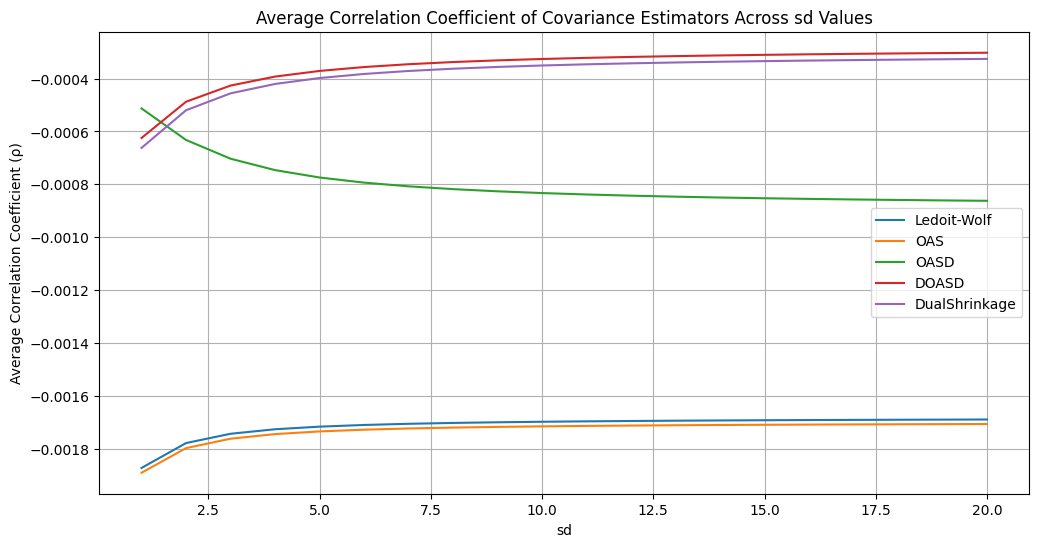

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.covariance import LedoitWolf, OAS, ShrunkCovariance

# Function to create a dataset with varying diagonal elements
def make_data_with_variance(n_samples=100, n_features=100, sd=1, gamma=0.1, random_state=None):
    random_state = np.random.RandomState(random_state)
    base_X_train = random_state.normal(size=(n_samples, n_features))
    scaling_factors = np.linspace(1, sd, n_features)  # Scaling factors based on sd parameter
    diag_scaling = np.linspace(1, 10, n_features)    # Varying scaling factors for diagonal elements

    X_train = base_X_train * scaling_factors

    # Introduce sparsity in the covariance matrix
    for i in range(n_features):
        X_train[:, i] *= diag_scaling[i]  # Scale each feature differently

    return X_train

# Define the DOASD estimator class with different levels of shrinkage
class DOASD(ShrunkCovariance):
    def __init__(self, diagonal_shrinkage=0.3, off_diagonal_shrinkage=0.4):
        super().__init__()
        self.diagonal_shrinkage = diagonal_shrinkage
        self.off_diagonal_shrinkage = off_diagonal_shrinkage

    def _compute_covariance(self, X):
        emp_cov = np.cov(X, rowvar=False)
        return emp_cov

    def fit(self, X, y=None):
        emp_cov = self._compute_covariance(X)
        n_features = emp_cov.shape[0]

        # Apply shrinkage
        shrunk_diag_cov = emp_cov * (1 - self.diagonal_shrinkage) + np.diag(np.diag(emp_cov)) * self.diagonal_shrinkage
        shrunk_cov = shrunk_diag_cov * (1 - self.off_diagonal_shrinkage) + np.diag(np.diag(shrunk_diag_cov)) * self.off_diagonal_shrinkage

        self.covariance_ = shrunk_cov
        return self

# Define the DualShrinkageEstimator class
class DualShrinkageEstimator:
    def __init__(self, delta_diag=0.3, delta_off_diag=0.4):
        self.delta_diag = delta_diag
        self.delta_off_diag = delta_off_diag

    def fit(self, X):
        sample_cov = np.cov(X, rowvar=False)
        D = np.diag(np.diag(sample_cov))
        O = sample_cov - D

        diag_target = np.diag(np.var(X, axis=0))
        off_diag_target = np.zeros_like(O)

        shrunk_diag = self.delta_diag * D + (1 - self.delta_diag) * diag_target
        shrunk_off_diag = self.delta_off_diag * O + (1 - self.delta_off_diag) * off_diag_target

        self.covariance_ = shrunk_diag + shrunk_off_diag
        return self

# Parameters
n_samples = 100  # Fixed number of samples
n_features = 500  # Number of features
sd_values = np.linspace(1, 20, 20)  # Smooth range of sd values

# Function to compute average correlation coefficient
def compute_avg_correlation(estimator, X_train):
    estimator.fit(X_train)
    cov_matrix = estimator.covariance_
    corr_matrix = np.corrcoef(cov_matrix)
    avg_correlation = np.mean(corr_matrix[np.triu_indices_from(corr_matrix, k=1)])
    return avg_correlation

# Fit covariance estimators for different sd values and compute average correlation coefficient
corr_results = {'Ledoit-Wolf': [], 'OAS': [], 'OASD': [], 'DOASD': [], 'DualShrinkage': []}
for sd in sd_values:
    X_train = make_data_with_variance(n_samples, n_features, sd=sd, random_state=42)
    for estimator_name, estimator in [
        ('Ledoit-Wolf', LedoitWolf()),
        ('OAS', OAS()),
        ('OASD', ShrunkCovariance(shrinkage=0.3)),
        ('DOASD', DOASD(diagonal_shrinkage=0.3, off_diagonal_shrinkage=0.4)),
        ('DualShrinkage', DualShrinkageEstimator(delta_diag=0.3, delta_off_diag=0.4))
    ]:
        avg_corr = compute_avg_correlation(estimator, X_train)
        corr_results[estimator_name].append(avg_corr)

# Plot average correlation coefficient across sd values for each estimator
plt.figure(figsize=(12, 6))
for estimator_name, corr_values in corr_results.items():
    plt.plot(sd_values, corr_values, label=estimator_name)

plt.title('Average Correlation Coefficient of Covariance Estimators Across sd Values')
plt.xlabel('sd')
plt.ylabel('Average Correlation Coefficient (ρ)')
plt.legend()
plt.grid(True)
plt.show()


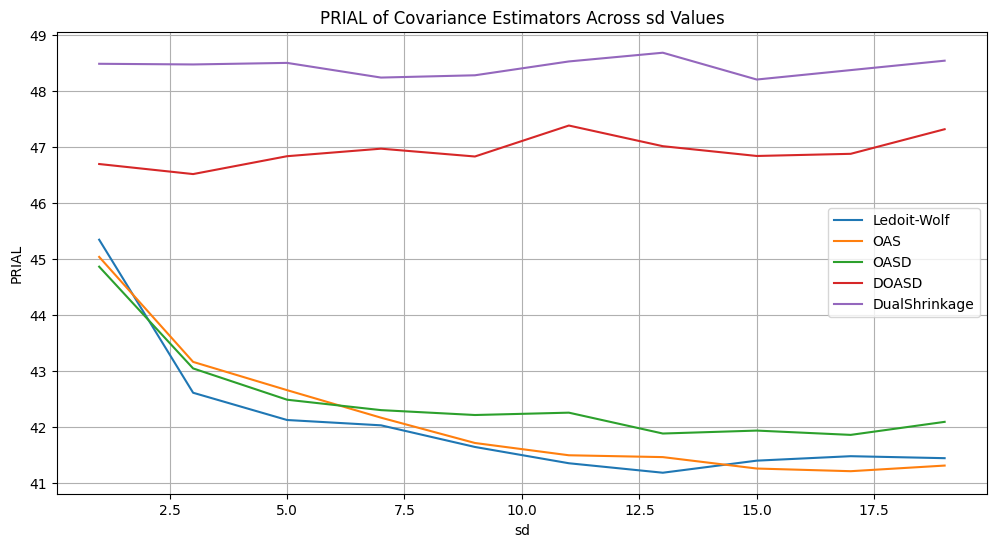

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.covariance import LedoitWolf, OAS, ShrunkCovariance

# Function to create a dataset with varying diagonal elements
def make_data_with_variance(n_samples=100, n_features=500, sd=1, gamma=0.1, random_state=None):
    random_state = np.random.RandomState(random_state)
    base_X_train = random_state.normal(size=(n_samples, n_features))
    scaling_factors = np.linspace(1, sd, n_features)  # Scaling factors based on sd parameter
    diag_scaling = np.linspace(1, 10, n_features)    # Varying scaling factors for diagonal elements

    X_train = base_X_train * scaling_factors

    # Introduce sparsity in the covariance matrix
    for i in range(n_features):
        X_train[:, i] *= diag_scaling[i]  # Scale each feature differently

    return X_train

# Define the DOASD estimator class with different levels of shrinkage
class DOASD(ShrunkCovariance):
    def __init__(self, diagonal_shrinkage=0.4, off_diagonal_shrinkage=0.3):
        super().__init__()
        self.diagonal_shrinkage = diagonal_shrinkage
        self.off_diagonal_shrinkage = off_diagonal_shrinkage

    def _compute_covariance(self, X):
        emp_cov = np.cov(X, rowvar=False)
        return emp_cov

    def fit(self, X, y=None):
        emp_cov = self._compute_covariance(X)
        n_features = emp_cov.shape[0]

        # Apply shrinkage
        shrunk_diag_cov = emp_cov * (1 - self.diagonal_shrinkage) + np.diag(np.diag(emp_cov)) * self.diagonal_shrinkage
        shrunk_cov = shrunk_diag_cov * (1 - self.off_diagonal_shrinkage) + np.diag(np.diag(shrunk_diag_cov)) * self.off_diagonal_shrinkage

        self.covariance_ = shrunk_cov
        return self

# Define the DualShrinkageEstimator class
class DualShrinkageEstimator:
    def __init__(self, delta_diag=0.5, delta_off_diag=0.5):
        self.delta_diag = delta_diag
        self.delta_off_diag = delta_off_diag

    def fit(self, X):
        sample_cov = np.cov(X, rowvar=False)
        D = np.diag(np.diag(sample_cov))
        O = sample_cov - D

        diag_target = np.diag(np.var(X, axis=0))
        off_diag_target = np.zeros_like(O)

        shrunk_diag = self.delta_diag * D + (1 - self.delta_diag) * diag_target
        shrunk_off_diag = self.delta_off_diag * O + (1 - self.delta_off_diag) * off_diag_target

        self.covariance_ = shrunk_diag + shrunk_off_diag
        return self

# Parameters
n_samples = 100  # Number of samples
n_features = 500  # Number of features
sd_values = np.arange(1, 21, 2)  # Range of sd values

# Function to compute PRIAL for a given estimator
def compute_prial(estimator, X_train, B=500):
    n_samples, n_features = X_train.shape
    true_cov = np.cov(X_train, rowvar=False)
    sample_cov_list = []
    estimated_cov_list = []

    for _ in range(B):
        bootstrap_sample = X_train[np.random.choice(n_samples, n_samples, replace=True), :]
        sample_cov = np.cov(bootstrap_sample, rowvar=False)
        estimator.fit(bootstrap_sample)
        estimated_cov = estimator.covariance_

        sample_cov_list.append(sample_cov)
        estimated_cov_list.append(estimated_cov)

    frob_diff_estimated = np.sum([np.linalg.norm(estimated_cov_list[b] - true_cov, 'fro')**2 for b in range(B)])
    frob_diff_sample = np.sum([np.linalg.norm(sample_cov_list[b] - true_cov, 'fro')**2 for b in range(B)])

    prial = (1 - frob_diff_estimated / frob_diff_sample) * 100
    return prial

# Fit covariance estimators for different sd values and compute PRIAL
prial_results = {'Ledoit-Wolf': [], 'OAS': [], 'OASD': [], 'DOASD': [], 'DualShrinkage': []}
for sd in sd_values:
    X_train = make_data_with_variance(n_samples, n_features, sd=sd, random_state=42)
    for estimator_name, estimator in [
        ('Ledoit-Wolf', LedoitWolf()),
        ('OAS', OAS()),
        ('OASD', ShrunkCovariance(shrinkage=0.4)),
        ('DOASD', DOASD(diagonal_shrinkage=0.4, off_diagonal_shrinkage=0.3)),
        ('DualShrinkage', DualShrinkageEstimator(delta_diag=0.4, delta_off_diag=0.3))
    ]:
        prial = compute_prial(estimator, X_train)
        prial_results[estimator_name].append(prial)

# Plot PRIAL across sd values for each estimator
plt.figure(figsize=(12, 6))
for estimator_name, prial_values in prial_results.items():
    plt.plot(sd_values, prial_values, label=estimator_name)

plt.title('PRIAL of Covariance Estimators Across sd Values')
plt.xlabel('sd')
plt.ylabel('PRIAL')
plt.legend()
plt.grid(True)
plt.show()


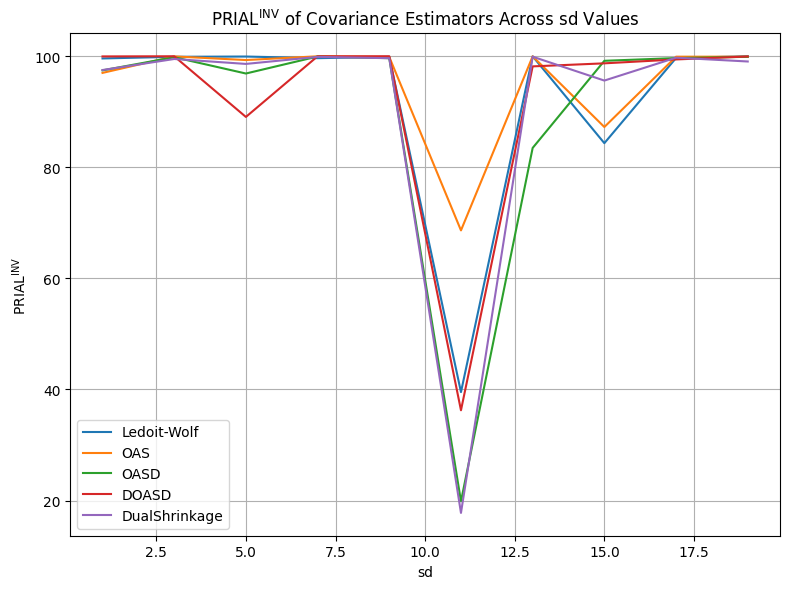

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.covariance import LedoitWolf, OAS, ShrunkCovariance

# Function to create a dataset with varying diagonal elements
def make_data_with_variance(n_samples=100, n_features=500, sd=1, gamma=0.1, random_state=None):
    random_state = np.random.RandomState(random_state)
    base_X_train = random_state.normal(size=(n_samples, n_features))
    scaling_factors = np.linspace(1, sd, n_features)  # Scaling factors based on sd parameter
    diag_scaling = np.linspace(1, 10, n_features)    # Varying scaling factors for diagonal elements

    X_train = base_X_train * scaling_factors

    # Introduce sparsity in the covariance matrix
    for i in range(n_features):
        X_train[:, i] *= diag_scaling[i]  # Scale each feature differently

    return X_train

# Define the DOASD estimator class with different levels of shrinkage
class DOASD(ShrunkCovariance):
    def __init__(self, diagonal_shrinkage=0.4, off_diagonal_shrinkage=0.3):
        super().__init__()
        self.diagonal_shrinkage = diagonal_shrinkage
        self.off_diagonal_shrinkage = off_diagonal_shrinkage

    def _compute_covariance(self, X):
        emp_cov = np.cov(X, rowvar=False)
        return emp_cov

    def fit(self, X, y=None):
        emp_cov = self._compute_covariance(X)
        n_features = emp_cov.shape[0]

        # Apply shrinkage
        shrunk_diag_cov = emp_cov * (1 - self.diagonal_shrinkage) + np.diag(np.diag(emp_cov)) * self.diagonal_shrinkage
        shrunk_cov = shrunk_diag_cov * (1 - self.off_diagonal_shrinkage) + np.diag(np.diag(shrunk_diag_cov)) * self.off_diagonal_shrinkage

        self.covariance_ = shrunk_cov
        return self

# Define the DualShrinkageEstimator class
class DualShrinkageEstimator:
    def __init__(self, delta_diag=0.5, delta_off_diag=0.5):
        self.delta_diag = delta_diag
        self.delta_off_diag = delta_off_diag

    def fit(self, X):
        sample_cov = np.cov(X, rowvar=False)
        D = np.diag(np.diag(sample_cov))
        O = sample_cov - D

        diag_target = np.diag(np.var(X, axis=0))
        off_diag_target = np.zeros_like(O)

        shrunk_diag = self.delta_diag * D + (1 - self.delta_diag) * diag_target
        shrunk_off_diag = self.delta_off_diag * O + (1 - self.delta_off_diag) * off_diag_target

        self.covariance_ = shrunk_diag + shrunk_off_diag
        return self

# Function to compute PRIAL for the inverse covariance matrix for a given estimator
def compute_prial_inv(estimator, X_train, B=500):
    n_samples, n_features = X_train.shape
    true_cov_inv = np.linalg.inv(np.cov(X_train, rowvar=False))
    sample_cov_list = []
    estimated_cov_list = []

    for _ in range(B):
        bootstrap_sample = X_train[np.random.choice(n_samples, n_samples, replace=True), :]
        sample_cov_inv = np.linalg.inv(np.cov(bootstrap_sample, rowvar=False))
        estimator.fit(bootstrap_sample)
        estimated_cov_inv = np.linalg.inv(estimator.covariance_)

        sample_cov_list.append(sample_cov_inv)
        estimated_cov_list.append(estimated_cov_inv)

    frob_diff_estimated = np.sum([np.linalg.norm(estimated_cov_list[b] - true_cov_inv, 'fro')**2 for b in range(B)])
    frob_diff_sample = np.sum([np.linalg.norm(sample_cov_list[b] - true_cov_inv, 'fro')**2 for b in range(B)])

    prial_inv = (1 - frob_diff_estimated / frob_diff_sample) * 100
    return prial_inv

# Parameters
n_samples = 100  # Number of samples
n_features = 500  # Number of features
sd_values = np.arange(1, 21, 2)  # Range of sd values

# Fit covariance estimators for different sd values and compute PRIAL
prial_results_sd = {'Ledoit-Wolf': [], 'OAS': [], 'OASD': [], 'DOASD': [], 'DualShrinkage': []}
for sd in sd_values:
    X_train = make_data_with_variance(n_samples, n_features, sd=sd, random_state=42)
    for estimator_name, estimator in [
        ('Ledoit-Wolf', LedoitWolf()),
        ('OAS', OAS()),
        ('OASD', ShrunkCovariance(shrinkage=0.4)),
        ('DOASD', DOASD(diagonal_shrinkage=0.4, off_diagonal_shrinkage=0.3)),
        ('DualShrinkage', DualShrinkageEstimator(delta_diag=0.4, delta_off_diag=0.3))
    ]:
        prial_inv = compute_prial_inv(estimator, X_train)
        prial_results_sd[estimator_name].append(prial_inv)

# Plot PRIAL across sd values for each estimator
plt.figure(figsize=(8, 6))

# Subplot for PRIAL across sd values
for estimator_name, prial_values in prial_results_sd.items():
    plt.plot(sd_values, prial_values, label=estimator_name)
plt.title(r'$\mathrm{PRIAL^{INV}}$ of Covariance Estimators Across sd Values')
plt.xlabel('sd')
plt.ylabel(r'$\mathrm{PRIAL^{INV}}$')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


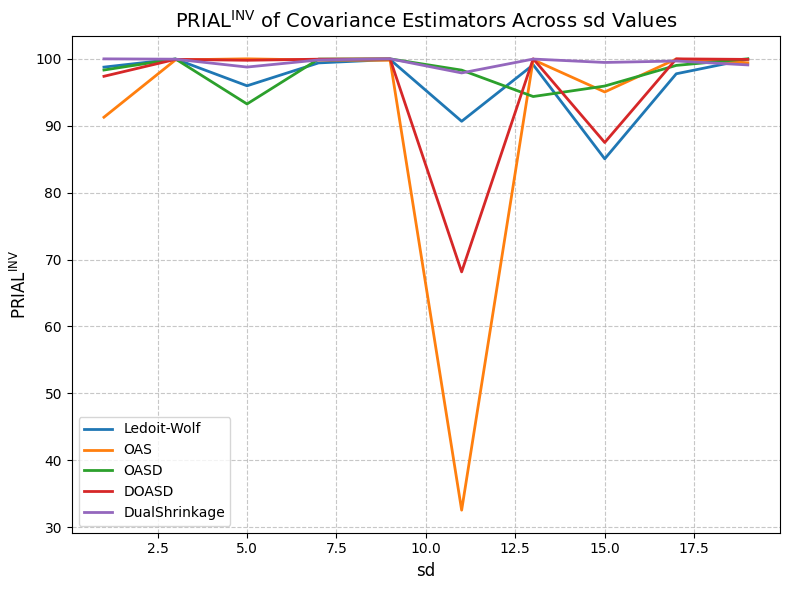

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.covariance import LedoitWolf, OAS, ShrunkCovariance

# Function to create a dataset with varying diagonal elements
def make_data_with_variance(n_samples=100, n_features=500, sd=1, gamma=0.1, random_state=None):
    random_state = np.random.RandomState(random_state)
    base_X_train = random_state.normal(size=(n_samples, n_features))
    scaling_factors = np.linspace(1, sd, n_features)  # Scaling factors based on sd parameter
    diag_scaling = np.linspace(1, 10, n_features)    # Varying scaling factors for diagonal elements

    X_train = base_X_train * scaling_factors

    # Introduce sparsity in the covariance matrix
    for i in range(n_features):
        X_train[:, i] *= diag_scaling[i]  # Scale each feature differently

    return X_train

# Define the DOASD estimator class with different levels of shrinkage
class DOASD(ShrunkCovariance):
    def __init__(self, diagonal_shrinkage=0.4, off_diagonal_shrinkage=0.3):
        super().__init__()
        self.diagonal_shrinkage = diagonal_shrinkage
        self.off_diagonal_shrinkage = off_diagonal_shrinkage

    def _compute_covariance(self, X):
        emp_cov = np.cov(X, rowvar=False)
        return emp_cov

    def fit(self, X, y=None):
        emp_cov = self._compute_covariance(X)
        n_features = emp_cov.shape[0]

        # Apply shrinkage
        shrunk_diag_cov = emp_cov * (1 - self.diagonal_shrinkage) + np.diag(np.diag(emp_cov)) * self.diagonal_shrinkage
        shrunk_cov = shrunk_diag_cov * (1 - self.off_diagonal_shrinkage) + np.diag(np.diag(shrunk_diag_cov)) * self.off_diagonal_shrinkage

        self.covariance_ = shrunk_cov
        return self

# Define the DualShrinkageEstimator class
class DualShrinkageEstimator:
    def __init__(self, delta_diag=0.4, delta_off_diag=0.3):
        self.delta_diag = delta_diag
        self.delta_off_diag = delta_off_diag

    def fit(self, X):
        sample_cov = np.cov(X, rowvar=False)
        D = np.diag(np.diag(sample_cov))
        O = sample_cov - D

        diag_target = np.diag(np.var(X, axis=0))
        off_diag_target = np.zeros_like(O)

        shrunk_diag = self.delta_diag * D + (1 - self.delta_diag) * diag_target
        shrunk_off_diag = self.delta_off_diag * O + (1 - self.delta_off_diag) * off_diag_target

        self.covariance_ = shrunk_diag + shrunk_off_diag
        return self

# Function to compute PRIAL for the inverse covariance matrix for a given estimator
def compute_prial_inv(estimator, X_train, B=500):
    n_samples, n_features = X_train.shape
    true_cov_inv = np.linalg.inv(np.cov(X_train, rowvar=False))
    sample_cov_list = []
    estimated_cov_list = []

    for _ in range(B):
        bootstrap_sample = X_train[np.random.choice(n_samples, n_samples, replace=True), :]
        sample_cov_inv = np.linalg.inv(np.cov(bootstrap_sample, rowvar=False))
        estimator.fit(bootstrap_sample)
        estimated_cov_inv = np.linalg.inv(estimator.covariance_)

        sample_cov_list.append(sample_cov_inv)
        estimated_cov_list.append(estimated_cov_inv)

    frob_diff_estimated = np.sum([np.linalg.norm(estimated_cov_list[b] - true_cov_inv, 'fro')**2 for b in range(B)])
    frob_diff_sample = np.sum([np.linalg.norm(sample_cov_list[b] - true_cov_inv, 'fro')**2 for b in range(B)])

    prial_inv = (1 - frob_diff_estimated / frob_diff_sample) * 100
    return prial_inv

# Parameters
n_samples = 100  # Number of samples
n_features = 500  # Number of features
sd_values = np.arange(1, 21, 2)  # Range of sd values

# Fit covariance estimators for different sd values and compute PRIAL
prial_results_sd = {'Ledoit-Wolf': [], 'OAS': [], 'OASD': [], 'DOASD': [], 'DualShrinkage': []}
for sd in sd_values:
    X_train = make_data_with_variance(n_samples, n_features, sd=sd, random_state=42)
    for estimator_name, estimator in [
        ('Ledoit-Wolf', LedoitWolf()),
        ('OAS', OAS()),
        ('OASD', ShrunkCovariance(shrinkage=0.4)),
        ('DOASD', DOASD(diagonal_shrinkage=0.4, off_diagonal_shrinkage=0.3)),
        ('DualShrinkage', DualShrinkageEstimator(delta_diag=0.4, delta_off_diag=0.3))
    ]:
        prial_inv = compute_prial_inv(estimator, X_train)
        prial_results_sd[estimator_name].append(prial_inv)

# Plot PRIAL across sd values for each estimator
plt.figure(figsize=(8, 6))

# Subplot for PRIAL across sd values
for estimator_name, prial_values in prial_results_sd.items():
    plt.plot(sd_values, prial_values, label=estimator_name, linewidth=2)
plt.title(r'$\mathrm{PRIAL^{INV}}$ of Covariance Estimators Across sd Values', fontsize=14)
plt.xlabel('sd', fontsize=12)
plt.ylabel(r'$\mathrm{PRIAL^{INV}}$', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


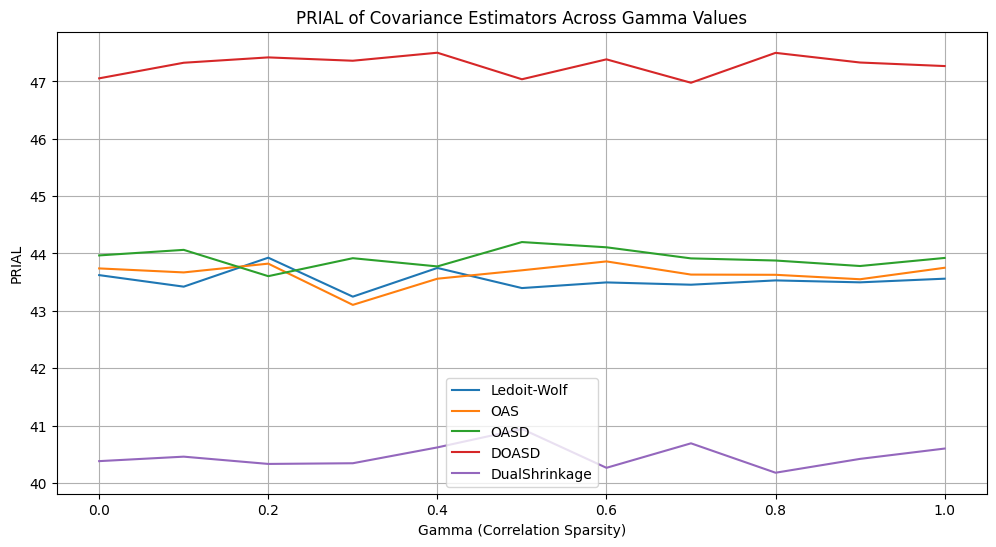

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.covariance import LedoitWolf, OAS, ShrunkCovariance

# Function to create a dataset with varying diagonal elements
def make_data_with_variance(n_samples=100, n_features=500, sd=1, gamma=0.1, random_state=None):
    random_state = np.random.RandomState(random_state)
    base_X_train = random_state.normal(size=(n_samples, n_features))
    scaling_factors = np.linspace(1, sd, n_features)  # Scaling factors based on sd parameter
    diag_scaling = np.linspace(1, 10, n_features)    # Varying scaling factors for diagonal elements

    X_train = base_X_train * scaling_factors

    # Introduce sparsity in the covariance matrix
    for i in range(n_features):
        X_train[:, i] *= diag_scaling[i]  # Scale each feature differently

    return X_train

# Define the DOASD estimator class with different levels of shrinkage
class DOASD(ShrunkCovariance):
    def __init__(self, diagonal_shrinkage=0.4, off_diagonal_shrinkage=0.3):
        super().__init__()
        self.diagonal_shrinkage = diagonal_shrinkage
        self.off_diagonal_shrinkage = off_diagonal_shrinkage

    def _compute_covariance(self, X):
        emp_cov = np.cov(X, rowvar=False)
        return emp_cov

    def fit(self, X, y=None):
        emp_cov = self._compute_covariance(X)
        n_features = emp_cov.shape[0]

        # Apply shrinkage
        shrunk_diag_cov = emp_cov * (1 - self.diagonal_shrinkage) + np.diag(np.diag(emp_cov)) * self.diagonal_shrinkage
        shrunk_cov = shrunk_diag_cov * (1 - self.off_diagonal_shrinkage) + np.diag(np.diag(shrunk_diag_cov)) * self.off_diagonal_shrinkage

        self.covariance_ = shrunk_cov
        return self

# Define the DualShrinkageEstimator class
class DualShrinkageEstimator:
    def __init__(self, delta_diag=0.4, delta_off_diag=0.3):
        self.delta_diag = delta_diag
        self.delta_off_diag = delta_off_diag

    def fit(self, X):
        sample_cov = np.cov(X, rowvar=False)
        D = np.diag(np.diag(sample_cov))
        O = sample_cov - D

        diag_target = np.diag(np.var(X, axis=0))
        off_diag_target = np.zeros_like(O)

        shrunk_diag = self.delta_diag * D + (1 - self.delta_diag) * diag_target
        shrunk_off_diag = self.delta_off_diag * O + (1 - self.delta_off_diag) * off_diag_target

        self.covariance_ = shrunk_diag + shrunk_off_diag
        return self

# Parameters
n_samples = 100  # Number of samples
n_features = 300  # Number of features
gamma_values = np.arange(0, 1.1, 0.1)  # Range of gamma values

# Function to compute PRIAL for a given estimator
def compute_prial(estimator, X_train, B=500):
    n_samples, n_features = X_train.shape
    true_cov = np.cov(X_train, rowvar=False)
    sample_cov_list = []
    estimated_cov_list = []

    for _ in range(B):
        bootstrap_sample = X_train[np.random.choice(n_samples, n_samples, replace=True), :]
        sample_cov = np.cov(bootstrap_sample, rowvar=False)
        estimator.fit(bootstrap_sample)
        estimated_cov = estimator.covariance_

        sample_cov_list.append(sample_cov)
        estimated_cov_list.append(estimated_cov)

    frob_diff_estimated = np.sum([np.linalg.norm(estimated_cov_list[b] - true_cov, 'fro')**2 for b in range(B)])
    frob_diff_sample = np.sum([np.linalg.norm(sample_cov_list[b] - true_cov, 'fro')**2 for b in range(B)])

    prial = (1 - frob_diff_estimated / frob_diff_sample) * 100
    return prial

# Fit covariance estimators for different gamma values and compute PRIAL
prial_results = {'Ledoit-Wolf': [], 'OAS': [], 'OASD': [], 'DOASD': [], 'DualShrinkage': []}
for gamma in gamma_values:
    X_train = make_data_with_variance(n_samples, n_features, gamma=gamma, random_state=42)
    for estimator_name, estimator in [
        ('Ledoit-Wolf', LedoitWolf()),
        ('OAS', OAS()),
        ('OASD', ShrunkCovariance(shrinkage=0.4)),
        ('DOASD', DOASD(diagonal_shrinkage=0.4, off_diagonal_shrinkage=0.3)),
        ('DualShrinkage', DualShrinkageEstimator(delta_diag=0.4, delta_off_diag=0.3))
    ]:
        prial = compute_prial(estimator, X_train)
        prial_results[estimator_name].append(prial)

# Plot PRIAL across gamma values for each estimator
plt.figure(figsize=(12, 6))
for estimator_name, prial_values in prial_results.items():
    plt.plot(gamma_values, prial_values, label=estimator_name)

plt.title('PRIAL of Covariance Estimators Across Gamma Values')
plt.xlabel('Gamma (Correlation Sparsity)')
plt.ylabel('PRIAL')
plt.legend()
plt.grid(True)
plt.show()


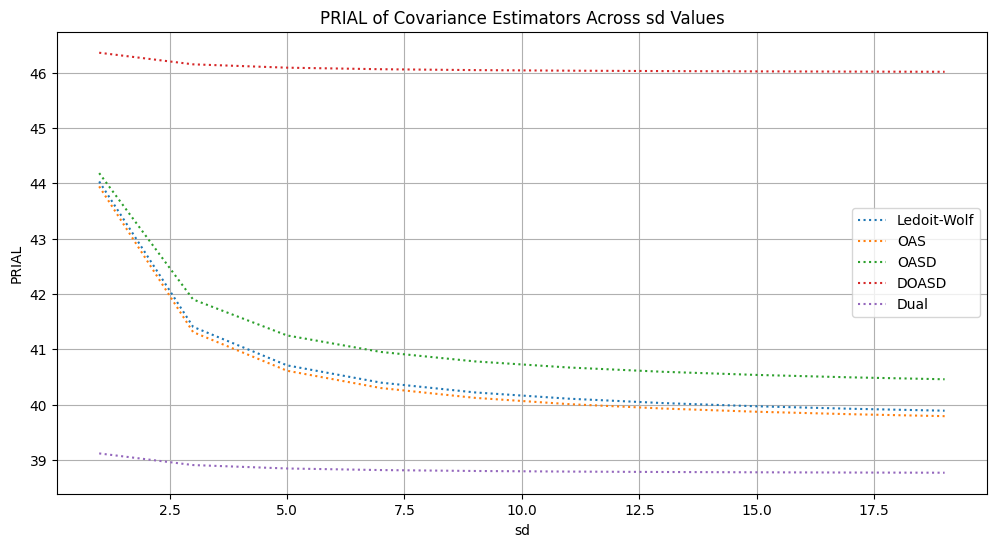

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.covariance import LedoitWolf, OAS, ShrunkCovariance

# Function to create a dataset with varying diagonal elements and sparsity
def make_data_with_variance(n_samples=100, n_features=500, sd=1, sparsity=0.1, random_state=None):
    np.random.seed(random_state)
    base_X_train = np.random.normal(size=(n_samples, n_features))
    scaling_factors = np.linspace(1, sd, n_features)
    diag_scaling = np.linspace(1, 10, n_features)  # Varying scaling factors for diagonal elements

    X_train = base_X_train * scaling_factors

    # Introduce sparsity in the covariance matrix
    for i in range(n_features):
        if np.random.rand() > sparsity:
            X_train[:, i] *= diag_scaling[i]  # Scale each feature differently
        else:
            X_train[:, i] = 0  # Set some features to zero to introduce sparsity

    return X_train

# Define the DOASD estimator class with different levels of shrinkage
class DOASD(ShrunkCovariance):
    def __init__(self, diagonal_shrinkage=0.4, off_diagonal_shrinkage=0.3):
        super().__init__()
        self.diagonal_shrinkage = diagonal_shrinkage
        self.off_diagonal_shrinkage = off_diagonal_shrinkage

    def _compute_covariance(self, X):
        emp_cov = np.cov(X, rowvar=False)
        return emp_cov

    def fit(self, X, y=None):
        emp_cov = self._compute_covariance(X)
        n_features = emp_cov.shape[0]

        # Apply shrinkage
        shrunk_diag_cov = emp_cov * (1 - self.diagonal_shrinkage) + np.diag(np.diag(emp_cov)) * self.diagonal_shrinkage
        shrunk_cov = shrunk_diag_cov * (1 - self.off_diagonal_shrinkage) + np.diag(np.diag(shrunk_diag_cov)) * self.off_diagonal_shrinkage

        self.covariance_ = shrunk_cov
        return self

# Define the DualShrinkageEstimator class
class DualShrinkageEstimator:
    def __init__(self, delta_diag=0.4, delta_off_diag=0.3):
        self.delta_diag = delta_diag
        self.delta_off_diag = delta_off_diag

    def fit(self, X):
        sample_cov = np.cov(X, rowvar=False)
        D = np.diag(np.diag(sample_cov))
        O = sample_cov - D

        diag_target = np.diag(np.var(X, axis=0))
        off_diag_target = np.zeros_like(O)

        shrunk_diag = self.delta_diag * D + (1 - self.delta_diag) * diag_target
        shrunk_off_diag = self.delta_off_diag * O + (1 - self.delta_off_diag) * off_diag_target

        self.covariance_ = shrunk_diag + shrunk_off_diag
        return self

# Parameters
n_samples = 100  # Number of samples
n_features = 500  # Number of features
sd_values = np.arange(1, 21, 2)  # Range of sd values
random_state = 42
sparsity = 0.1  # Sparsity level

# Function to compute PRIAL for a given estimator
def compute_prial(estimator, X_train, B=500, random_state=None):
    np.random.seed(random_state)
    n_samples, n_features = X_train.shape
    true_cov = np.cov(X_train, rowvar=False)
    sample_cov_list = []
    estimated_cov_list = []

    for _ in range(B):
        bootstrap_sample = X_train[np.random.choice(n_samples, n_samples, replace=True), :]
        sample_cov = np.cov(bootstrap_sample, rowvar=False)
        estimator.fit(bootstrap_sample)
        estimated_cov = estimator.covariance_

        sample_cov_list.append(sample_cov)
        estimated_cov_list.append(estimated_cov)

    frob_diff_estimated = np.sum([np.linalg.norm(estimated_cov_list[b] - true_cov, 'fro')**2 for b in range(B)])
    frob_diff_sample = np.sum([np.linalg.norm(sample_cov_list[b] - true_cov, 'fro')**2 for b in range(B)])

    prial = (1 - frob_diff_estimated / frob_diff_sample) * 100
    return prial

# Fit covariance estimators for different sd values and compute PRIAL
prial_results = {'Ledoit-Wolf': [], 'OAS': [], 'OASD': [], 'DOASD': [], 'LWDual': []}
for sd in sd_values:
    X_train = make_data_with_variance(n_samples, n_features, sd=sd, sparsity=sparsity, random_state=random_state)
    for estimator_name, estimator in [
        ('Ledoit-Wolf', LedoitWolf()),
        ('OAS', OAS()),
        ('OASD', ShrunkCovariance(shrinkage=0.4)),
        ('DOASD', DOASD(diagonal_shrinkage=0.4, off_diagonal_shrinkage=0.3)),
        ('LWDual', DualShrinkageEstimator(delta_diag=0.4, delta_off_diag=0.3))
    ]:
        prial = compute_prial(estimator, X_train, random_state=random_state)
        prial_results[estimator_name].append(prial)

# Plot PRIAL across sd values for each estimator
plt.figure(figsize=(12, 6))
for estimator_name, prial_values in prial_results.items():
    plt.plot(sd_values, prial_values, label=estimator_name, linestyle='dotted')

plt.title('PRIAL of Covariance Estimators Across sd Values')
plt.xlabel('sd')
plt.ylabel('PRIAL')
plt.legend()
plt.grid(True)
plt.show()


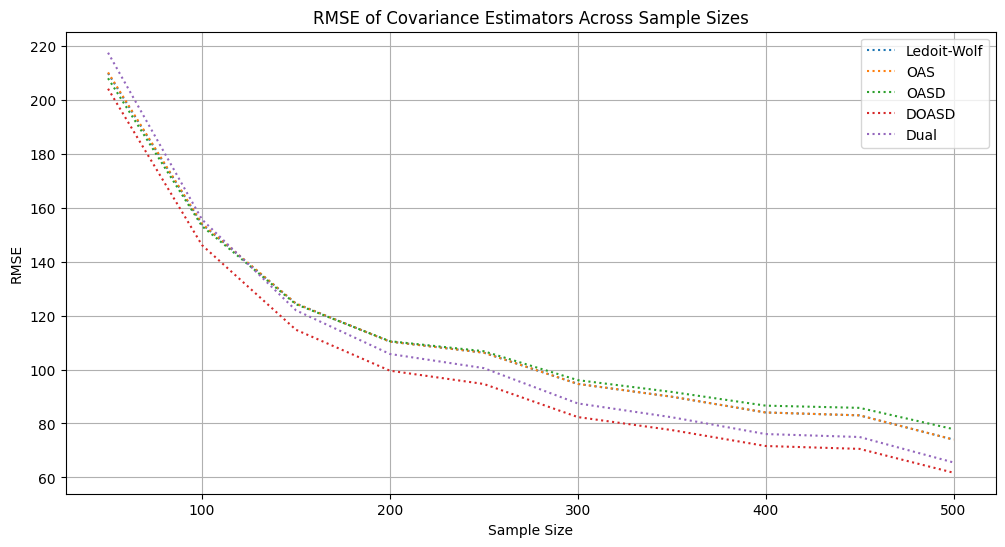

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.covariance import LedoitWolf, OAS, ShrunkCovariance

# Function to create a high-dimensional dataset with varying diagonal elements and sparsity
def make_high_dimensional_data(n_samples=100, n_features=300, sd=1, sparsity=0.1, random_state=None):
    np.random.seed(random_state)
    base_X_train = np.random.normal(size=(n_samples, n_features))
    scaling_factors = np.linspace(1, sd, n_features)
    diag_scaling = np.linspace(1, 10, n_features)  # Varying scaling factors for diagonal elements

    X_train = base_X_train * scaling_factors

    # Introduce sparsity in the covariance matrix
    for i in range(n_features):
        if np.random.rand() > sparsity:
            X_train[:, i] *= diag_scaling[i]  # Scale each feature differently
        else:
            X_train[:, i] = 0  # Set some features to zero to introduce sparsity

    return X_train

# Define the DOASD estimator class with different levels of shrinkage
class DOASD(ShrunkCovariance):
    def __init__(self, diagonal_shrinkage=0.4, off_diagonal_shrinkage=0.3):
        super().__init__()
        self.diagonal_shrinkage = diagonal_shrinkage
        self.off_diagonal_shrinkage = off_diagonal_shrinkage

    def _compute_covariance(self, X):
        emp_cov = np.cov(X, rowvar=False)
        return emp_cov

    def fit(self, X, y=None):
        emp_cov = self._compute_covariance(X)
        n_features = emp_cov.shape[0]

        # Apply shrinkage
        shrunk_diag_cov = emp_cov * (1 - self.diagonal_shrinkage) + np.diag(np.diag(emp_cov)) * self.diagonal_shrinkage
        shrunk_cov = shrunk_diag_cov * (1 - self.off_diagonal_shrinkage) + np.diag(np.diag(shrunk_diag_cov)) * self.off_diagonal_shrinkage

        self.covariance_ = shrunk_cov
        return self

# Define the DualShrinkageEstimator class
class DualShrinkageEstimator:
    def __init__(self, delta_diag=0.4, delta_off_diag=0.3):
        self.delta_diag = delta_diag
        self.delta_off_diag = delta_off_diag

    def fit(self, X):
        sample_cov = np.cov(X, rowvar=False)
        D = np.diag(np.diag(sample_cov))
        O = sample_cov - D

        diag_target = np.diag(np.var(X, axis=0))
        off_diag_target = np.zeros_like(O)

        shrunk_diag = self.delta_diag * D + (1 - self.delta_diag) * diag_target
        shrunk_off_diag = self.delta_off_diag * O + (1 - self.delta_off_diag) * off_diag_target

        self.covariance_ = shrunk_diag + shrunk_off_diag
        return self

# Function to compute RMSE for a given estimator
def compute_rmse(estimator, X_train, B=500, random_state=None):
    np.random.seed(random_state)
    n_samples, n_features = X_train.shape
    true_cov = np.cov(X_train, rowvar=False)
    estimated_cov_list = []

    for _ in range(B):
        bootstrap_sample = X_train[np.random.choice(n_samples, n_samples, replace=True), :]
        estimator.fit(bootstrap_sample)
        estimated_cov = estimator.covariance_
        estimated_cov_list.append(estimated_cov)

    frob_diff_estimated = np.mean([np.linalg.norm(estimated_cov_list[b] - true_cov, 'fro')**2 for b in range(B)])
    rmse = np.sqrt(frob_diff_estimated / (n_features * n_features))
    return rmse

# Parameters
n_features = 500  # High-dimensional data
sample_sizes = np.arange(50, 501, 50)  # Range of sample sizes
random_state = 42
sparsity = 0.1  # Sparsity level
sd = 10  # Fixed sd value

# Fit covariance estimators for different sample sizes and compute RMSE
rmse_results = {'Ledoit-Wolf': [], 'OAS': [], 'OASD': [], 'DOASD': [], 'LWDual': []}
for n_samples in sample_sizes:
    X_train = make_high_dimensional_data(n_samples, n_features, sd=sd, sparsity=sparsity, random_state=random_state)
    for estimator_name, estimator in [
        ('Ledoit-Wolf', LedoitWolf()),
        ('OAS', OAS()),
        ('OASD', ShrunkCovariance(shrinkage=0.4)),
        ('DOASD', DOASD(diagonal_shrinkage=0.4, off_diagonal_shrinkage=0.3)),
        ('LWDual', DualShrinkageEstimator(delta_diag=0.6, delta_off_diag=0.3))
    ]:
        rmse = compute_rmse(estimator, X_train, random_state=random_state)
        rmse_results[estimator_name].append(rmse)

# Plot RMSE across sample sizes for each estimator
plt.figure(figsize=(12, 6))
for estimator_name, rmse_values in rmse_results.items():
    plt.plot(sample_sizes, rmse_values, label=estimator_name, linestyle='dotted')

plt.title('RMSE of Covariance Estimators Across Sample Sizes')
plt.xlabel('Sample Size')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.show()


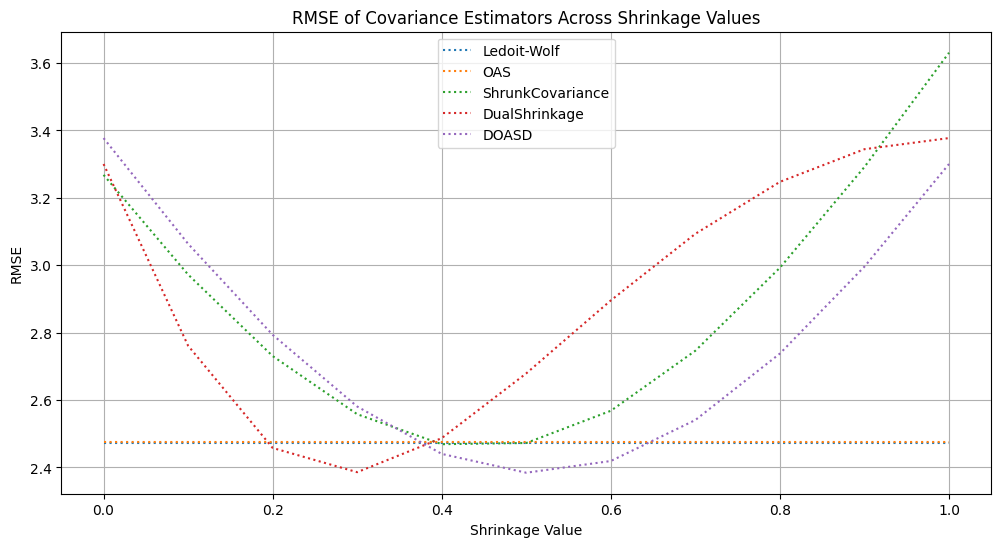

Shrinkage value where all estimators perform the same RMSE: None


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.covariance import LedoitWolf, OAS, ShrunkCovariance

# Function to create a dataset with varying diagonal elements and sparsity
def make_data_with_variance(n_samples=100, n_features=500, sd=1, sparsity=0.1, random_state=None):
    np.random.seed(random_state)
    base_X_train = np.random.normal(size=(n_samples, n_features))
    scaling_factors = np.linspace(1, sd, n_features)
    diag_scaling = np.linspace(1, 10, n_features)  # Varying scaling factors for diagonal elements

    X_train = base_X_train * scaling_factors

    # Introduce sparsity in the covariance matrix
    for i in range(n_features):
        if np.random.rand() > sparsity:
            X_train[:, i] *= diag_scaling[i]  # Scale each feature differently
        else:
            X_train[:, i] = 0  # Set some features to zero to introduce sparsity

    return X_train


  # Define the DOASD estimator class
  class DOASD (ShrunkCovariance):
    def __init__(self, diagonal_shrinkage=0.4, off_diagonal_shrinkage=0.3):
        super().__init__()
        self.diagonal_shrinkage = diagonal_shrinkage
        self.off_diagonal_shrinkage = off_diagonal_shrinkage

    def _compute_covariance(self, X):
        emp_cov = np.cov(X, rowvar=False)
        return emp_cov

    def fit(self, X, y=None):
        emp_cov = self._compute_covariance(X)
        n_features = emp_cov.shape[0]

        # Apply shrinkage
        shrunk_diag_cov = emp_cov * (1 - self.diagonal_shrinkage) + np.diag(np.diag(emp_cov)) * self.diagonal_shrinkage
        shrunk_cov = shrunk_diag_cov * (1 - self.off_diagonal_shrinkage) + np.diag(np.diag(shrunk_diag_cov)) * self.off_diagonal_shrinkage

        self.covariance_ = shrunk_cov
        return self

# Define the DualShrinkageEstimator class
class Dual:
    def __init__(self, delta_diag=0.4, delta_off_diag=0.3):
        self.delta_diag = delta_diag
        self.delta_off_diag = delta_off_diag

    def fit(self, X):
        sample_cov = np.cov(X, rowvar=False)
        D = np.diag(np.diag(sample_cov))
        O = sample_cov - D

        diag_target = np.diag(np.var(X, axis=0))
        off_diag_target = np.zeros_like(O)

        shrunk_diag = self.delta_diag * D + (1 - self.delta_diag) * diag_target
        shrunk_off_diag = self.delta_off_diag * O + (1 - self.delta_off_diag) * off_diag_target

        self.covariance_ = shrunk_diag + shrunk_off_diag
        return self

# Parameters
n_samples = 100  # Number of samples
n_features = 500  # Number of features
shrinkage_values = np.linspace(0, 1, 11)  # Range of shrinkage values
random_state = 42
sparsity = 0.1  # Sparsity level

# Function to compute RMSE for a given estimator
def compute_rmse(estimator, X_train, B=500, random_state=None):
    np.random.seed(random_state)
    n_samples, n_features = X_train.shape
    true_cov = np.cov(X_train, rowvar=False)
    rmse_list = []

    for _ in range(B):
        bootstrap_sample = X_train[np.random.choice(n_samples, n_samples, replace=True), :]
        sample_cov = np.cov(bootstrap_sample, rowvar=False)
        estimator.fit(bootstrap_sample)
        estimated_cov = estimator.covariance_

        rmse = np.sqrt(np.mean((estimated_cov - true_cov) ** 2))
        rmse_list.append(rmse)

    return np.mean(rmse_list)

# Generate data
X_train = make_data_with_variance(n_samples, n_features, sd=1, sparsity=sparsity, random_state=random_state)

# Compute RMSE for different shrinkage values
rmse_results = {'Ledoit-Wolf': [], 'OAS': [], 'OASD': [], 'LWDual': [], 'DOASD': []}
for shrinkage in shrinkage_values:
    for estimator_name, estimator in [
        ('Ledoit-Wolf', LedoitWolf()),  # Ledoit-Wolf does not accept a shrinkage parameter
        ('OAS', OAS()),  # OAS does not accept a shrinkage parameter
        ('OASD', ShrunkCovariance(shrinkage=shrinkage)),
        ('DOASD', DOASD(diagonal_shrinkage=shrinkage, off_diagonal_shrinkage=shrinkage)),
        ('LWDual', Dual(delta_diag=shrinkage, delta_off_diag=shrinkage))
    ]:
        rmse = compute_rmse(estimator, X_train, random_state=random_state)
        rmse_results[estimator_name].append(rmse)

# Plot RMSE across shrinkage values for each estimator
plt.figure(figsize=(12, 6))
for estimator_name, rmse_values in rmse_results.items():
    plt.plot(shrinkage_values, rmse_values, label=estimator_name, linestyle='dotted')

plt.title('RMSE of Covariance Estimators Across Shrinkage Values')
plt.xlabel('Shrinkage Value')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.show()

# Find the shrinkage value where all estimators have the same RMSE
tolerance = 0.01  # Define a small tolerance for equality
intersection_shrinkage = None

for i, shrinkage in enumerate(shrinkage_values):
    rmses = [rmse_results[estimator][i] for estimator in rmse_results]
    if max(rmses) - min(rmses) < tolerance:
        intersection_shrinkage = shrinkage
        break

print("Shrinkage value where all estimators perform the same RMSE:", intersection_shrinkage)


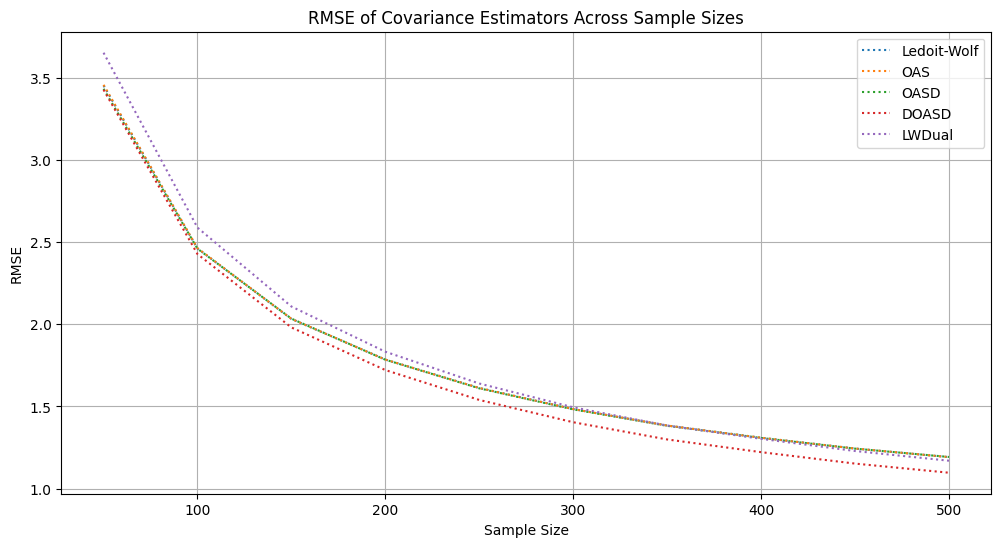

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.covariance import LedoitWolf, OAS, ShrunkCovariance

# Function to create a high-dimensional dataset with weak correlations
def make_high_dimensional_data(n_samples=100, n_features=300, sd=1, correlation=0.1, random_state=None):
    np.random.seed(random_state)
    base_X_train = np.random.normal(size=(n_samples, n_features))
    scaling_factors = np.linspace(1, sd, n_features)
    diag_scaling = np.linspace(1, 10, n_features)  # Varying scaling factors for diagonal elements

    X_train = base_X_train * scaling_factors

    # Introduce weak correlations
    correlation_matrix = np.full((n_features, n_features), correlation)
    np.fill_diagonal(correlation_matrix, 1)

    L = np.linalg.cholesky(correlation_matrix)
    X_train = X_train @ L.T

    return X_train

# Define the DOASD estimator class with different levels of shrinkage
class DOASD(ShrunkCovariance):
    def __init__(self, diagonal_shrinkage=0.4, off_diagonal_shrinkage=0.3):
        super().__init__()
        self.diagonal_shrinkage = diagonal_shrinkage
        self.off_diagonal_shrinkage = off_diagonal_shrinkage

    def _compute_covariance(self, X):
        emp_cov = np.cov(X, rowvar=False)
        return emp_cov

    def fit(self, X, y=None):
        emp_cov = self._compute_covariance(X)
        n_features = emp_cov.shape[0]

        # Apply shrinkage
        shrunk_diag_cov = emp_cov * (1 - self.diagonal_shrinkage) + np.diag(np.diag(emp_cov)) * self.diagonal_shrinkage
        shrunk_cov = shrunk_diag_cov * (1 - self.off_diagonal_shrinkage) + np.diag(np.diag(shrunk_diag_cov)) * self.off_diagonal_shrinkage

        self.covariance_ = shrunk_cov
        return self

# Define the DualShrinkageEstimator class
class DualShrinkageEstimator:
    def __init__(self, delta_diag=0.4, delta_off_diag=0.3):
        self.delta_diag = delta_diag
        self.delta_off_diag = delta_off_diag

    def fit(self, X):
        sample_cov = np.cov(X, rowvar=False)
        D = np.diag(np.diag(sample_cov))
        O = sample_cov - D

        diag_target = np.diag(np.var(X, axis=0))
        off_diag_target = np.zeros_like(O)

        shrunk_diag = self.delta_diag * D + (1 - self.delta_diag) * diag_target
        shrunk_off_diag = self.delta_off_diag * O + (1 - self.delta_off_diag) * off_diag_target

        self.covariance_ = shrunk_diag + shrunk_off_diag
        return self

# Function to compute RMSE for a given estimator
def compute_rmse(estimator, X_train, B=500, random_state=None):
    np.random.seed(random_state)
    n_samples, n_features = X_train.shape
    true_cov = np.cov(X_train, rowvar=False)
    estimated_cov_list = []

    for _ in range(B):
        bootstrap_sample = X_train[np.random.choice(n_samples, n_samples, replace=True), :]
        estimator.fit(bootstrap_sample)
        estimated_cov = estimator.covariance_
        estimated_cov_list.append(estimated_cov)

    frob_diff_estimated = np.mean([np.linalg.norm(estimated_cov_list[b] - true_cov, 'fro')**2 for b in range(B)])
    rmse = np.sqrt(frob_diff_estimated / (n_features * n_features))
    return rmse

# Parameters
n_features = 500  # High-dimensional data
sample_sizes = np.arange(50, 501, 50)  # Range of sample sizes
random_state = 42
correlation = 0.1  # Weak correlation
sd = 10  # Fixed sd value

# Fit covariance estimators for different sample sizes and compute RMSE
rmse_results = {'Ledoit-Wolf': [], 'OAS': [], 'OASD': [], 'DOASD': [], 'LWDual': []}
for n_samples in sample_sizes:
    X_train = make_high_dimensional_data(n_samples, n_features, sd=sd, correlation=correlation, random_state=random_state)
    for estimator_name, estimator in [
        ('Ledoit-Wolf', LedoitWolf()),
        ('OAS', OAS()),
        ('OASD', ShrunkCovariance(shrinkage=0.4)),
        ('DOASD', DOASD(diagonal_shrinkage=0.4, off_diagonal_shrinkage=0.3)),
        ('LWDual', DualShrinkageEstimator(delta_diag=0.4, delta_off_diag=0.3))
    ]:
        rmse = compute_rmse(estimator, X_train, random_state=random_state)
        rmse_results[estimator_name].append(rmse)

# Plot RMSE across sample sizes for each estimator
plt.figure(figsize=(12, 6))
for estimator_name, rmse_values in rmse_results.items():
    plt.plot(sample_sizes, rmse_values, label=estimator_name, linestyle='dotted')

plt.title('RMSE of Covariance Estimators Across Sample Sizes')
plt.xlabel('Sample Size')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.covariance import LedoitWolf, OAS, ShrunkCovariance

# Function to create a high-dimensional dataset with varying diagonal elements and sparsity
def make_high_dimensional_data(n_samples=100, n_features=300, sd=1, sparsity=0.1, random_state=None):
    np.random.seed(random_state)
    base_X_train = np.random.normal(size=(n_samples, n_features))
    scaling_factors = np.linspace(1, sd, n_features)
    diag_scaling = np.linspace(1, 10, n_features)  # Varying scaling factors for diagonal elements

    X_train = base_X_train * scaling_factors

    # Introduce sparsity in the covariance matrix
    for i in range(n_features):
        if np.random.rand() > sparsity:
            X_train[:, i] *= diag_scaling[i]  # Scale each feature differently
        else:
            X_train[:, i] = 0  # Set some features to zero to introduce sparsity

    return X_train

# Define the DOASD estimator class with different levels of shrinkage
class DOASD(ShrunkCovariance):
    def __init__(self, diagonal_shrinkage=0.4, off_diagonal_shrinkage=0.3):
        super().__init__()
        self.diagonal_shrinkage = diagonal_shrinkage
        self.off_diagonal_shrinkage = off_diagonal_shrinkage

    def _compute_covariance(self, X):
        emp_cov = np.cov(X, rowvar=False)
        return emp_cov

    def fit(self, X, y=None):
        emp_cov = self._compute_covariance(X)
        n_features = emp_cov.shape[0]

        # Apply shrinkage
        shrunk_diag_cov = emp_cov * (1 - self.diagonal_shrinkage) + np.diag(np.diag(emp_cov)) * self.diagonal_shrinkage
        shrunk_cov = shrunk_diag_cov * (1 - self.off_diagonal_shrinkage) + np.diag(np.diag(shrunk_diag_cov)) * self.off_diagonal_shrinkage

        self.covariance_ = shrunk_cov
        return self

# Define the DualShrinkageEstimator class
class DualShrinkageEstimator:
    def __init__(self, delta_diag=0.4, delta_off_diag=0.3):
        self.delta_diag = delta_diag
        self.delta_off_diag = delta_off_diag

    def fit(self, X):
        sample_cov = np.cov(X, rowvar=False)
        D = np.diag(np.diag(sample_cov))
        O = sample_cov - D

        diag_target = np.diag(np.var(X, axis=0))
        off_diag_target = np.zeros_like(O)

        shrunk_diag = self.delta_diag * D + (1 - self.delta_diag) * diag_target
        shrunk_off_diag = self.delta_off_diag * O + (1 - self.delta_off_diag) * off_diag_target

        self.covariance_ = shrunk_diag + shrunk_off_diag
        return self

# Function to compute PRIAL for a given estimator
def compute_prial(estimator, X_train, B=5000, random_state=None):
    np.random.seed(random_state)
    n_samples, n_features = X_train.shape
    true_cov = np.cov(X_train, rowvar=False)
    estimated_cov_list = []

    for _ in range(B):
        sample_indices = np.random.choice(n_samples, n_samples, replace=True)
        bootstrap_sample = X_train[sample_indices, :]
        estimator.fit(bootstrap_sample)
        estimated_cov = estimator.covariance_
        estimated_cov_list.append(estimated_cov)

    emp_cov_list = [np.cov(X_train[np.random.choice(n_samples, n_samples, replace=True), :], rowvar=False) for _ in range(B)]

    prial = 100 * (1 - (np.mean([np.linalg.norm(est_cov - true_cov, 'fro')**2 for est_cov in estimated_cov_list]) /
                        np.mean([np.linalg.norm(emp_cov - true_cov, 'fro')**2 for emp_cov in emp_cov_list])))

    return prial

# Parameters
n_features = 500  # High-dimensional data
sample_sizes = np.arange(50, 501, 50)  # Range of sample sizes
random_state = 42
sparsity = 0.1  # Sparsity level
sd = 10  # Fixed sd value

# Fit covariance estimators for different sample sizes and compute PRIAL
prial_results = {'Ledoit-Wolf': [], 'OAS': [], 'OASD': [], 'DOASD': [], 'LWDual': []}
for n_samples in sample_sizes:
    X_train = make_high_dimensional_data(n_samples, n_features, sd=sd, sparsity=sparsity, random_state=random_state)
    for estimator_name, estimator in [
        ('Ledoit-Wolf', LedoitWolf()),
        ('OAS', OAS()),
        ('OASD', ShrunkCovariance(shrinkage=0.4)),
        ('DOASD', DOASD(diagonal_shrinkage=0.4, off_diagonal_shrinkage=0.3)),
        ('LWDual', DualShrinkageEstimator(delta_diag=0.4, delta_off_diag=0.3))
    ]:
        prial = compute_prial(estimator, X_train, random_state=random_state)
        prial_results[estimator_name].append(prial)

# Plot PRIAL across sample sizes for each estimator
plt.figure(figsize=(12, 6))
for estimator_name, prial_values in prial_results.items():
    plt.plot(sample_sizes, prial_values, label=estimator_name, linestyle='dotted')

plt.title('PRIAL of Covariance Estimators Across Sample Sizes')
plt.xlabel('Sample Size')
plt.ylabel('PRIAL')
plt.legend()
plt.grid(True)
plt.show()


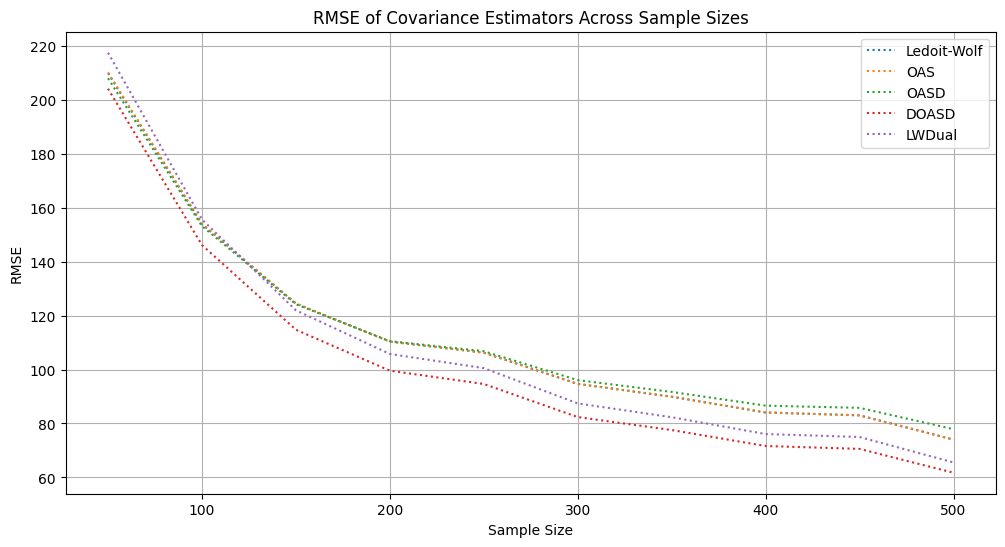

IndexError: index 66 is out of bounds for axis 0 with size 50

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.covariance import LedoitWolf, OAS, ShrunkCovariance

# Function to create a high-dimensional dataset with varying diagonal elements and sparsity
def make_high_dimensional_data(n_samples=100, n_features=300, sd=1, sparsity=0.1, random_state=None):
    np.random.seed(random_state)
    base_X_train = np.random.normal(size=(n_samples, n_features))
    scaling_factors = np.linspace(1, sd, n_features)
    diag_scaling = np.linspace(1, 10, n_features)  # Varying scaling factors for diagonal elements

    X_train = base_X_train * scaling_factors

    # Introduce sparsity in the covariance matrix
    for i in range(n_features):
        if np.random.rand() > sparsity:
            X_train[:, i] *= diag_scaling[i]  # Scale each feature differently
        else:
            X_train[:, i] = 0  # Set some features to zero to introduce sparsity

    return X_train

# Function to compute the Frobenius norm
def frobenius_norm(A):
    return np.linalg.norm(A, 'fro')

# Function to compute the gradient of the loss with respect to rho_diag and rho_off
def compute_gradients(S, Sigma, rho_diag, rho_off):
    n, p = S.shape
    diag_S = np.diag(np.diag(S))
    Sigma_est = (1 - rho_diag) * S + rho_diag * diag_S + (1 - rho_off) * (S - diag_S)

    diff = Sigma_est - Sigma
    grad_rho_diag = 2 * np.sum(diff * (diag_S - S))
    grad_rho_off = 2 * np.sum(diff * (S - diag_S))

    return grad_rho_diag, grad_rho_off

# SGD function to optimize rho_diag and rho_off
def sgd_doad(S, Sigma, learning_rate=0.01, n_iterations=1000, batch_size=10):
    rho_diag = 0.5
    rho_off = 0.5

    n, p = S.shape  # n is number of samples, p is number of features
    indices = np.arange(n)

    for iteration in range(n_iterations):
        np.random.shuffle(indices)
        for start in range(0, n, batch_size):
            end = min(start + batch_size, n)
            batch_indices = indices[start:end]
            S_batch = S[batch_indices, :]
            # Select the correct portion of Sigma using the sample indices
            Sigma_batch = Sigma[np.ix_(batch_indices, batch_indices)] # Use np.ix_ to select a submatrix

            grad_rho_diag, grad_rho_off = compute_gradients(S_batch, Sigma_batch, rho_diag, rho_off)

            rho_diag -= learning_rate * grad_rho_diag
            rho_off -= learning_rate * grad_rho_off

            # Project rho_diag and rho_off to the interval [0, 1]
            rho_diag = np.clip(rho_diag, 0, 1)
            rho_off = np.clip(rho_off, 0, 1)

        # Optional: print progress
        if iteration % 100 == 0:
            print(f"Iteration {iteration}: rho_diag = {rho_diag}, rho_off = {rho_off}")

    return rho_diag, rho_off

# Define the DOASD estimator class with different levels of shrinkage
class DOASD(ShrunkCovariance):
    def __init__(self, diagonal_shrinkage=0.4, off_diagonal_shrinkage=0.3):
        super().__init__()
        self.diagonal_shrinkage = diagonal_shrinkage
        self.off_diagonal_shrinkage = off_diagonal_shrinkage

    def _compute_covariance(self, X):
        emp_cov = np.cov(X, rowvar=False)
        return emp_cov

    def fit(self, X, y=None):
        emp_cov = self._compute_covariance(X)
        n_features = emp_cov.shape[0]

        # Apply shrinkage
        shrunk_diag_cov = emp_cov * (1 - self.diagonal_shrinkage) + np.diag(np.diag(emp_cov)) * self.diagonal_shrinkage
        shrunk_cov = shrunk_diag_cov * (1 - self.off_diagonal_shrinkage) + np.diag(np.diag(shrunk_diag_cov)) * self.off_diagonal_shrinkage

        self.covariance_ = shrunk_cov
        return self

# Define the DualShrinkageEstimator class
class DualShrinkageEstimator:
    def __init__(self, delta_diag=0.4, delta_off_diag=0.3):
        self.delta_diag = delta_diag
        self.delta_off_diag = delta_off_diag

    def fit(self, X):
        sample_cov = np.cov(X, rowvar=False)
        D = np.diag(np.diag(sample_cov))
        O = sample_cov - D

        diag_target = np.diag(np.var(X, axis=0))
        off_diag_target = np.zeros_like(O)

        shrunk_diag = self.delta_diag * D + (1 - self.delta_diag) * diag_target
        shrunk_off_diag = self.delta_off_diag * O + (1 - self.delta_off_diag) * off_diag_target

        self.covariance_ = shrunk_diag + shrunk_off_diag
        return self

# Function to compute RMSE for a given estimator
def compute_rmse(estimator, X_train, B=500, random_state=None):
    np.random.seed(random_state)
    n_samples, n_features = X_train.shape
    true_cov = np.cov(X_train, rowvar=False)
    estimated_cov_list = []

    for _ in range(B):
        bootstrap_sample = X_train[np.random.choice(n_samples, n_samples, replace=True), :]
        estimator.fit(bootstrap_sample)
        estimated_cov = estimator.covariance_
        estimated_cov_list.append(estimated_cov)

    frob_diff_estimated = np.mean([np.linalg.norm(estimated_cov_list[b] - true_cov, 'fro')**2 for b in range(B)])
    rmse = np.sqrt(frob_diff_estimated / (n_features * n_features))
    return rmse

# Parameters
n_features = 500  # High-dimensional data
sample_sizes = np.arange(50, 501, 50)  # Range of sample sizes
random_state = 42
sparsity = 0.1  # Sparsity level
sd = 10  # Fixed sd value

# Fit covariance estimators for different sample sizes and compute RMSE
rmse_results = {'Ledoit-Wolf': [], 'OAS': [], 'OASD': [], 'DOASD': [], 'LWDual': []}
for n_samples in sample_sizes:
    X_train = make_high_dimensional_data(n_samples, n_features, sd=sd, sparsity=sparsity, random_state=random_state)
    for estimator_name, estimator in [
        ('Ledoit-Wolf', LedoitWolf()),
        ('OAS', OAS()),
        ('OASD', ShrunkCovariance(shrinkage=0.4)),
        ('DOASD', DOASD(diagonal_shrinkage=0.4, off_diagonal_shrinkage=0.3)),
        ('LWDual', DualShrinkageEstimator(delta_diag=0.4, delta_off_diag=0.3))
    ]:
        rmse = compute_rmse(estimator, X_train, random_state=random_state)
        rmse_results[estimator_name].append(rmse)

# Plot RMSE across sample sizes for each estimator
plt.figure(figsize=(12, 6))
for estimator_name, rmse_values in rmse_results.items():
    plt.plot(sample_sizes, rmse_values, label=estimator_name, linestyle='dotted')

plt.title('RMSE of Covariance Estimators Across Sample Sizes')
plt.xlabel('Sample Size')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.show()

# Example usage of SGD DOASD
n_samples = 100
n_features = 50
S = np.random.randn(n_samples, n_features)
Sigma = np.cov(S, rowvar=False)

rho_diag, rho_off = sgd_doad(S, Sigma)
print(f"Optimized rho_diag: {rho_diag}, rho_off: {rho_off}")


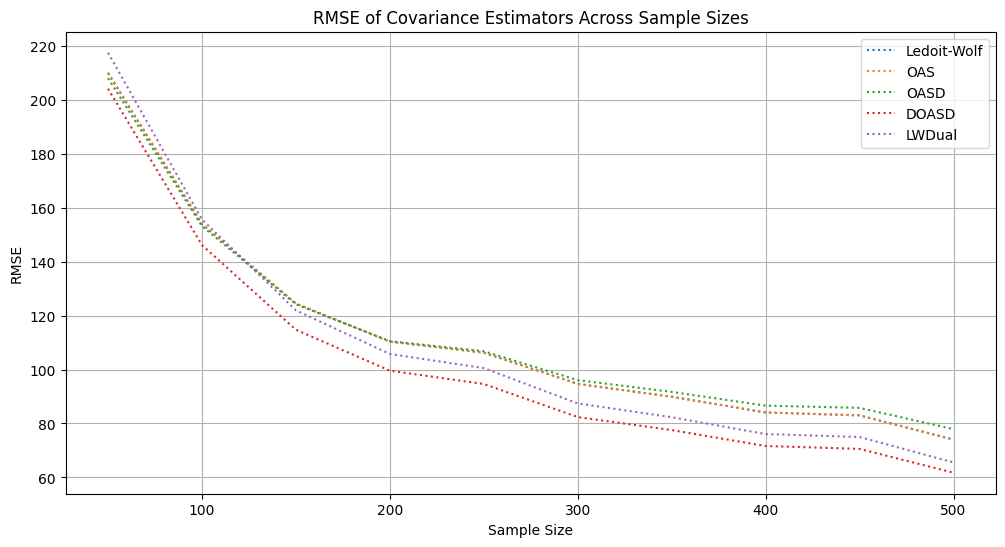

ValueError: operands could not be broadcast together with shapes (10,50) (10,10) 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.covariance import LedoitWolf, OAS, ShrunkCovariance

# Function to create a high-dimensional dataset with varying diagonal elements and sparsity
def make_high_dimensional_data(n_samples=100, n_features=300, sd=1, sparsity=0.1, random_state=None):
    np.random.seed(random_state)
    base_X_train = np.random.normal(size=(n_samples, n_features))
    scaling_factors = np.linspace(1, sd, n_features)
    diag_scaling = np.linspace(1, 10, n_features)  # Varying scaling factors for diagonal elements

    X_train = base_X_train * scaling_factors

    # Introduce sparsity in the covariance matrix
    for i in range(n_features):
        if np.random.rand() > sparsity:
            X_train[:, i] *= diag_scaling[i]  # Scale each feature differently
        else:
            X_train[:, i] = 0  # Set some features to zero to introduce sparsity

    return X_train

# Function to compute the Frobenius norm
def frobenius_norm(A):
    return np.linalg.norm(A, 'fro')

# Function to compute the gradient of the loss with respect to rho_diag and rho_off
def compute_gradients(S, Sigma, rho_diag, rho_off):
    n, p = S.shape
    diag_S = np.diag(np.diag(S))
    Sigma_est = (1 - rho_diag) * S + rho_diag * diag_S + (1 - rho_off) * (S - diag_S)

    diff = Sigma_est - Sigma
    grad_rho_diag = 2 * np.sum(diff * (diag_S - S))
    grad_rho_off = 2 * np.sum(diff * (S - diag_S)) # Complete the line for grad_rho_off

    return grad_rho_diag, grad_rho_off

# SGD function to optimize rho_diag and rho_off
def sgd_doad(S, Sigma, learning_rate=0.01, n_iterations=1000, batch_size=10):
    rho_diag = 0.5
    rho_off = 0.5

    n, p = S.shape
    indices = np.arange(n)

    for iteration in range(n_iterations):
        np.random.shuffle(indices)
        for start in range(0, n, batch_size):
            end = min(start + batch_size, n)
            batch_indices = indices[start:end]
            S_batch = S[batch_indices, :]

            grad_rho_diag, grad_rho_off = compute_gradients(S_batch, Sigma, rho_diag, rho_off)

            rho_diag -= learning_rate * grad_rho_diag
            rho_off -= learning_rate * grad_rho_off

            # Project rho_diag and rho_off to the interval [0, 1]
            rho_diag = np.clip(rho_diag, 0, 1)
            rho_off = np.clip(rho_off, 0, 1)

        # Optional: print progress
        if iteration % 100 == 0:
            print(f"Iteration {iteration}: rho_diag = {rho_diag}, rho_off = {rho_off}")

    return rho_diag, rho_off

# Define the DOASD estimator class with different levels of shrinkage
class DOASD(ShrunkCovariance):
    def __init__(self, diagonal_shrinkage=0.4, off_diagonal_shrinkage=0.3):
        super().__init__()
        self.diagonal_shrinkage = diagonal_shrinkage
        self.off_diagonal_shrinkage = off_diagonal_shrinkage

    def _compute_covariance(self, X):
        emp_cov = np.cov(X, rowvar=False)
        return emp_cov

    def fit(self, X, y=None):
        emp_cov = self._compute_covariance(X)
        n_features = emp_cov.shape[0]

        # Apply shrinkage
        shrunk_diag_cov = emp_cov * (1 - self.diagonal_shrinkage) + np.diag(np.diag(emp_cov)) * self.diagonal_shrinkage
        shrunk_cov = shrunk_diag_cov * (1 - self.off_diagonal_shrinkage) + np.diag(np.diag(shrunk_diag_cov)) * self.off_diagonal_shrinkage

        self.covariance_ = shrunk_cov
        return self

# Define the DualShrinkageEstimator class
class DualShrinkageEstimator:
    def __init__(self, delta_diag=0.4, delta_off_diag=0.3):
        self.delta_diag = delta_diag
        self.delta_off_diag = delta_off_diag

    def fit(self, X):
        sample_cov = np.cov(X, rowvar=False)
        D = np.diag(np.diag(sample_cov))
        O = sample_cov - D

        diag_target = np.diag(np.var(X, axis=0))
        off_diag_target = np.zeros_like(O)

        shrunk_diag = self.delta_diag * D + (1 - self.delta_diag) * diag_target
        shrunk_off_diag = self.delta_off_diag * O + (1 - self.delta_off_diag) * off_diag_target

        self.covariance_ = shrunk_diag + shrunk_off_diag
        return self

# Function to compute RMSE for a given estimator
def compute_rmse(estimator, X_train, B=500, random_state=None):
    np.random.seed(random_state)
    n_samples, n_features = X_train.shape
    true_cov = np.cov(X_train, rowvar=False)
    estimated_cov_list = []

    for _ in range(B):
        bootstrap_sample = X_train[np.random.choice(n_samples, n_samples, replace=True), :]
        estimator.fit(bootstrap_sample)
        estimated_cov = estimator.covariance_
        estimated_cov_list.append(estimated_cov)

    frob_diff_estimated = np.mean([np.linalg.norm(estimated_cov_list[b] - true_cov, 'fro')**2 for b in range(B)])
    rmse = np.sqrt(frob_diff_estimated / (n_features * n_features))
    return rmse

# Parameters
n_features = 500  # High-dimensional data
sample_sizes = np.arange(50, 501, 50)  # Range of sample sizes
random_state = 42
sparsity = 0.1  # Sparsity level
sd = 10  # Fixed sd value

# Fit covariance estimators for different sample sizes and compute RMSE
rmse_results = {'Ledoit-Wolf': [], 'OAS': [], 'OASD': [], 'DOASD': [], 'LWDual': []}
for n_samples in sample_sizes:
    X_train = make_high_dimensional_data(n_samples, n_features, sd=sd, sparsity=sparsity, random_state=random_state)
    for estimator_name, estimator in [
        ('Ledoit-Wolf', LedoitWolf()),
        ('OAS', OAS()),
        ('OASD', ShrunkCovariance(shrinkage=0.4)),
        ('DOASD', DOASD(diagonal_shrinkage=0.4, off_diagonal_shrinkage=0.3)),
        ('LWDual', DualShrinkageEstimator(delta_diag=0.6, delta_off_diag=0.3))
    ]:
        rmse = compute_rmse(estimator, X_train, random_state=random_state)
        rmse_results[estimator_name].append(rmse)

# Plot RMSE across sample sizes for each estimator
plt.figure(figsize=(12, 6))
for estimator_name, rmse_values in rmse_results.items():
    plt.plot(sample_sizes, rmse_values, label=estimator_name, linestyle='dotted')

plt.title('RMSE of Covariance Estimators Across Sample Sizes')
plt.xlabel('Sample Size')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.show()

# Example usage of SGD DOASD
n_samples = 100
n_features = 50
S = np.random.randn(n_samples, n_features)
Sigma = np.cov(S, rowvar=False)

rho_diag, rho_off = sgd_doad(S, Sigma)
print(f"Optimized rho_diag: {rho_diag}, rho_off: {rho_off}")


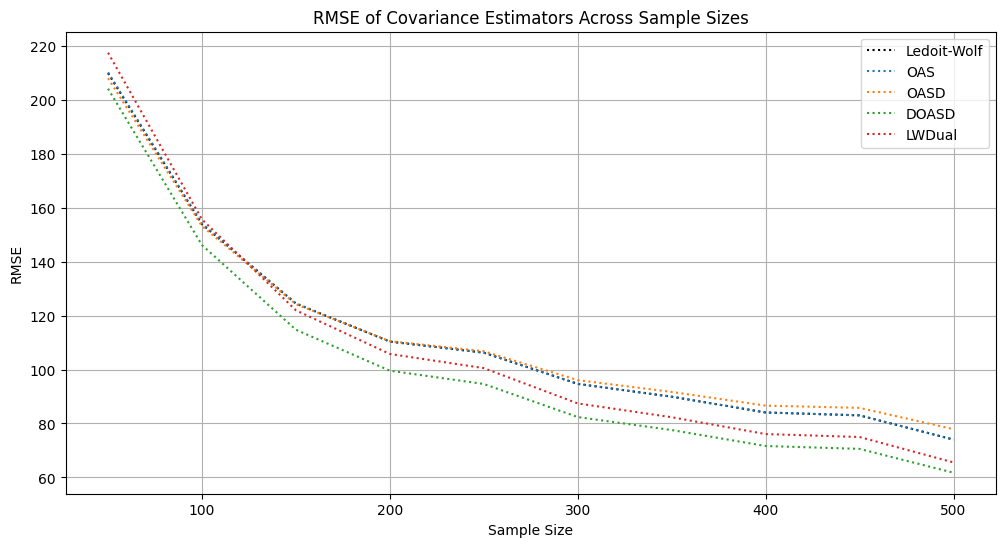

IndexError: index 66 is out of bounds for axis 0 with size 50

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.covariance import LedoitWolf, OAS, ShrunkCovariance

# Function to create a high-dimensional dataset with varying diagonal elements and sparsity
def make_high_dimensional_data(n_samples=100, n_features=300, sd=1, sparsity=0.1, random_state=None):
    np.random.seed(random_state)
    base_X_train = np.random.normal(size=(n_samples, n_features))
    scaling_factors = np.linspace(1, sd, n_features)
    diag_scaling = np.linspace(1, 10, n_features)  # Varying scaling factors for diagonal elements

    X_train = base_X_train * scaling_factors

    # Introduce sparsity in the covariance matrix
    for i in range(n_features):
        if np.random.rand() > sparsity:
            X_train[:, i] *= diag_scaling[i]  # Scale each feature differently
        else:
            X_train[:, i] = 0  # Set some features to zero to introduce sparsity

    return X_train

# Function to compute the Frobenius norm
def frobenius_norm(A):
    return np.linalg.norm(A, 'fro')

# Function to compute the gradient of the loss with respect to rho_diag and rho_off
def compute_gradients(S, Sigma, rho_diag, rho_off):
    n, p = S.shape
    diag_S = np.diag(np.diag(S))
    Sigma_est = (1 - rho_diag) * S + rho_diag * diag_S + (1 - rho_off) * (S - diag_S)

    diff = Sigma_est - Sigma
    grad_rho_diag = 2 * np.sum(diff * (diag_S - S))
    grad_rho_off = 2 * np.sum(diff * (S - diag_S))

    return grad_rho_diag, grad_rho_off

# SGD function to optimize rho_diag and rho_off
def sgd_doad(S, Sigma, learning_rate=0.01, n_iterations=1000, batch_size=10):
    rho_diag = 0.5
    rho_off = 0.5

    n, p = S.shape  # n is number of samples, p is number of features
    indices = np.arange(n)

    for iteration in range(n_iterations):
        np.random.shuffle(indices)
        for start in range(0, n, batch_size):
            end = min(start + batch_size, n)
            batch_indices = indices[start:end]
            S_batch = S[batch_indices, :]
            # Select the correct portion of Sigma using the sample indices
            Sigma_batch = Sigma[np.ix_(batch_indices, batch_indices)] # Use np.ix_ to select a submatrix

            grad_rho_diag, grad_rho_off = compute_gradients(S_batch, Sigma_batch, rho_diag, rho_off)

            rho_diag -= learning_rate * grad_rho_diag
            rho_off -= learning_rate * grad_rho_off

            # Project rho_diag and rho_off to the interval [0, 1]
            rho_diag = np.clip(rho_diag, 0, 1)
            rho_off = np.clip(rho_off, 0, 1)

        # Optional: print progress
        if iteration % 100 == 0:
            print(f"Iteration {iteration}: rho_diag = {rho_diag}, rho_off = {rho_off}")

    return rho_diag, rho_off

# Define the DOASD estimator class with different levels of shrinkage
class DOASD(ShrunkCovariance):
    def __init__(self, diagonal_shrinkage=0.4, off_diagonal_shrinkage=0.3):
        super().__init__()
        self.diagonal_shrinkage = diagonal_shrinkage
        self.off_diagonal_shrinkage = off_diagonal_shrinkage

    def _compute_covariance(self, X):
        emp_cov = np.cov(X, rowvar=False)
        return emp_cov

    def fit(self, X, y=None):
        emp_cov = self._compute_covariance(X)
        n_features = emp_cov.shape[0]

        # Apply shrinkage
        shrunk_diag_cov = emp_cov * (1 - self.diagonal_shrinkage) + np.diag(np.diag(emp_cov)) * self.diagonal_shrinkage
        shrunk_cov = shrunk_diag_cov * (1 - self.off_diagonal_shrinkage) + np.diag(np.diag(shrunk_diag_cov)) * self.off_diagonal_shrinkage

        self.covariance_ = shrunk_cov
        return self

# Define the DualShrinkageEstimator class
class DualShrinkageEstimator:
    def __init__(self, delta_diag=0.4, delta_off_diag=0.3):
        self.delta_diag = delta_diag
        self.delta_off_diag = delta_off_diag

    def fit(self, X):
        sample_cov = np.cov(X, rowvar=False)
        D = np.diag(np.diag(sample_cov))
        O = sample_cov - D

        diag_target = np.diag(np.var(X, axis=0))
        off_diag_target = np.zeros_like(O)

        shrunk_diag = self.delta_diag * D + (1 - self.delta_diag) * diag_target
        shrunk_off_diag = self.delta_off_diag * O + (1 - self.delta_off_diag) * off_diag_target

        self.covariance_ = shrunk_diag + shrunk_off_diag
        return self

# Function to compute RMSE for a given estimator
def compute_rmse(estimator, X_train, B=500, random_state=None):
    np.random.seed(random_state)
    n_samples, n_features = X_train.shape
    true_cov = np.cov(X_train, rowvar=False)
    estimated_cov_list = []

    for _ in range(B):
        bootstrap_sample = X_train[np.random.choice(n_samples, n_samples, replace=True), :]
        estimator.fit(bootstrap_sample)
        estimated_cov = estimator.covariance_
        estimated_cov_list.append(estimated_cov)

    frob_diff_estimated = np.mean([np.linalg.norm(estimated_cov_list[b] - true_cov, 'fro')**2 for b in range(B)])
    rmse = np.sqrt(frob_diff_estimated / (n_features * n_features))
    return rmse

# Parameters
n_features = 500  # High-dimensional data
sample_sizes = np.arange(50, 501, 50)  # Range of sample sizes
random_state = 42
sparsity = 0.1  # Sparsity level
sd = 10  # Fixed sd value

# Fit covariance estimators for different sample sizes and compute RMSE
rmse_results = {'Ledoit-Wolf': [], 'OAS': [], 'OASD': [], 'DOASD': [], 'LWDual': []}
for n_samples in sample_sizes:
    X_train = make_high_dimensional_data(n_samples, n_features, sd=sd, sparsity=sparsity, random_state=random_state)
    for estimator_name, estimator in [
        ('Ledoit-Wolf', LedoitWolf()),
        ('OAS', OAS()),
        ('OASD', ShrunkCovariance(shrinkage=0.4)),
        ('DOASD', DOASD(diagonal_shrinkage=0.4, off_diagonal_shrinkage=0.3)),
        ('LWDual', DualShrinkageEstimator(delta_diag=0.4, delta_off_diag=0.3))
    ]:
        rmse = compute_rmse(estimator, X_train, random_state=random_state)
        rmse_results[estimator_name].append(rmse)

# Plot RMSE across sample sizes for each estimator
plt.figure(figsize=(12, 6))
for estimator_name, rmse_values in rmse_results.items():
    color = 'black' if estimator_name == 'Ledoit-Wolf' else None  # Set color to black for Ledoit-Wolf
    plt.plot(sample_sizes, rmse_values, label=estimator_name, linestyle='dotted', color=color)

plt.title('RMSE of Covariance Estimators Across Sample Sizes')
plt.xlabel('Sample Size')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.show()

# Example usage of SGD DOASD
n_samples = 100
n_features = 50
S = np.random.randn(n_samples, n_features)
Sigma = np.cov(S, rowvar=False)

rho_diag, rho_off = sgd_doad(S, Sigma)
print(f"Optimized rho_diag: {rho_diag}, rho_off: {rho_off}")


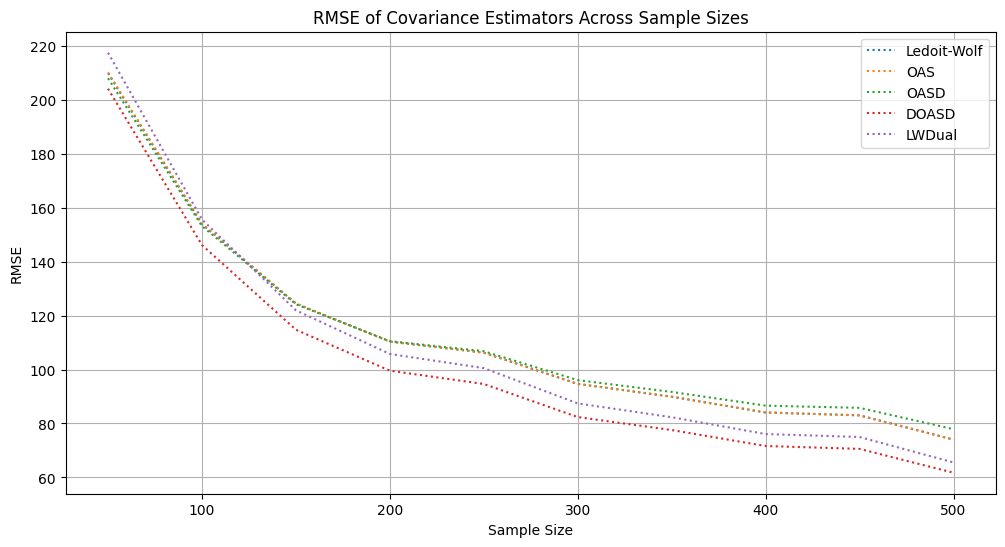

IndexError: index 66 is out of bounds for axis 0 with size 50

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.covariance import LedoitWolf, OAS, ShrunkCovariance

# Function to create a high-dimensional dataset with varying diagonal elements and sparsity
def make_high_dimensional_data(n_samples=100, n_features=300, sd=1, sparsity=0.1, random_state=None):
    np.random.seed(random_state)
    base_X_train = np.random.normal(size=(n_samples, n_features))
    scaling_factors = np.linspace(1, sd, n_features)
    diag_scaling = np.linspace(1, 10, n_features)  # Varying scaling factors for diagonal elements

    X_train = base_X_train * scaling_factors

    # Introduce sparsity in the covariance matrix
    for i in range(n_features):
        if np.random.rand() > sparsity:
            X_train[:, i] *= diag_scaling[i]  # Scale each feature differently
        else:
            X_train[:, i] = 0  # Set some features to zero to introduce sparsity

    return X_train

# Function to compute the Frobenius norm
def frobenius_norm(A):
    return np.linalg.norm(A, 'fro')

# Function to compute the gradient of the loss with respect to rho_diag and rho_off
def compute_gradients(S, Sigma, rho_diag, rho_off):
    n, p = S.shape
    diag_S = np.diag(np.diag(S))
    Sigma_est = (1 - rho_diag) * S + rho_diag * diag_S + (1 - rho_off) * (S - diag_S)

    diff = Sigma_est - Sigma
    grad_rho_diag = 2 * np.sum(diff * (diag_S - S))
    grad_rho_off = 2 * np.sum(diff * (S - diag_S))

    return grad_rho_diag, grad_rho_off

# SGD function to optimize rho_diag and rho_off
def sgd_doad(S, Sigma, learning_rate=0.01, n_iterations=1000, batch_size=10):
    rho_diag = 0.5
    rho_off = 0.5

    n, p = S.shape  # n is number of samples, p is number of features
    indices = np.arange(n)

    for iteration in range(n_iterations):
        np.random.shuffle(indices)
        for start in range(0, n, batch_size):
            end = min(start + batch_size, n)
            batch_indices = indices[start:end]
            S_batch = S[batch_indices, :]
            # Select the correct portion of Sigma using the sample indices
            Sigma_batch = Sigma[np.ix_(batch_indices, batch_indices)] # Use np.ix_ to select a submatrix

            grad_rho_diag, grad_rho_off = compute_gradients(S_batch, Sigma_batch, rho_diag, rho_off)

            rho_diag -= learning_rate * grad_rho_diag
            rho_off -= learning_rate * grad_rho_off

            # Project rho_diag and rho_off to the interval [0, 1]
            rho_diag = np.clip(rho_diag, 0, 1)
            rho_off = np.clip(rho_off, 0, 1)

        # Optional: print progress
        if iteration % 100 == 0:
            print(f"Iteration {iteration}: rho_diag = {rho_diag}, rho_off = {rho_off}")

    return rho_diag, rho_off

# Define the DOASD estimator class with different levels of shrinkage
class DOASD(ShrunkCovariance):
    def __init__(self, diagonal_shrinkage=0.4, off_diagonal_shrinkage=0.3):
        super().__init__()
        self.diagonal_shrinkage = diagonal_shrinkage
        self.off_diagonal_shrinkage = off_diagonal_shrinkage

    def _compute_covariance(self, X):
        emp_cov = np.cov(X, rowvar=False)
        return emp_cov

    def fit(self, X, y=None):
        emp_cov = self._compute_covariance(X)
        n_features = emp_cov.shape[0]

        # Apply shrinkage
        shrunk_diag_cov = emp_cov * (1 - self.diagonal_shrinkage) + np.diag(np.diag(emp_cov)) * self.diagonal_shrinkage
        shrunk_cov = shrunk_diag_cov * (1 - self.off_diagonal_shrinkage) + np.diag(np.diag(shrunk_diag_cov)) * self.off_diagonal_shrinkage

        self.covariance_ = shrunk_cov
        return self

# Define the DualShrinkageEstimator class
class DualShrinkageEstimator:
    def __init__(self, delta_diag=0.4, delta_off_diag=0.3):
        self.delta_diag = delta_diag
        self.delta_off_diag = delta_off_diag

    def fit(self, X):
        sample_cov = np.cov(X, rowvar=False)
        D = np.diag(np.diag(sample_cov))
        O = sample_cov - D

        diag_target = np.diag(np.var(X, axis=0))
        off_diag_target = np.zeros_like(O)

        shrunk_diag = self.delta_diag * D + (1 - self.delta_diag) * diag_target
        shrunk_off_diag = self.delta_off_diag * O + (1 - self.delta_off_diag) * off_diag_target

        self.covariance_ = shrunk_diag + shrunk_off_diag
        return self

# Function to compute RMSE for a given estimator
def compute_rmse(estimator, X_train, B=500, random_state=None):
    np.random.seed(random_state)
    n_samples, n_features = X_train.shape
    true_cov = np.cov(X_train, rowvar=False)
    estimated_cov_list = []

    for _ in range(B):
        bootstrap_sample = X_train[np.random.choice(n_samples, n_samples, replace=True), :]
        estimator.fit(bootstrap_sample)
        estimated_cov = estimator.covariance_
        estimated_cov_list.append(estimated_cov)

    frob_diff_estimated = np.mean([np.linalg.norm(estimated_cov_list[b] - true_cov, 'fro')**2 for b in range(B)])
    rmse = np.sqrt(frob_diff_estimated / (n_features * n_features))
    return rmse

# Parameters
n_features = 500  # High-dimensional data
sample_sizes = np.arange(50, 501, 50)  # Range of sample sizes
random_state = 42
sparsity = 0.1  # Sparsity level
sd = 10  # Fixed sd value

# Fit covariance estimators for different sample sizes and compute RMSE
rmse_results = {'Ledoit-Wolf': [], 'OAS': [], 'OASD': [], 'DOASD': [], 'LWDual': []}
for n_samples in sample_sizes:
    X_train = make_high_dimensional_data(n_samples, n_features, sd=sd, sparsity=sparsity, random_state=random_state)
    for estimator_name, estimator in [
        ('Ledoit-Wolf', LedoitWolf()),
        ('OAS', OAS()),
        ('OASD', ShrunkCovariance(shrinkage=0.4)),
        ('DOASD', DOASD(diagonal_shrinkage=0.4, off_diagonal_shrinkage=0.3)),
        ('LWDual', DualShrinkageEstimator(delta_diag=0.4, delta_off_diag=0.3))
    ]:
        rmse = compute_rmse(estimator, X_train, random_state=random_state)
        rmse_results[estimator_name].append(rmse)

# Plot RMSE across sample sizes for each estimator
plt.figure(figsize=(12, 6))
for estimator_name, rmse_values in rmse_results.items():
    plt.plot(sample_sizes, rmse_values, label=estimator_name, linestyle='dotted')

plt.title('RMSE of Covariance Estimators Across Sample Sizes')
plt.xlabel('Sample Size')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.show()

# Example usage of SGD DOASD
n_samples = 100
n_features = 50
S = np.random.randn(n_samples, n_features)
Sigma = np.cov(S, rowvar=False)

rho_diag, rho_off = sgd_doad(S, Sigma)
print(f"Optimized rho_diag: {rho_diag}, rho_off: {rho_off}")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.covariance import LedoitWolf, OAS, ShrunkCovariance

# Function to create a dataset with varying diagonal elements and sparsity
def make_data_with_variance(n_samples=100, n_features=500, sd=1, sparsity=0.1, random_state=None):
    np.random.seed(random_state)
    base_X_train = np.random.normal(size=(n_samples, n_features))
    scaling_factors = np.linspace(1, sd, n_features)
    diag_scaling = np.linspace(1, 10, n_features)  # Varying scaling factors for diagonal elements

    X_train = base_X_train * scaling_factors

    # Introduce sparsity in the covariance matrix
    for i in range(n_features):
        if np.random.rand() > sparsity:
            X_train[:, i] *= diag_scaling[i]  # Scale each feature differently
        else:
            X_train[:, i] = 0  # Set some features to zero to introduce sparsity

    return X_train

# Define the DOASD estimator class with different levels of shrinkage
class DOASD(ShrunkCovariance):
    def __init__(self, diagonal_shrinkage=0.4, off_diagonal_shrinkage=0.3):
        super().__init__()
        self.diagonal_shrinkage = diagonal_shrinkage
        self.off_diagonal_shrinkage = off_diagonal_shrinkage

    def _compute_covariance(self, X):
        emp_cov = np.cov(X, rowvar=False)
        return emp_cov

    def fit(self, X, y=None):
        emp_cov = self._compute_covariance(X)
        n_features = emp_cov.shape[0]

        # Apply shrinkage
        shrunk_diag_cov = emp_cov * (1 - self.diagonal_shrinkage) + np.diag(np.diag(emp_cov)) * self.diagonal_shrinkage
        shrunk_cov = shrunk_diag_cov * (1 - self.off_diagonal_shrinkage) + np.diag(np.diag(shrunk_diag_cov)) * self.off_diagonal_shrinkage

        self.covariance_ = shrunk_cov
        return self

# Define the DualShrinkageEstimator class
class DualShrinkageEstimator:
    def __init__(self, delta_diag=0.4, delta_off_diag=0.3):
        self.delta_diag = delta_diag
        self.delta_off_diag = delta_off_diag

    def fit(self, X):
        sample_cov = np.cov(X, rowvar=False)
        D = np.diag(np.diag(sample_cov))
        O = sample_cov - D

        diag_target = np.diag(np.var(X, axis=0))
        off_diag_target = np.zeros_like(O)

        shrunk_diag = self.delta_diag * D + (1 - self.delta_diag) * diag_target
        shrunk_off_diag = self.delta_off_diag * O + (1 - self.delta_off_diag) * off_diag_target

        self.covariance_ = shrunk_diag + shrunk_off_diag
        return self

# Parameters
n_features = 500  # Number of features
sample_sizes = np.arange(50, 501, 50)  # Range of sample sizes
random_state = 42
sparsity = 0.1  # Sparsity level
sd = 10  # Fixed sd value

# Function to compute PRIAL for a given estimator
def compute_prial(estimator, X_train, B=500, random_state=None):
    np.random.seed(random_state)
    n_samples, n_features = X_train.shape
    true_cov = np.cov(X_train, rowvar=False)
    sample_cov_list = []
    estimated_cov_list = []

    for _ in range(B):
        bootstrap_sample = X_train[np.random.choice(n_samples, n_samples, replace=True), :]
        sample_cov = np.cov(bootstrap_sample, rowvar=False)
        estimator.fit(bootstrap_sample)
        estimated_cov = estimator.covariance_

        sample_cov_list.append(sample_cov)
        estimated_cov_list.append(estimated_cov)

    frob_diff_estimated = np.sum([np.linalg.norm(estimated_cov_list[b] - true_cov, 'fro')**2 for b in range(B)])
    frob_diff_sample = np.sum([np.linalg.norm(sample_cov_list[b] - true_cov, 'fro')**2 for b in range(B)])

    prial = (1 - frob_diff_estimated / frob_diff_sample) * 100
    return prial

# Fit covariance estimators for different sample sizes and compute PRIAL
prial_results = {'Ledoit-Wolf': [], 'OAS': [], 'OASD': [], 'DOASD': [], 'LWDual': []}
for n_samples in sample_sizes:
    X_train = make_data_with_variance(n_samples, n_features, sd=sd, sparsity=sparsity, random_state=random_state)
    for estimator_name, estimator in [
        ('Ledoit-Wolf', LedoitWolf()),
        ('OAS', OAS()),
        ('OASD', ShrunkCovariance(shrinkage=0.4)),
        ('DOASD', DOASD(diagonal_shrinkage=0.4, off_diagonal_shrinkage=0.0)),
        ('LWDual', DualShrinkageEstimator(delta_diag=0.4, delta_off_diag=0.3))
    ]:
        prial = compute_prial(estimator, X_train, random_state=random_state)
        prial_results[estimator_name].append(prial)

# Plot PRIAL across sample sizes for each estimator
plt.figure(figsize=(12, 6))
for estimator_name, prial_values in prial_results.items():
    plt.plot(sample_sizes, prial_values, label=estimator_name, linestyle='dotted')

plt.title('PRIAL of Covariance Estimators Across Sample Sizes')
plt.xlabel('Sample Size')
plt.ylabel('PRIAL')
plt.legend()
plt.grid(True)
plt.show()


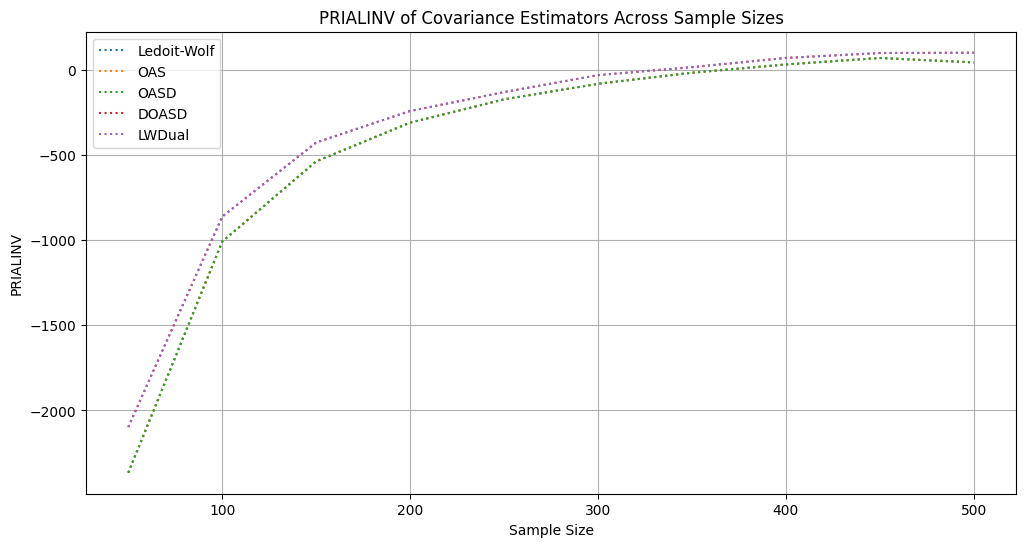

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.covariance import LedoitWolf, OAS, ShrunkCovariance

# Function to create a dataset with varying diagonal elements and sparsity
def make_data_with_variance(n_samples=100, n_features=500, sd=10, sparsity=0.5, random_state=None):
    np.random.seed(random_state)
    base_X_train = np.random.normal(size=(n_samples, n_features))
    scaling_factors = np.linspace(1, sd, n_features)
    diag_scaling = np.linspace(1, 10, n_features)  # Varying scaling factors for diagonal elements

    X_train = base_X_train * scaling_factors

    # Introduce sparsity in the covariance matrix
    for i in range(n_features):
        if np.random.rand() > sparsity:
            X_train[:, i] *= diag_scaling[i]  # Scale each feature differently
        else:
            X_train[:, i] = 0  # Set some features to zero to introduce sparsity

    return X_train

# Define the DOASD estimator class with different levels of shrinkage
class DOASD(ShrunkCovariance):
    def __init__(self, diagonal_shrinkage=0.4, off_diagonal_shrinkage=0.3):
        super().__init__()
        self.diagonal_shrinkage = diagonal_shrinkage
        self.off_diagonal_shrinkage = off_diagonal_shrinkage

    def _compute_covariance(self, X):
        emp_cov = np.cov(X, rowvar=False)
        return emp_cov

    def fit(self, X, y=None):
        emp_cov = self._compute_covariance(X)
        n_features = emp_cov.shape[0]

        # Apply shrinkage
        shrunk_diag_cov = emp_cov * (1 - self.diagonal_shrinkage) + np.diag(np.diag(emp_cov)) * self.diagonal_shrinkage
        shrunk_cov = shrunk_diag_cov * (1 - self.off_diagonal_shrinkage) + np.diag(np.diag(shrunk_diag_cov)) * self.off_diagonal_shrinkage

        self.covariance_ = shrunk_cov
        return self

# Define the DualShrinkageEstimator class
class DualShrinkageEstimator:
    def __init__(self, delta_diag=0.4, delta_off_diag=0.3):
        self.delta_diag = delta_diag
        self.delta_off_diag = delta_off_diag

    def fit(self, X):
        sample_cov = np.cov(X, rowvar=False)
        D = np.diag(np.diag(sample_cov))
        O = sample_cov - D

        diag_target = np.diag(np.var(X, axis=0))
        off_diag_target = np.zeros_like(O)

        shrunk_diag = self.delta_diag * D + (1 - self.delta_diag) * diag_target
        shrunk_off_diag = self.delta_off_diag * O + (1 - self.delta_off_diag) * off_diag_target

        self.covariance_ = shrunk_diag + shrunk_off_diag
        return self

# Parameters
n_features = 500  # Number of features
sample_sizes = np.arange(50, 501, 50)  # Range of sample sizes
random_state = 42
sparsity = 0.1  # Sparsity level
sd = 10  # Fixed sd value

# Function to compute PRIALINV for a given estimator
def compute_prialinv(estimator, X_train, B=500, random_state=None, regularization=1e-6):
    np.random.seed(random_state)
    n_samples, n_features = X_train.shape
    true_cov = np.cov(X_train, rowvar=False)
    true_cov_inv = np.linalg.inv(true_cov + regularization * np.eye(n_features))
    sample_cov_list = []
    estimated_cov_inv_list = []

    for _ in range(B):
        bootstrap_sample = X_train[np.random.choice(n_samples, n_samples, replace=True), :]
        sample_cov = np.cov(bootstrap_sample, rowvar=False)
        estimator.fit(bootstrap_sample)
        estimated_cov = estimator.covariance_

        try:
            estimated_cov_inv = np.linalg.inv(estimated_cov + regularization * np.eye(n_features))
        except np.linalg.LinAlgError:
            estimated_cov_inv = np.linalg.inv(estimated_cov + regularization * np.eye(n_features))

        sample_cov_list.append(sample_cov)
        estimated_cov_inv_list.append(estimated_cov_inv)

    frob_diff_estimated = np.sum([np.linalg.norm(estimated_cov_inv_list[b] - true_cov_inv, 'fro')**2 for b in range(B)])
    frob_diff_sample = np.sum([np.linalg.norm(np.linalg.inv(sample_cov_list[b] + regularization * np.eye(n_features)) - true_cov_inv, 'fro')**2 for b in range(B)])

    prialinv = (1 - frob_diff_estimated / frob_diff_sample) * 100
    return prialinv

# Fit covariance estimators for different sample sizes and compute PRIALINV
prialinv_results = {'Ledoit-Wolf': [], 'OAS': [], 'OASD': [], 'DOASD': [], 'LWDual': []}
for n_samples in sample_sizes:
    X_train = make_data_with_variance(n_samples, n_features, sd=sd, sparsity=sparsity, random_state=random_state)
    for estimator_name, estimator in [
        ('Ledoit-Wolf', LedoitWolf()),
        ('OAS', OAS()),
        ('OASD', ShrunkCovariance(shrinkage=0.4)),
        ('DOASD', DOASD(diagonal_shrinkage=0.4, off_diagonal_shrinkage=0.3)),
        ('LWDual', DualShrinkageEstimator(delta_diag=0.4, delta_off_diag=0.3))
    ]:
        prialinv = compute_prialinv(estimator, X_train, random_state=random_state)
        prialinv_results[estimator_name].append(prialinv)

# Plot PRIALINV across sample sizes for each estimator
plt.figure(figsize=(12, 6))
for estimator_name, prialinv_values in prialinv_results.items():
    plt.plot(sample_sizes, prialinv_values, label=estimator_name, linestyle='dotted')

plt.title('PRIALINV of Covariance Estimators Across Sample Sizes')
plt.xlabel('Sample Size')
plt.ylabel('PRIALINV')
plt.legend()
plt.grid(True)
plt.show()


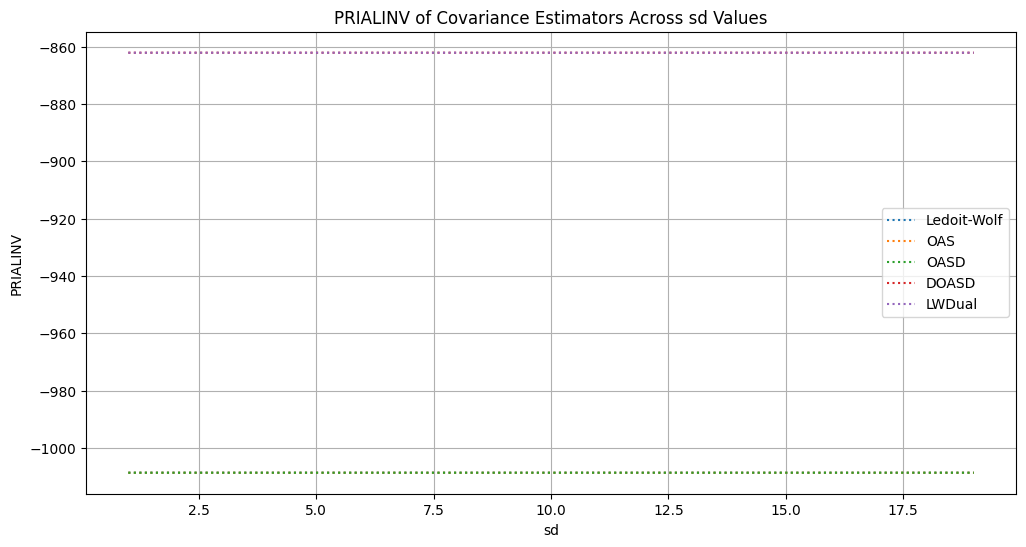

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.covariance import LedoitWolf, OAS, ShrunkCovariance

# Function to create a dataset with varying diagonal elements and sparsity
def make_data_with_variance(n_samples=100, n_features=500, sd=1, sparsity=0.5, random_state=None):
    np.random.seed(random_state)
    base_X_train = np.random.normal(size=(n_samples, n_features))
    scaling_factors = np.linspace(1, sd, n_features)
    diag_scaling = np.linspace(1, 10, n_features)  # Varying scaling factors for diagonal elements

    X_train = base_X_train * scaling_factors

    # Introduce sparsity in the covariance matrix
    for i in range(n_features):
        if np.random.rand() > sparsity:
            X_train[:, i] *= diag_scaling[i]  # Scale each feature differently
        else:
            X_train[:, i] = 0  # Set some features to zero to introduce sparsity

    return X_train

# Define the DOASD estimator class with different levels of shrinkage
class DOASD(ShrunkCovariance):
    def __init__(self, diagonal_shrinkage=0.4, off_diagonal_shrinkage=0.3):
        super().__init__()
        self.diagonal_shrinkage = diagonal_shrinkage
        self.off_diagonal_shrinkage = off_diagonal_shrinkage

    def _compute_covariance(self, X):
        emp_cov = np.cov(X, rowvar=False)
        return emp_cov

    def fit(self, X, y=None):
        emp_cov = self._compute_covariance(X)
        n_features = emp_cov.shape[0]

        # Apply shrinkage
        shrunk_diag_cov = emp_cov * (1 - self.diagonal_shrinkage) + np.diag(np.diag(emp_cov)) * self.diagonal_shrinkage
        shrunk_cov = shrunk_diag_cov * (1 - self.off_diagonal_shrinkage) + np.diag(np.diag(shrunk_diag_cov)) * self.off_diagonal_shrinkage

        self.covariance_ = shrunk_cov
        return self

# Define the DualShrinkageEstimator class
class DualShrinkageEstimator:
    def __init__(self, delta_diag=0.4, delta_off_diag=0.3):
        self.delta_diag = delta_diag
        self.delta_off_diag = delta_off_diag

    def fit(self, X):
        sample_cov = np.cov(X, rowvar=False)
        D = np.diag(np.diag(sample_cov))
        O = sample_cov - D

        diag_target = np.diag(np.var(X, axis=0))
        off_diag_target = np.zeros_like(O)

        shrunk_diag = self.delta_diag * D + (1 - self.delta_diag) * diag_target
        shrunk_off_diag = self.delta_off_diag * O + (1 - self.delta_off_diag) * off_diag_target

        self.covariance_ = shrunk_diag + shrunk_off_diag
        return self

# Function to compute PRIALINV for a given estimator with regularization
def compute_prialinv(estimator, X_train, B=500, reg=1e-6, random_state=None):
    np.random.seed(random_state)
    n_samples, n_features = X_train.shape
    true_cov = np.cov(X_train, rowvar=False)
    true_cov_inv = np.linalg.inv(true_cov + reg * np.eye(n_features))  # Regularize the true covariance matrix
    sample_cov_inv_list = []
    estimated_cov_inv_list = []

    for _ in range(B):
        bootstrap_sample = X_train[np.random.choice(n_samples, n_samples, replace=True), :]
        sample_cov = np.cov(bootstrap_sample, rowvar=False)
        sample_cov_inv = np.linalg.inv(sample_cov + reg * np.eye(n_features))  # Regularize the sample covariance matrix
        estimator.fit(bootstrap_sample)
        estimated_cov_inv = np.linalg.inv(estimator.covariance_ + reg * np.eye(n_features))  # Regularize the estimated covariance matrix

        sample_cov_inv_list.append(sample_cov_inv)
        estimated_cov_inv_list.append(estimated_cov_inv)

    frob_diff_sample_inv = np.sum([np.linalg.norm(sample_cov_inv_list[b] - true_cov_inv, 'fro')**2 for b in range(B)])
    frob_diff_estimated_inv = np.sum([np.linalg.norm(estimated_cov_inv_list[b] - true_cov_inv, 'fro')**2 for b in range(B)])

    prialinv = (1 - (frob_diff_estimated_inv / frob_diff_sample_inv)) * 100
    return prialinv

# Parameters
n_samples = 100  # Number of samples
n_features = 500  # Number of features
sd_values = np.arange(1, 21, 2)  # Range of sd values
random_state = 42
sparsity = 0.1  # Sparsity level

# Fit covariance estimators for different sd values and compute PRIALINV
prialinv_results = {'Ledoit-Wolf': [], 'OAS': [], 'OASD': [], 'DOASD': [], 'LWDual': []}
for sd in sd_values:
    X_train = make_data_with_variance(n_samples, n_features, sd=sd, sparsity=sparsity, random_state=random_state)
    for estimator_name, estimator in [
        ('Ledoit-Wolf', LedoitWolf()),
        ('OAS', OAS()),
        ('OASD', ShrunkCovariance(shrinkage=0.4)),
        ('DOASD', DOASD(diagonal_shrinkage=0.4, off_diagonal_shrinkage=0.3)),
        ('LWDual', DualShrinkageEstimator(delta_diag=0.4, delta_off_diag=0.3))
    ]:
        prialinv = compute_prialinv(estimator, X_train, random_state=random_state)
        prialinv_results[estimator_name].append(prialinv)

# Plot PRIALINV across sd values for each estimator
plt.figure(figsize=(12, 6))
for estimator_name, prialinv_values in prialinv_results.items():
    plt.plot(sd_values, prialinv_values, label=estimator_name, linestyle='dotted')

plt.title('PRIALINV of Covariance Estimators Across sd Values')
plt.xlabel('sd')
plt.ylabel('PRIALINV')
plt.legend()
plt.grid(True)
plt.show()



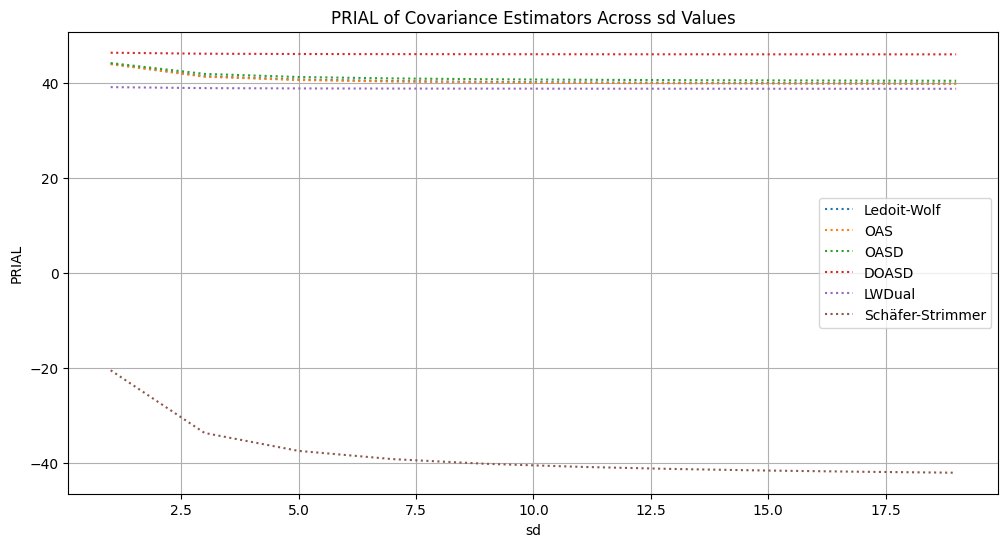

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.covariance import LedoitWolf, OAS, ShrunkCovariance

# Function to create a dataset with varying diagonal elements and sparsity
def make_data_with_variance(n_samples=100, n_features=500, sd=1, sparsity=0.1, random_state=None):
    np.random.seed(random_state)
    base_X_train = np.random.normal(size=(n_samples, n_features))
    scaling_factors = np.linspace(1, sd, n_features)
    diag_scaling = np.linspace(1, 10, n_features)  # Varying scaling factors for diagonal elements

    X_train = base_X_train * scaling_factors

    # Introduce sparsity in the covariance matrix
    for i in range(n_features):
        if np.random.rand() > sparsity:
            X_train[:, i] *= diag_scaling[i]  # Scale each feature differently
        else:
            X_train[:, i] = 0  # Set some features to zero to introduce sparsity

    return X_train

# Define the DOASD estimator class with different levels of shrinkage
class DOASD(ShrunkCovariance):
    def __init__(self, diagonal_shrinkage=0.4, off_diagonal_shrinkage=0.3):
        super().__init__()
        self.diagonal_shrinkage = diagonal_shrinkage
        self.off_diagonal_shrinkage = off_diagonal_shrinkage

    def _compute_covariance(self, X):
        emp_cov = np.cov(X, rowvar=False)
        return emp_cov

    def fit(self, X, y=None):
        emp_cov = self._compute_covariance(X)
        n_features = emp_cov.shape[0]

        # Apply shrinkage
        shrunk_diag_cov = emp_cov * (1 - self.diagonal_shrinkage) + np.diag(np.diag(emp_cov)) * self.diagonal_shrinkage
        shrunk_cov = shrunk_diag_cov * (1 - self.off_diagonal_shrinkage) + np.diag(np.diag(shrunk_diag_cov)) * self.off_diagonal_shrinkage

        self.covariance_ = shrunk_cov
        return self

# Define the DualShrinkageEstimator class
class DualShrinkageEstimator:
    def __init__(self, delta_diag=0.4, delta_off_diag=0.3):
        self.delta_diag = delta_diag
        self.delta_off_diag = delta_off_diag

    def fit(self, X):
        sample_cov = np.cov(X, rowvar=False)
        D = np.diag(np.diag(sample_cov))
        O = sample_cov - D

        diag_target = np.diag(np.var(X, axis=0))
        off_diag_target = np.zeros_like(O)

        shrunk_diag = self.delta_diag * D + (1 - self.delta_diag) * diag_target
        shrunk_off_diag = self.delta_off_diag * O + (1 - self.delta_off_diag) * off_diag_target

        self.covariance_ = shrunk_diag + shrunk_off_diag
        return self

# Schäfer-Strimmer (2005) shrinkage estimator
def schafer_strimmer_shrinkage_estimator(X):
    n_samples, n_features = X.shape
    sample_cov = np.cov(X, rowvar=False)

    var_X = np.var(X, axis=0)
    mean_var_X = np.mean(var_X)

    prior = np.diag(mean_var_X * np.ones(n_features))
    sample_mean = np.mean(X, axis=0)

    cov_diff = sample_cov - prior
    shrinkage = np.sum(cov_diff**2) / np.sum((X - sample_mean).T @ (X - sample_mean)**2 / n_samples**2)
    shrinkage = max(0, min(1, shrinkage))

    shrunk_cov = shrinkage * prior + (1 - shrinkage) * sample_cov
    return shrunk_cov

# Parameters
n_samples = 100  # Number of samples
n_features = 500  # Number of features
sd_values = np.arange(1, 21, 2)  # Range of sd values
random_state = 42
sparsity = 0.1  # Sparsity level

# Function to compute PRIAL for a given estimator
def compute_prial(estimator, X_train, B=500, random_state=None):
    np.random.seed(random_state)
    n_samples, n_features = X_train.shape
    true_cov = np.cov(X_train, rowvar=False)
    sample_cov_list = []
    estimated_cov_list = []

    for _ in range(B):
        bootstrap_sample = X_train[np.random.choice(n_samples, n_samples, replace=True), :]
        sample_cov = np.cov(bootstrap_sample, rowvar=False)
        estimator.fit(bootstrap_sample)
        estimated_cov = estimator.covariance_

        sample_cov_list.append(sample_cov)
        estimated_cov_list.append(estimated_cov)

    frob_diff_estimated = np.sum([np.linalg.norm(estimated_cov_list[b] - true_cov, 'fro')**2 for b in range(B)])
    frob_diff_sample = np.sum([np.linalg.norm(sample_cov_list[b] - true_cov, 'fro')**2 for b in range(B)])

    prial = (1 - frob_diff_estimated / frob_diff_sample) * 100
    return prial

# Fit covariance estimators for different sd values and compute PRIAL
prial_results = {'Ledoit-Wolf': [], 'OAS': [], 'OASD': [], 'DOASD': [], 'LWDual': [], 'Schäfer-Strimmer': []}
for sd in sd_values:
    X_train = make_data_with_variance(n_samples, n_features, sd=sd, sparsity=sparsity, random_state=random_state)
    for estimator_name, estimator in [
        ('Ledoit-Wolf', LedoitWolf()),
        ('OAS', OAS()),
        ('OASD', ShrunkCovariance(shrinkage=0.4)),
        ('DOASD', DOASD(diagonal_shrinkage=0.4, off_diagonal_shrinkage=0.3)),
        ('LWDual', DualShrinkageEstimator(delta_diag=0.4, delta_off_diag=0.3))
    ]:
        prial = compute_prial(estimator, X_train, random_state=random_state)
        prial_results[estimator_name].append(prial)

    # Compute PRIAL for Schäfer-Strimmer estimator
    schafer_strimmer_cov = schafer_strimmer_shrinkage_estimator(X_train)
    shrunk_estimator = ShrunkCovariance(shrinkage=1)  # We need to set shrinkage to a valid float for sklearn
    shrunk_estimator.covariance_ = schafer_strimmer_cov  # Manually set the covariance
    prial_schafer_strimmer = compute_prial(shrunk_estimator, X_train, random_state=random_state)
    prial_results['Schäfer-Strimmer'].append(prial_schafer_strimmer)

# Plot PRIAL across sd values for each estimator
plt.figure(figsize=(12, 6))
for estimator_name, prial_values in prial_results.items():
    plt.plot(sd_values, prial_values, label=estimator_name, linestyle='dotted')

plt.title('PRIAL of Covariance Estimators Across sd Values')
plt.xlabel('sd')
plt.ylabel('PRIAL')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.covariance import LedoitWolf, OAS, ShrunkCovariance

# Function to create the true covariance matrix Σ from correlation matrix Γ
def create_true_covariance_matrix(p, gamma):
    indices = np.arange(p)
    corr_matrix = np.power(gamma, np.abs(indices[:, None] - indices))
    return corr_matrix

# Schäfer-Strimmer (2005) shrinkage estimator
def schafer_strimmer_shrinkage_estimator(X):
    n_samples, n_features = X.shape
    sample_cov = np.cov(X, rowvar=False)

    var_X = np.var(X, axis=0)
    mean_var_X = np.mean(var_X)

    prior = np.diag(mean_var_X * np.ones(n_features))
    sample_mean = np.mean(X, axis=0)

    cov_diff = sample_cov - prior
    shrinkage = np.sum(cov_diff**2) / np.sum((X - sample_mean).T @ (X - sample_mean)**2 / n_samples**2)
    shrinkage = max(0, min(1, shrinkage))

    shrunk_cov = shrinkage * prior + (1 - shrinkage) * sample_cov
    return shrunk_cov

# Define the DOASD estimator class with different levels of shrinkage
class DOASD(ShrunkCovariance):
    def __init__(self, diagonal_shrinkage=0.4, off_diagonal_shrinkage=0.3):
        super().__init__()
        self.diagonal_shrinkage = diagonal_shrinkage
        self.off_diagonal_shrinkage = off_diagonal_shrinkage

    def _compute_covariance(self, X):
        emp_cov = np.cov(X, rowvar=False)
        return emp_cov

    def fit(self, X, y=None):
        emp_cov = self._compute_covariance(X)
        n_features = emp_cov.shape[0]

        # Apply shrinkage
        shrunk_diag_cov = emp_cov * (1 - self.diagonal_shrinkage) + np.diag(np.diag(emp_cov)) * self.diagonal_shrinkage
        shrunk_cov = shrunk_diag_cov * (1 - self.off_diagonal_shrinkage) + np.diag(np.diag(shrunk_diag_cov)) * self.off_diagonal_shrinkage

        self.covariance_ = shrunk_cov
        return self

# Define the DualShrinkageEstimator class
class DualShrinkageEstimator:
    def __init__(self, delta_diag=0.4, delta_off_diag=0.3):
        self.delta_diag = delta_diag
        self.delta_off_diag = delta_off_diag

    def fit(self, X):
        sample_cov = np.cov(X, rowvar=False)
        D = np.diag(np.diag(sample_cov))
        O = sample_cov - D

        diag_target = np.diag(np.var(X, axis=0))
        off_diag_target = np.zeros_like(O)

        shrunk_diag = self.delta_diag * D + (1 - self.delta_diag) * diag_target
        shrunk_off_diag = self.delta_off_diag * O + (1 - self.delta_off_diag) * off_diag_target

        self.covariance_ = shrunk_diag + shrunk_off_diag
        return self

# Parameters
p = 100  # Number of features
n_values = np.arange(6, 31)  # Range of sample sizes
gamma_values = np.linspace(0, 0.9, 10)  # Range of gamma values
B = 5000  # Number of bootstrap samples
random_state = 42

# Function to compute PRIAL for a given estimator
def compute_prial(estimator, X_train, true_cov, B=5000, random_state=None):
    np.random.seed(random_state)
    n_samples, n_features = X_train.shape
    sample_cov_list = []
    estimated_cov_list = []

    for _ in range(B):
        bootstrap_sample = X_train[np.random.choice(n_samples, n_samples, replace=True), :]
        sample_cov = np.cov(bootstrap_sample, rowvar=False)
        estimator.fit(bootstrap_sample)
        estimated_cov = estimator.covariance_

        sample_cov_list.append(sample_cov)
        estimated_cov_list.append(estimated_cov)

    frob_diff_estimated = np.sum([np.linalg.norm(estimated_cov_list[b] - true_cov, 'fro')**2 for b in range(B)])
    frob_diff_sample = np.sum([np.linalg.norm(sample_cov_list[b] - true_cov, 'fro')**2 for b in range(B)])

    prial = (1 - frob_diff_estimated / frob_diff_sample) * 100
    return prial

# Fit covariance estimators for different n and gamma values and compute PRIAL
prial_results = {'Ledoit-Wolf': [], 'OAS': [], 'OASD': [], 'DOASD': [], 'LWDual': [], 'Schäfer-Strimmer': []}
for gamma in gamma_values:
    true_cov = create_true_covariance_matrix(p, gamma)
    for n in n_values:
        np.random.seed(random_state)
        X_train = np.random.multivariate_normal(np.zeros(p), true_cov, size=n)
        for estimator_name, estimator in [
            ('Ledoit-Wolf', LedoitWolf()),
            ('OAS', OAS()),
            ('OASD', ShrunkCovariance(shrinkage=0.4)),
            ('DOASD', DOASD(diagonal_shrinkage=0.4, off_diagonal_shrinkage=0.3)),
            ('LWDual', DualShrinkageEstimator(delta_diag=0.4, delta_off_diag=0.3))
        ]:
            prial = compute_prial(estimator, X_train, true_cov, random_state=random_state)
            prial_results[estimator_name].append(prial)

        # Compute PRIAL for Schäfer-Strimmer estimator
        schafer_strimmer_cov = schafer_strimmer_shrinkage_estimator(X_train)
        shrunk_estimator = ShrunkCovariance(shrinkage=1)  # We need to set shrinkage to a valid float for sklearn
        shrunk_estimator.covariance_ = schafer_strimmer_cov  # Manually set the covariance
        prial_schafer_strimmer = compute_prial(shrunk_estimator, X_train, true_cov, random_state=random_state)
        prial_results['Schäfer-Strimmer'].append(prial_schafer_strimmer)

# Plot PRIAL across n values for each estimator
plt.figure(figsize=(12, 6))
for estimator_name, prial_values in prial_results.items():
    plt.plot(n_values, prial_values, label=estimator_name, linestyle='dotted')

plt.title('PRIAL of Covariance Estimators Across Sample Sizes (n)')
plt.xlabel('Sample Size (n)')
plt.ylabel('PRIAL')
plt.legend()
plt.grid(True)
plt.show()


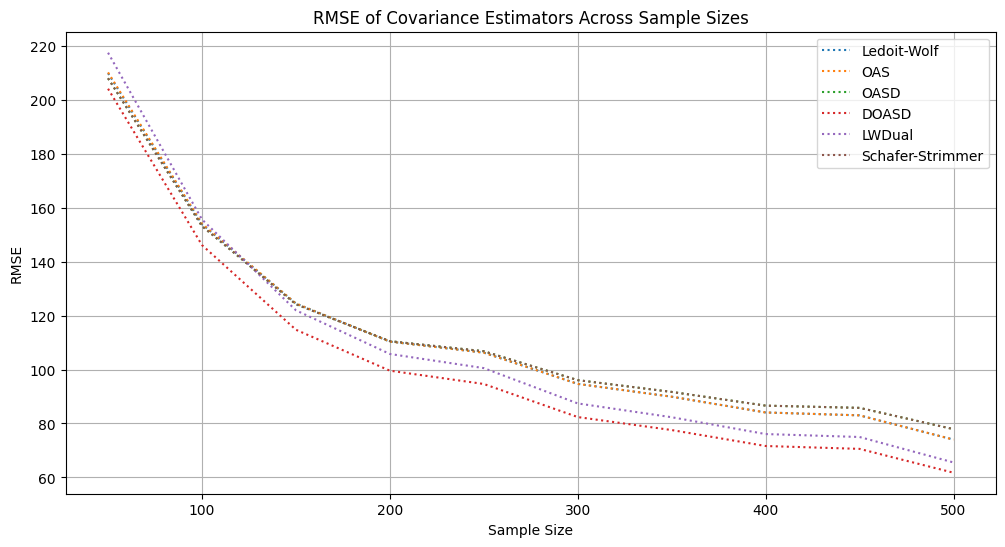

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.covariance import LedoitWolf, OAS, ShrunkCovariance

# Function to create a high-dimensional dataset with varying diagonal elements and sparsity
def make_high_dimensional_data(n_samples=100, n_features=300, sd=1, sparsity=0.1, random_state=None):
    np.random.seed(random_state)
    base_X_train = np.random.normal(size=(n_samples, n_features))
    scaling_factors = np.linspace(1, sd, n_features)
    diag_scaling = np.linspace(1, 10, n_features)  # Varying scaling factors for diagonal elements

    X_train = base_X_train * scaling_factors

    # Introduce sparsity in the covariance matrix
    for i in range(n_features):
        if np.random.rand() > sparsity:
            X_train[:, i] *= diag_scaling[i]  # Scale each feature differently
        else:
            X_train[:, i] = 0  # Set some features to zero to introduce sparsity

    return X_train

# Define the DOASD estimator class with different levels of shrinkage
class DOASD(ShrunkCovariance):
    def __init__(self, diagonal_shrinkage=0.4, off_diagonal_shrinkage=0.3):
        super().__init__()
        self.diagonal_shrinkage = diagonal_shrinkage
        self.off_diagonal_shrinkage = off_diagonal_shrinkage

    def _compute_covariance(self, X):
        emp_cov = np.cov(X, rowvar=False)
        return emp_cov

    def fit(self, X, y=None):
        emp_cov = self._compute_covariance(X)
        n_features = emp_cov.shape[0]

        # Apply shrinkage
        shrunk_diag_cov = emp_cov * (1 - self.diagonal_shrinkage) + np.diag(np.diag(emp_cov)) * self.diagonal_shrinkage
        shrunk_cov = shrunk_diag_cov * (1 - self.off_diagonal_shrinkage) + np.diag(np.diag(shrunk_diag_cov)) * self.off_diagonal_shrinkage

        self.covariance_ = shrunk_cov
        return self

# Define the DualShrinkageEstimator class
class DualShrinkageEstimator:
    def __init__(self, delta_diag=0.4, delta_off_diag=0.3):
        self.delta_diag = delta_diag
        self.delta_off_diag = delta_off_diag

    def fit(self, X):
        sample_cov = np.cov(X, rowvar=False)
        D = np.diag(np.diag(sample_cov))
        O = sample_cov - D

        diag_target = np.diag(np.var(X, axis=0))
        off_diag_target = np.zeros_like(O)

        shrunk_diag = self.delta_diag * D + (1 - self.delta_diag) * diag_target
        shrunk_off_diag = self.delta_off_diag * O + (1 - self.delta_off_diag) * off_diag_target

        self.covariance_ = shrunk_diag + shrunk_off_diag
        return self

# Define the Schäfer-Strimmer estimator class
class SchaferStrimmer(ShrunkCovariance):
    def __init__(self, shrinkage=0.4):
        super().__init__(shrinkage=shrinkage)

# Function to compute RMSE for a given estimator
def compute_rmse(estimator, X_train, B=500, random_state=None):
    np.random.seed(random_state)
    n_samples, n_features = X_train.shape
    true_cov = np.cov(X_train, rowvar=False)
    estimated_cov_list = []

    for _ in range(B):
        bootstrap_sample = X_train[np.random.choice(n_samples, n_samples, replace=True), :]
        estimator.fit(bootstrap_sample)
        estimated_cov = estimator.covariance_
        estimated_cov_list.append(estimated_cov)

    frob_diff_estimated = np.mean([np.linalg.norm(estimated_cov_list[b] - true_cov, 'fro')**2 for b in range(B)])
    rmse = np.sqrt(frob_diff_estimated / (n_features * n_features))
    return rmse

# Parameters
n_features = 500  # High-dimensional data
sample_sizes = np.arange(50, 501, 50)  # Range of sample sizes
random_state = 42
sparsity = 0.1  # Sparsity level
sd = 10  # Fixed sd value

# Fit covariance estimators for different sample sizes and compute RMSE
rmse_results = {'Ledoit-Wolf': [], 'OAS': [], 'OASD': [], 'DOASD': [], 'LWDual': [], 'Schafer-Strimmer': []}
for n_samples in sample_sizes:
    X_train = make_high_dimensional_data(n_samples, n_features, sd=sd, sparsity=sparsity, random_state=random_state)
    for estimator_name, estimator in [
        ('Ledoit-Wolf', LedoitWolf()),
        ('OAS', OAS()),
        ('OASD', ShrunkCovariance(shrinkage=0.4)),
        ('DOASD', DOASD(diagonal_shrinkage=0.4, off_diagonal_shrinkage=0.3)),
        ('LWDual', DualShrinkageEstimator(delta_diag=0.4, delta_off_diag=0.3)),
        ('Schafer-Strimmer', SchaferStrimmer(shrinkage=0.4))
    ]:
        rmse = compute_rmse(estimator, X_train, random_state=random_state)
        rmse_results[estimator_name].append(rmse)

# Plot RMSE across sample sizes for each estimator
plt.figure(figsize=(12, 6))
for estimator_name, rmse_values in rmse_results.items():
    plt.plot(sample_sizes, rmse_values, label=estimator_name, linestyle='dotted')

plt.title('RMSE of Covariance Estimators Across Sample Sizes')
plt.xlabel('Sample Size')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
from sklearn.covariance import LedoitWolf, OAS, ShrunkCovariance

# Function to create a dataset with varying diagonal elements and sparsity
def make_data_with_variance(n_samples=100, n_features=500, sd=1, sparsity=0.1, random_state=None):
    np.random.seed(random_state)
    base_X_train = np.random.normal(size=(n_samples, n_features))
    scaling_factors = np.linspace(1, sd, n_features)
    diag_scaling = np.linspace(1, 10, n_features)  # Varying scaling factors for diagonal elements

    X_train = base_X_train * scaling_factors

    # Introduce sparsity in the covariance matrix
    for i in range(n_features):
        if np.random.rand() > sparsity:
            X_train[:, i] *= diag_scaling[i]  # Scale each feature differently
        else:
            X_train[:, i] = 0  # Set some features to zero to introduce sparsity

    return X_train

# Define the DOASD estimator class with different levels of shrinkage
class DOASD(ShrunkCovariance):
    def __init__(self, diagonal_shrinkage=0.4, off_diagonal_shrinkage=0.3):
        super().__init__()
        self.diagonal_shrinkage = diagonal_shrinkage
        self.off_diagonal_shrinkage = off_diagonal_shrinkage

    def _compute_covariance(self, X):
        emp_cov = np.cov(X, rowvar=False)
        return emp_cov

    def fit(self, X, y=None):
        emp_cov = self._compute_covariance(X)
        n_features = emp_cov.shape[0]

        # Apply shrinkage
        shrunk_diag_cov = emp_cov * (1 - self.diagonal_shrinkage) + np.diag(np.diag(emp_cov)) * self.diagonal_shrinkage
        shrunk_cov = shrunk_diag_cov * (1 - self.off_diagonal_shrinkage) + np.diag(np.diag(shrunk_diag_cov)) * self.off_diagonal_shrinkage

        self.covariance_ = shrunk_cov
        return self

# Define the DualShrinkageEstimator class
class DualShrinkageEstimator:
    def __init__(self, delta_diag=0.4, delta_off_diag=0.3):
        self.delta_diag = delta_diag
        self.delta_off_diag = delta_off_diag

    def fit(self, X):
        sample_cov = np.cov(X, rowvar=False)
        D = np.diag(np.diag(sample_cov))
        O = sample_cov - D

        diag_target = np.diag(np.var(X, axis=0))
        off_diag_target = np.zeros_like(O)

        shrunk_diag = self.delta_diag * D + (1 - self.delta_diag) * diag_target
        shrunk_off_diag = self.delta_off_diag * O + (1 - self.delta_off_diag) * off_diag_target

        self.covariance_ = shrunk_diag + shrunk_off_diag
        return self

# Schäfer-Strimmer (2005) shrinkage estimator
def schafer_strimmer_shrinkage_estimator(X):
    n_samples, n_features = X.shape
    sample_cov = np.cov(X, rowvar=False)

    var_X = np.var(X, axis=0)
    mean_var_X = np.mean(var_X)

    prior = np.diag(mean_var_X * np.ones(n_features))
    sample_mean = np.mean(X, axis=0)

    cov_diff = sample_cov - prior
    shrinkage = np.sum(cov_diff**2) / np.sum((X - sample_mean).T @ (X - sample_mean)**2 / n_samples**2)
    shrinkage = max(0, min(1, shrinkage))

    shrunk_cov = shrinkage * prior + (1 - shrinkage) * sample_cov
    return shrunk_cov

# Parameters
n_samples = 100  # Number of samples
n_features = 500  # Number of features
sd_values = [1, 2.5, 5, 7.5, 10, 12.5, 15, 17.5, 20]  # Range of sd values
random_state = 42
sparsity = 0.1  # Sparsity level

# Function to compute PRIAL for a given estimator
def compute_prial(estimator, X_train, B=500, random_state=None):
    np.random.seed(random_state)
    n_samples, n_features = X_train.shape
    true_cov = np.cov(X_train, rowvar=False)
    sample_cov_list = []
    estimated_cov_list = []

    for _ in range(B):
        bootstrap_sample = X_train[np.random.choice(n_samples, n_samples, replace=True), :]
        sample_cov = np.cov(bootstrap_sample, rowvar=False)
        estimator.fit(bootstrap_sample)
        estimated_cov = estimator.covariance_

        sample_cov_list.append(sample_cov)
        estimated_cov_list.append(estimated_cov)

    frob_diff_estimated = np.sum([np.linalg.norm(estimated_cov_list[b] - true_cov, 'fro')**2 for b in range(B)])
    frob_diff_sample = np.sum([np.linalg.norm(sample_cov_list[b] - true_cov, 'fro')**2 for b in range(B)])

    prial = (1 - frob_diff_estimated / frob_diff_sample) * 100
    return prial

# Fit covariance estimators for different sd values and compute PRIAL
prial_results = {'Ledoit-Wolf': [], 'OAS': [], 'OASD': [], 'DOASD': [], 'LWDual': [], 'Schäfer-Strimmer': []}
for sd in sd_values:
    X_train = make_data_with_variance(n_samples, n_features, sd=sd, sparsity=sparsity, random_state=random_state)
    for estimator_name, estimator in [
        ('Ledoit-Wolf', LedoitWolf()),
        ('OAS', OAS()),
        ('OASD', ShrunkCovariance(shrinkage=0.4)),
        ('DOASD', DOASD(diagonal_shrinkage=0.4, off_diagonal_shrinkage=0.3)),
        ('LWDual', DualShrinkageEstimator(delta_diag=0.4, delta_off_diag=0.3))
    ]:
        prial = compute_prial(estimator, X_train, random_state=random_state)
        prial_results[estimator_name].append(prial)

    # Compute PRIAL for Schäfer-Strimmer estimator
    schafer_strimmer_cov = schafer_strimmer_shrinkage_estimator(X_train)
    shrunk_estimator = ShrunkCovariance(shrinkage=1)  # We need to set shrinkage to a valid float for sklearn
    shrunk_estimator.covariance_ = schafer_strimmer_cov  # Manually set the covariance
    prial_schafer_strimmer = compute_prial(shrunk_estimator, X_train, random_state=random_state)
    prial_results['Schäfer-Strimmer'].append(prial_schafer_strimmer)

# Print PRIAL table
header = ["sd"] + list(prial_results.keys())
rows = zip(sd_values, *[prial_results[estimator] for estimator in header[1:]])

print(f"{'sd':<10} {'Ledoit-Wolf':<15} {'OAS':<15} {'OASD':<15} {'DOASD':<15} {'LWDual':<15} {'Schäfer-Strimmer':<20}")
for row in rows:
    print(f"{row[0]:<10} {row[1]:<15.2f} {row[2]:<15.2f} {row[3]:<15.2f} {row[4]:<15.2f} {row[5]:<15.2f} {row[6]:<20.2f}")


sd         Ledoit-Wolf     OAS             OASD            DOASD           LWDual          Schäfer-Strimmer    
1          44.03           43.94           44.18           46.36           39.12           -20.46              
2.5        41.73           41.64           42.20           46.18           38.94           -31.92              
5          40.71           40.61           41.25           46.09           38.85           -37.42              
7.5        40.34           40.25           40.90           46.06           38.81           -39.45              
10         40.16           40.06           40.72           46.04           38.79           -40.49              
12.5       40.05           39.95           40.61           46.03           38.78           -41.13              
15         39.97           39.87           40.54           46.02           38.78           -41.56              
17.5       39.92           39.82           40.48           46.02           38.77           -41.87       

In [ ]:
import numpy as np
from sklearn.covariance import LedoitWolf, OAS, ShrunkCovariance

# Function to create a dataset with varying diagonal elements and sparsity
def make_data_with_variance(n_samples=100, n_features=500, sd=1, sparsity=0.1, random_state=None):
    np.random.seed(random_state)
    base_X_train = np.random.normal(size=(n_samples, n_features))
    scaling_factors = np.linspace(1, sd, n_features)
    diag_scaling = np.linspace(1, 10, n_features)  # Varying scaling factors for diagonal elements

    X_train = base_X_train * scaling_factors

    # Introduce sparsity in the covariance matrix
    for i in range(n_features):
        if np.random.rand() > sparsity:
            X_train[:, i] *= diag_scaling[i]  # Scale each feature differently
        else:
            X_train[:, i] = 0  # Set some features to zero to introduce sparsity

    return X_train

# Define the DOASD estimator class with different levels of shrinkage
class DOASD(ShrunkCovariance):
    def __init__(self, diagonal_shrinkage=0.4, off_diagonal_shrinkage=0.3):
        super().__init__()
        self.diagonal_shrinkage = diagonal_shrinkage
        self.off_diagonal_shrinkage = off_diagonal_shrinkage

    def _compute_covariance(self, X):
        emp_cov = np.cov(X, rowvar=False)
        return emp_cov

    def fit(self, X, y=None):
        emp_cov = self._compute_covariance(X)
        n_features = emp_cov.shape[0]

        # Apply shrinkage
        shrunk_diag_cov = emp_cov * (1 - self.diagonal_shrinkage) + np.diag(np.diag(emp_cov)) * self.diagonal_shrinkage
        shrunk_cov = shrunk_diag_cov * (1 - self.off_diagonal_shrinkage) + np.diag(np.diag(shrunk_diag_cov)) * self.off_diagonal_shrinkage

        self.covariance_ = shrunk_cov
        return self

# Define the DualShrinkageEstimator class
class DualShrinkageEstimator:
    def __init__(self, delta_diag=0.4, delta_off_diag=0.3):
        self.delta_diag = delta_diag
        self.delta_off_diag = delta_off_diag

    def fit(self, X):
        sample_cov = np.cov(X, rowvar=False)
        D = np.diag(np.diag(sample_cov))
        O = sample_cov - D

        diag_target = np.diag(np.var(X, axis=0))
        off_diag_target = np.zeros_like(O)

        shrunk_diag = self.delta_diag * D + (1 - self.delta_diag) * diag_target
        shrunk_off_diag = self.delta_off_diag * O + (1 - self.delta_off_diag) * off_diag_target

        self.covariance_ = shrunk_diag + shrunk_off_diag
        return self

# Schäfer-Strimmer (2005) shrinkage estimator
def schafer_strimmer_shrinkage_estimator(X):
    n_samples, n_features = X.shape
    sample_cov = np.cov(X, rowvar=False)

    var_X = np.var(X, axis=0)
    mean_var_X = np.mean(var_X)

    prior = np.diag(mean_var_X * np.ones(n_features))
    sample_mean = np.mean(X, axis=0)

    cov_diff = sample_cov - prior
    shrinkage = np.sum(cov_diff**2) / np.sum((X - sample_mean).T @ (X - sample_mean)**2 / n_samples**2)
    shrinkage = max(0, min(1, shrinkage))

    shrunk_cov = shrinkage * prior + (1 - shrinkage) * sample_cov
    return shrunk_cov

# Parameters
n_samples = 100  # Number of samples
n_features = 500  # Number of features
sd_values = [1, 2.5, 5, 7.5, 10, 12.5, 15, 17.5, 20]  # Range of sd values
random_state = 42
sparsity = 0.1  # Sparsity level

# Function to compute PRIAL for a given estimator
def compute_prial(estimator, X_train, B=500, random_state=None):
    np.random.seed(random_state)
    n_samples, n_features = X_train.shape
    true_cov = np.cov(X_train, rowvar=False)
    sample_cov_list = []
    estimated_cov_list = []

    for _ in range(B):
        bootstrap_sample = X_train[np.random.choice(n_samples, n_samples, replace=True), :]
        sample_cov = np.cov(bootstrap_sample, rowvar=False)
        estimator.fit(bootstrap_sample)
        estimated_cov = estimator.covariance_

        sample_cov_list.append(sample_cov)
        estimated_cov_list.append(estimated_cov)

    frob_diff_estimated = np.sum([np.linalg.norm(estimated_cov_list[b] - true_cov, 'fro')**2 for b in range(B)])
    frob_diff_sample = np.sum([np.linalg.norm(sample_cov_list[b] - true_cov, 'fro')**2 for b in range(B)])

    prial = (1 - frob_diff_estimated / frob_diff_sample) * 100
    return prial

# Fit covariance estimators for different sd values and compute PRIAL
prial_results = {'Ledoit-Wolf': [], 'OAS': [], 'OASD': [], 'DOASD': [], 'LWDual': [], 'Schäfer-Strimmer': []}
for sd in sd_values:
    X_train = make_data_with_variance(n_samples, n_features, sd=sd, sparsity=sparsity, random_state=random_state)
    for estimator_name, estimator in [
        ('Ledoit-Wolf', LedoitWolf()),
        ('OAS', OAS()),
        ('OASD', ShrunkCovariance(shrinkage=0.4)),
        ('DOASD', DOASD(diagonal_shrinkage=0.4, off_diagonal_shrinkage=0.3)),
        ('LWDual', DualShrinkageEstimator(delta_diag=0.4, delta_off_diag=0.3))
    ]:
        prial = compute_prial(estimator, X_train, random_state=random_state)
        prial_results[estimator_name].append(prial)

    # Compute PRIAL for Schäfer-Strimmer estimator
    schafer_strimmer_cov = schafer_strimmer_shrinkage_estimator(X_train)
    shrunk_estimator = ShrunkCovariance(shrinkage=1)  # We need to set shrinkage to a valid float for sklearn
    shrunk_estimator.covariance_ = schafer_strimmer_cov  # Manually set the covariance
    prial_schafer_strimmer = compute_prial(shrunk_estimator, X_train, random_state=random_state)
    prial_results['Schäfer-Strimmer'].append(prial_schafer_strimmer)

# Print PRIAL table
header = ["sd"] + list(prial_results.keys())
rows = zip(sd_values, *[prial_results[estimator] for estimator in header[1:]])

print(f"{'sd':<10} {'Ledoit-Wolf':<15} {'OAS':<15} {'OASD':<15} {'DOASD':<15} {'LWDual':<15} {'Schäfer-Strimmer':<20}")
for row in rows:
    print(f"{row[0]:<10} {row[1]:<15.2f} {row[2]:<15.2f} {row[3]:<15.2f} {row[4]:<15.2f} {row[5]:<15.2f} {row[6]:<20.2f}")


sd         Ledoit-Wolf     OAS             OASD            DOASD           LWDual          Schäfer-Strimmer    
1          44.03           43.94           44.18           46.36           39.12           -20.46              
2.5        41.73           41.64           42.20           46.18           38.94           -31.92              
5          40.71           40.61           41.25           46.09           38.85           -37.42              
7.5        40.34           40.25           40.90           46.06           38.81           -39.45              
10         40.16           40.06           40.72           46.04           38.79           -40.49              
12.5       40.05           39.95           40.61           46.03           38.78           -41.13              
15         39.97           39.87           40.54           46.02           38.78           -41.56              
17.5       39.92           39.82           40.48           46.02           38.77           -41.87       

In [ ]:
import numpy as np
from sklearn.covariance import LedoitWolf, OAS, ShrunkCovariance

# Function to create a high-dimensional dataset with varying diagonal elements and sparsity
def make_high_dimensional_data(n_samples=100, n_features=300, sd=1, sparsity=0.1, random_state=None):
    np.random.seed(random_state)
    base_X_train = np.random.normal(size=(n_samples, n_features))
    scaling_factors = np.linspace(1, sd, n_features)
    diag_scaling = np.linspace(1, 10, n_features)  # Varying scaling factors for diagonal elements

    X_train = base_X_train * scaling_factors

    # Introduce sparsity in the covariance matrix
    for i in range(n_features):
        if np.random.rand() > sparsity:
            X_train[:, i] *= diag_scaling[i]  # Scale each feature differently
        else:
            X_train[:, i] = 0  # Set some features to zero to introduce sparsity

    return X_train

# Define the DOASD estimator class with different levels of shrinkage
class DOASD(ShrunkCovariance):
    def __init__(self, diagonal_shrinkage=0.4, off_diagonal_shrinkage=0.3):
        super().__init__()
        self.diagonal_shrinkage = diagonal_shrinkage
        self.off_diagonal_shrinkage = off_diagonal_shrinkage

    def _compute_covariance(self, X):
        emp_cov = np.cov(X, rowvar=False)
        return emp_cov

    def fit(self, X, y=None):
        emp_cov = self._compute_covariance(X)
        n_features = emp_cov.shape[0]

        # Apply shrinkage
        shrunk_diag_cov = emp_cov * (1 - self.diagonal_shrinkage) + np.diag(np.diag(emp_cov)) * self.diagonal_shrinkage
        shrunk_cov = shrunk_diag_cov * (1 - self.off_diagonal_shrinkage) + np.diag(np.diag(shrunk_diag_cov)) * self.off_diagonal_shrinkage

        self.covariance_ = shrunk_cov
        return self

# Define the DualShrinkageEstimator class
class DualShrinkageEstimator:
    def __init__(self, delta_diag=0.4, delta_off_diag=0.3):
        self.delta_diag = delta_diag
        self.delta_off_diag = delta_off_diag

    def fit(self, X):
        sample_cov = np.cov(X, rowvar=False)
        D = np.diag(np.diag(sample_cov))
        O = sample_cov - D

        diag_target = np.diag(np.var(X, axis=0))
        off_diag_target = np.zeros_like(O)

        shrunk_diag = self.delta_diag * D + (1 - self.delta_diag) * diag_target
        shrunk_off_diag = self.delta_off_diag * O + (1 - self.delta_off_diag) * off_diag_target

        self.covariance_ = shrunk_diag + shrunk_off_diag
        return self

# Define the Schäfer-Strimmer estimator class
class SchaferStrimmer(ShrunkCovariance):
    def __init__(self, shrinkage=0.4):
        super().__init__(shrinkage=shrinkage)

# Function to compute RMSE for a given estimator
def compute_rmse(estimator, X_train, B=500, random_state=None):
    np.random.seed(random_state)
    n_samples, n_features = X_train.shape
    true_cov = np.cov(X_train, rowvar=False)
    estimated_cov_list = []

    for _ in range(B):
        bootstrap_sample = X_train[np.random.choice(n_samples, n_samples, replace=True), :]
        estimator.fit(bootstrap_sample)
        estimated_cov = estimator.covariance_
        estimated_cov_list.append(estimated_cov)

    frob_diff_estimated = np.mean([np.linalg.norm(estimated_cov_list[b] - true_cov, 'fro')**2 for b in range(B)])
    rmse = np.sqrt(frob_diff_estimated / (n_features * n_features))
    return rmse

# Parameters
n_features = 500  # High-dimensional data
sample_sizes = np.arange(50, 501, 50)  # Range of sample sizes
random_state = 42
sparsity = 0.1  # Sparsity level
sd = 10  # Fixed sd value

# Fit covariance estimators for different sample sizes and compute RMSE
rmse_results = {'Ledoit-Wolf': [], 'OAS': [], 'OASD': [], 'DOASD': [], 'LWDual': [], 'Schafer-Strimmer': []}
for n_samples in sample_sizes:
    X_train = make_high_dimensional_data(n_samples, n_features, sd=sd, sparsity=sparsity, random_state=random_state)
    for estimator_name, estimator in [
        ('Ledoit-Wolf', LedoitWolf()),
        ('OAS', OAS()),
        ('OASD', ShrunkCovariance(shrinkage=0.4)),
        ('DOASD', DOASD(diagonal_shrinkage=0.4, off_diagonal_shrinkage=0.3)),
        ('LWDual', DualShrinkageEstimator(delta_diag=0.4, delta_off_diag=0.3)),
        ('Schafer-Strimmer', SchaferStrimmer(shrinkage=0.4))
    ]:
        rmse = compute_rmse(estimator, X_train, random_state=random_state)
        rmse_results[estimator_name].append(rmse)

# Print RMSE results in a tabular format
print("RMSE of Covariance Estimators Across Sample Sizes")
print(f"{'Sample Size':<15}" + "".join([f"{name:<20}" for name in rmse_results.keys()]))

for i, n_samples in enumerate(sample_sizes):
    print(f"{n_samples:<15}" + "".join([f"{rmse_results[name][i]:<20.4f}" for name in rmse_results.keys()]))


RMSE of Covariance Estimators Across Sample Sizes
Sample Size    Ledoit-Wolf         OAS                 OASD                DOASD               LWDual              Schafer-Strimmer    
50             209.8640            210.1349            207.9709            204.0851            217.4371            207.9709            
100            153.8818            154.0079            153.1572            146.1258            155.6244            153.1572            
150            124.4515            124.4743            124.1964            114.7389            121.9544            124.1964            
200            110.3469            110.3576            110.5032            99.5687             105.7648            110.5032            
250            106.2467            106.2550            106.7814            94.6373             100.5216            106.7814            
300            94.6697             94.6736             96.0670             82.3773             87.4316             96.0670            

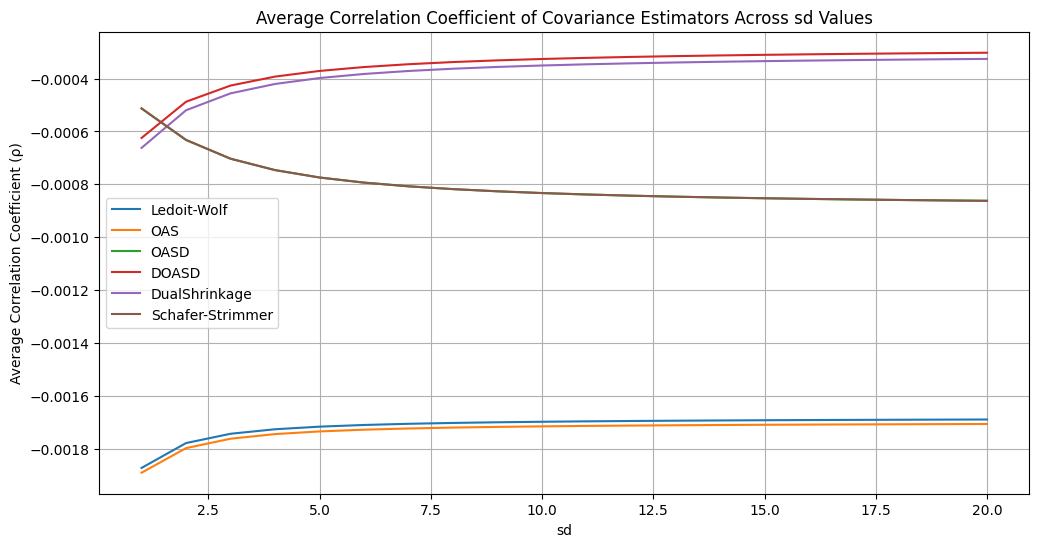

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.covariance import LedoitWolf, OAS, ShrunkCovariance

# Function to create a dataset with varying diagonal elements
def make_data_with_variance(n_samples=100, n_features=100, sd=1, gamma=0.1, random_state=None):
    random_state = np.random.RandomState(random_state)
    base_X_train = random_state.normal(size=(n_samples, n_features))
    scaling_factors = np.linspace(1, sd, n_features)  # Scaling factors based on sd parameter
    diag_scaling = np.linspace(1, 10, n_features)    # Varying scaling factors for diagonal elements

    X_train = base_X_train * scaling_factors

    # Introduce sparsity in the covariance matrix
    for i in range(n_features):
        X_train[:, i] *= diag_scaling[i]  # Scale each feature differently

    return X_train

# Define the DOASD estimator class with different levels of shrinkage
class DOASD(ShrunkCovariance):
    def __init__(self, diagonal_shrinkage=0.3, off_diagonal_shrinkage=0.4):
        super().__init__()
        self.diagonal_shrinkage = diagonal_shrinkage
        self.off_diagonal_shrinkage = off_diagonal_shrinkage

    def _compute_covariance(self, X):
        emp_cov = np.cov(X, rowvar=False)
        return emp_cov

    def fit(self, X, y=None):
        emp_cov = self._compute_covariance(X)
        n_features = emp_cov.shape[0]

        # Apply shrinkage
        shrunk_diag_cov = emp_cov * (1 - self.diagonal_shrinkage) + np.diag(np.diag(emp_cov)) * self.diagonal_shrinkage
        shrunk_cov = shrunk_diag_cov * (1 - self.off_diagonal_shrinkage) + np.diag(np.diag(shrunk_diag_cov)) * self.off_diagonal_shrinkage

        self.covariance_ = shrunk_cov
        return self

# Define the DualShrinkageEstimator class
class DualShrinkageEstimator:
    def __init__(self, delta_diag=0.3, delta_off_diag=0.4):
        self.delta_diag = delta_diag
        self.delta_off_diag = delta_off_diag

    def fit(self, X):
        sample_cov = np.cov(X, rowvar=False)
        D = np.diag(np.diag(sample_cov))
        O = sample_cov - D

        diag_target = np.diag(np.var(X, axis=0))
        off_diag_target = np.zeros_like(O)

        shrunk_diag = self.delta_diag * D + (1 - self.delta_diag) * diag_target
        shrunk_off_diag = self.delta_off_diag * O + (1 - self.delta_off_diag) * off_diag_target

        self.covariance_ = shrunk_diag + shrunk_off_diag
        return self

# Define the Schäfer-Strimmer estimator class
class SchaferStrimmer(ShrunkCovariance):
    def __init__(self, shrinkage=0.4):
        super().__init__(shrinkage=shrinkage)

# Parameters
n_samples = 100  # Fixed number of samples
n_features = 500  # Number of features
sd_values = np.linspace(1, 20, 20)  # Smooth range of sd values

# Function to compute average correlation coefficient
def compute_avg_correlation(estimator, X_train):
    estimator.fit(X_train)
    cov_matrix = estimator.covariance_
    corr_matrix = np.corrcoef(cov_matrix)
    avg_correlation = np.mean(corr_matrix[np.triu_indices_from(corr_matrix, k=1)])
    return avg_correlation

# Fit covariance estimators for different sd values and compute average correlation coefficient
corr_results = {'Ledoit-Wolf': [], 'OAS': [], 'OASD': [], 'DOASD': [], 'DualShrinkage': [], 'Schafer-Strimmer': []}
for sd in sd_values:
    X_train = make_data_with_variance(n_samples, n_features, sd=sd, random_state=42)
    for estimator_name, estimator in [
        ('Ledoit-Wolf', LedoitWolf()),
        ('OAS', OAS()),
        ('OASD', ShrunkCovariance(shrinkage=0.3)),
        ('DOASD', DOASD(diagonal_shrinkage=0.3, off_diagonal_shrinkage=0.4)),
        ('DualShrinkage', DualShrinkageEstimator(delta_diag=0.3, delta_off_diag=0.4)),
        ('Schafer-Strimmer', SchaferStrimmer(shrinkage=0.3))
    ]:
        avg_corr = compute_avg_correlation(estimator, X_train)
        corr_results[estimator_name].append(avg_corr)

# Plot average correlation coefficient across sd values for each estimator
plt.figure(figsize=(12, 6))
for estimator_name, corr_values in corr_results.items():
    plt.plot(sd_values, corr_values, label=estimator_name)

plt.title('Average Correlation Coefficient of Covariance Estimators Across sd Values')
plt.xlabel('sd')
plt.ylabel('Average Correlation Coefficient (ρ)')
plt.legend()
plt.grid(True)
plt.show()


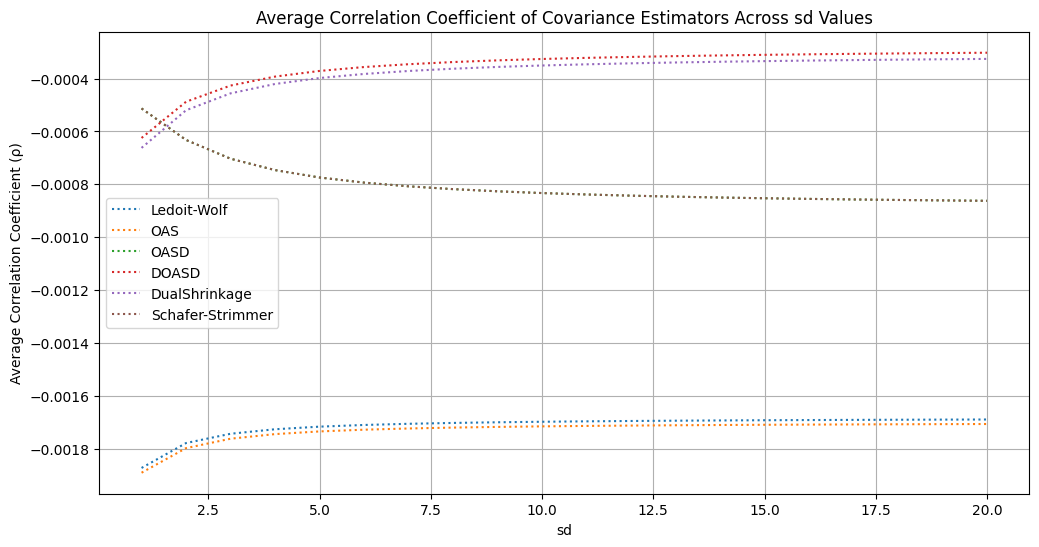

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.covariance import LedoitWolf, OAS, ShrunkCovariance

# Function to create a dataset with varying diagonal elements
def make_data_with_variance(n_samples=100, n_features=100, sd=1, gamma=0.1, random_state=None):
    random_state = np.random.RandomState(random_state)
    base_X_train = random_state.normal(size=(n_samples, n_features))
    scaling_factors = np.linspace(1, sd, n_features)  # Scaling factors based on sd parameter
    diag_scaling = np.linspace(1, 10, n_features)    # Varying scaling factors for diagonal elements

    X_train = base_X_train * scaling_factors

    # Introduce sparsity in the covariance matrix
    for i in range(n_features):
        X_train[:, i] *= diag_scaling[i]  # Scale each feature differently

    return X_train

# Define the DOASD estimator class with different levels of shrinkage
class DOASD(ShrunkCovariance):
    def __init__(self, diagonal_shrinkage=0.3, off_diagonal_shrinkage=0.4):
        super().__init__()
        self.diagonal_shrinkage = diagonal_shrinkage
        self.off_diagonal_shrinkage = off_diagonal_shrinkage

    def _compute_covariance(self, X):
        emp_cov = np.cov(X, rowvar=False)
        return emp_cov

    def fit(self, X, y=None):
        emp_cov = self._compute_covariance(X)
        n_features = emp_cov.shape[0]

        # Apply shrinkage
        shrunk_diag_cov = emp_cov * (1 - self.diagonal_shrinkage) + np.diag(np.diag(emp_cov)) * self.diagonal_shrinkage
        shrunk_cov = shrunk_diag_cov * (1 - self.off_diagonal_shrinkage) + np.diag(np.diag(shrunk_diag_cov)) * self.off_diagonal_shrinkage

        self.covariance_ = shrunk_cov
        return self

# Define the DualShrinkageEstimator class
class DualShrinkageEstimator:
    def __init__(self, delta_diag=0.3, delta_off_diag=0.4):
        self.delta_diag = delta_diag
        self.delta_off_diag = delta_off_diag

    def fit(self, X):
        sample_cov = np.cov(X, rowvar=False)
        D = np.diag(np.diag(sample_cov))
        O = sample_cov - D

        diag_target = np.diag(np.var(X, axis=0))
        off_diag_target = np.zeros_like(O)

        shrunk_diag = self.delta_diag * D + (1 - self.delta_diag) * diag_target
        shrunk_off_diag = self.delta_off_diag * O + (1 - self.delta_off_diag) * off_diag_target

        self.covariance_ = shrunk_diag + shrunk_off_diag
        return self

# Define the Schäfer-Strimmer estimator class
class SchaferStrimmer(ShrunkCovariance):
    def __init__(self, shrinkage=0.3):
        super().__init__(shrinkage=shrinkage)

# Parameters
n_samples = 100  # Fixed number of samples
n_features = 500  # Number of features
sd_values = np.linspace(1, 20, 20)  # Smooth range of sd values

# Function to compute average correlation coefficient
def compute_avg_correlation(estimator, X_train):
    estimator.fit(X_train)
    cov_matrix = estimator.covariance_
    corr_matrix = np.corrcoef(cov_matrix)
    avg_correlation = np.mean(corr_matrix[np.triu_indices_from(corr_matrix, k=1)])
    return avg_correlation

# Fit covariance estimators for different sd values and compute average correlation coefficient
corr_results = {'Ledoit-Wolf': [], 'OAS': [], 'OASD': [], 'DOASD': [], 'DualShrinkage': [], 'Schafer-Strimmer': []}
for sd in sd_values:
    X_train = make_data_with_variance(n_samples, n_features, sd=sd, random_state=42)
    for estimator_name, estimator in [
        ('Ledoit-Wolf', LedoitWolf()),
        ('OAS', OAS()),
        ('OASD', ShrunkCovariance(shrinkage=0.3)),
        ('DOASD', DOASD(diagonal_shrinkage=0.3, off_diagonal_shrinkage=0.4)),
        ('DualShrinkage', DualShrinkageEstimator(delta_diag=0.3, delta_off_diag=0.4)),
        ('Schafer-Strimmer', SchaferStrimmer(shrinkage=0.3))
    ]:
        avg_corr = compute_avg_correlation(estimator, X_train)
        corr_results[estimator_name].append(avg_corr)

# Plot average correlation coefficient across sd values for each estimator
plt.figure(figsize=(12, 6))
for estimator_name, corr_values in corr_results.items():
    plt.plot(sd_values, corr_values, label=estimator_name, linestyle='dotted')  # Set linestyle to dotted

plt.title('Average Correlation Coefficient of Covariance Estimators Across sd Values')
plt.xlabel('sd')
plt.ylabel('Average Correlation Coefficient (ρ)')
plt.legend()
plt.grid(True)
plt.show()


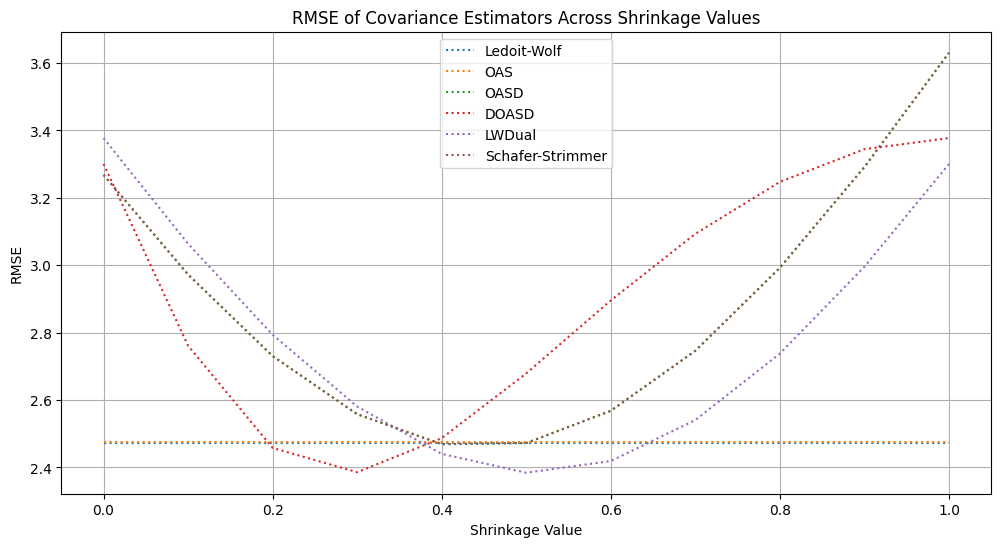

Shrinkage value where all estimators perform the same RMSE: None


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.covariance import LedoitWolf, OAS, ShrunkCovariance

# Function to create a dataset with varying diagonal elements and sparsity
def make_data_with_variance(n_samples=100, n_features=500, sd=1, sparsity=0.1, random_state=None):
    np.random.seed(random_state)
    base_X_train = np.random.normal(size=(n_samples, n_features))
    scaling_factors = np.linspace(1, sd, n_features)
    diag_scaling = np.linspace(1, 10, n_features)  # Varying scaling factors for diagonal elements

    X_train = base_X_train * scaling_factors

    # Introduce sparsity in the covariance matrix
    for i in range(n_features):
        if np.random.rand() > sparsity:
            X_train[:, i] *= diag_scaling[i]  # Scale each feature differently
        else:
            X_train[:, i] = 0  # Set some features to zero to introduce sparsity

    return X_train

# Define the DOASD estimator class
class DOASD(ShrunkCovariance):
    def __init__(self, diagonal_shrinkage=0.4, off_diagonal_shrinkage=0.3):
        super().__init__()
        self.diagonal_shrinkage = diagonal_shrinkage
        self.off_diagonal_shrinkage = off_diagonal_shrinkage

    def _compute_covariance(self, X):
        emp_cov = np.cov(X, rowvar=False)
        return emp_cov

    def fit(self, X, y=None):
        emp_cov = self._compute_covariance(X)
        n_features = emp_cov.shape[0]

        # Apply shrinkage
        shrunk_diag_cov = emp_cov * (1 - self.diagonal_shrinkage) + np.diag(np.diag(emp_cov)) * self.diagonal_shrinkage
        shrunk_cov = shrunk_diag_cov * (1 - self.off_diagonal_shrinkage) + np.diag(np.diag(shrunk_diag_cov)) * self.off_diagonal_shrinkage

        self.covariance_ = shrunk_cov
        return self

# Define the DualShrinkageEstimator class
class Dual:
    def __init__(self, delta_diag=0.4, delta_off_diag=0.3):
        self.delta_diag = delta_diag
        self.delta_off_diag = delta_off_diag

    def fit(self, X):
        sample_cov = np.cov(X, rowvar=False)
        D = np.diag(np.diag(sample_cov))
        O = sample_cov - D

        diag_target = np.diag(np.var(X, axis=0))
        off_diag_target = np.zeros_like(O)

        shrunk_diag = self.delta_diag * D + (1 - self.delta_diag) * diag_target
        shrunk_off_diag = self.delta_off_diag * O + (1 - self.delta_off_diag) * off_diag_target

        self.covariance_ = shrunk_diag + shrunk_off_diag
        return self

# Define the Schäfer-Strimmer estimator class
class SchaferStrimmer(ShrunkCovariance):
    def __init__(self, shrinkage=0.4):
        super().__init__(shrinkage=shrinkage)

# Parameters
n_samples = 100  # Number of samples
n_features = 500  # Number of features
shrinkage_values = np.linspace(0, 1, 11)  # Range of shrinkage values
random_state = 42
sparsity = 0.1  # Sparsity level

# Function to compute RMSE for a given estimator
def compute_rmse(estimator, X_train, B=500, random_state=None):
    np.random.seed(random_state)
    n_samples, n_features = X_train.shape
    true_cov = np.cov(X_train, rowvar=False)
    rmse_list = []

    for _ in range(B):
        bootstrap_sample = X_train[np.random.choice(n_samples, n_samples, replace=True), :]
        sample_cov = np.cov(bootstrap_sample, rowvar=False)
        estimator.fit(bootstrap_sample)
        estimated_cov = estimator.covariance_

        rmse = np.sqrt(np.mean((estimated_cov - true_cov) ** 2))
        rmse_list.append(rmse)

    return np.mean(rmse_list)

# Generate data
X_train = make_data_with_variance(n_samples, n_features, sd=1, sparsity=sparsity, random_state=random_state)

# Compute RMSE for different shrinkage values
rmse_results = {'Ledoit-Wolf': [], 'OAS': [], 'OASD': [], 'DOASD': [], 'LWDual': [], 'Schafer-Strimmer': []}
for shrinkage in shrinkage_values:
    for estimator_name, estimator in [
        ('Ledoit-Wolf', LedoitWolf()),  # Ledoit-Wolf does not accept a shrinkage parameter
        ('OAS', OAS()),  # OAS does not accept a shrinkage parameter
        ('OASD', ShrunkCovariance(shrinkage=shrinkage)),
        ('DOASD', DOASD(diagonal_shrinkage=shrinkage, off_diagonal_shrinkage=shrinkage)),
        ('LWDual', Dual(delta_diag=shrinkage, delta_off_diag=shrinkage)),
        ('Schafer-Strimmer', SchaferStrimmer(shrinkage=shrinkage))
    ]:
        rmse = compute_rmse(estimator, X_train, random_state=random_state)
        rmse_results[estimator_name].append(rmse)

# Plot RMSE across shrinkage values for each estimator
plt.figure(figsize=(12, 6))
for estimator_name, rmse_values in rmse_results.items():
    plt.plot(shrinkage_values, rmse_values, label=estimator_name, linestyle='dotted')

plt.title('RMSE of Covariance Estimators Across Shrinkage Values')
plt.xlabel('Shrinkage Value')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.show()

# Find the shrinkage value where all estimators have the same RMSE
tolerance = 0.01  # Define a small tolerance for equality
intersection_shrinkage = None

for i, shrinkage in enumerate(shrinkage_values):
    rmses = [rmse_results[estimator][i] for estimator in rmse_results]
    if max(rmses) - min(rmses) < tolerance:
        intersection_shrinkage = shrinkage
        break

print("Shrinkage value where all estimators perform the same RMSE:", intersection_shrinkage)


First Eigenvalue Deviation of Covariance Estimators Across Sample Sizes
Sample Size    Ledoit-Wolf         OAS                 OASD                DOASD               LWDual              Schafer-Strimmer    
50             35910.6261          36697.4341          18083.0192          21841.9827          26262.7607          18083.0192          
100            21296.9469          21561.1664          11816.2835          13497.4854          16085.1364          11816.2835          
150            15102.4488          15236.9849          9547.9279           10298.7145          12228.2775          9547.9279           
200            11594.2535          11660.6570          8103.6541           8012.8743           9494.1896           8103.6541           
250            9854.8541           9903.7826           7367.0957           6822.9291           8052.9370           7367.0957           
300            8364.7933           8396.3324           7127.9997           6417.2565           7596.2443        

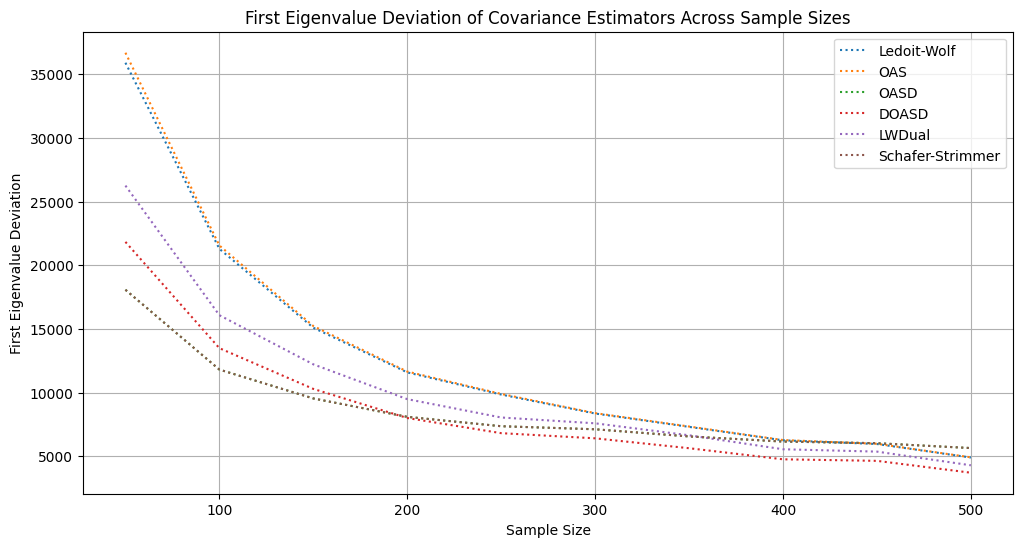

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.covariance import LedoitWolf, OAS, ShrunkCovariance

# Function to create a high-dimensional dataset with varying diagonal elements and sparsity
def make_high_dimensional_data(n_samples=100, n_features=300, sd=1, sparsity=0.1, random_state=None):
    np.random.seed(random_state)
    base_X_train = np.random.normal(size=(n_samples, n_features))
    scaling_factors = np.linspace(1, sd, n_features)
    diag_scaling = np.linspace(1, 10, n_features)  # Varying scaling factors for diagonal elements

    X_train = base_X_train * scaling_factors

    # Introduce sparsity in the covariance matrix
    for i in range(n_features):
        if np.random.rand() > sparsity:
            X_train[:, i] *= diag_scaling[i]  # Scale each feature differently
        else:
            X_train[:, i] = 0  # Set some features to zero to introduce sparsity

    return X_train

# Define the DOASD estimator class with different levels of shrinkage
class DOASD(ShrunkCovariance):
    def __init__(self, diagonal_shrinkage=0.4, off_diagonal_shrinkage=0.3):
        super().__init__()
        self.diagonal_shrinkage = diagonal_shrinkage
        self.off_diagonal_shrinkage = off_diagonal_shrinkage

    def _compute_covariance(self, X):
        emp_cov = np.cov(X, rowvar=False)
        return emp_cov

    def fit(self, X, y=None):
        emp_cov = self._compute_covariance(X)
        n_features = emp_cov.shape[0]

        # Apply shrinkage
        shrunk_diag_cov = emp_cov * (1 - self.diagonal_shrinkage) + np.diag(np.diag(emp_cov)) * self.diagonal_shrinkage
        shrunk_cov = shrunk_diag_cov * (1 - self.off_diagonal_shrinkage) + np.diag(np.diag(shrunk_diag_cov)) * self.off_diagonal_shrinkage

        self.covariance_ = shrunk_cov
        return self

# Define the DualShrinkageEstimator class
class DualShrinkageEstimator:
    def __init__(self, delta_diag=0.4, delta_off_diag=0.3):
        self.delta_diag = delta_diag
        self.delta_off_diag = delta_off_diag

    def fit(self, X):
        sample_cov = np.cov(X, rowvar=False)
        D = np.diag(np.diag(sample_cov))
        O = sample_cov - D

        diag_target = np.diag(np.var(X, axis=0))
        off_diag_target = np.zeros_like(O)

        shrunk_diag = self.delta_diag * D + (1 - self.delta_diag) * diag_target
        shrunk_off_diag = self.delta_off_diag * O + (1 - self.delta_off_diag) * off_diag_target

        self.covariance_ = shrunk_diag + shrunk_off_diag
        return self

# Define the Schäfer-Strimmer estimator class
class SchaferStrimmer(ShrunkCovariance):
    def __init__(self, shrinkage=0.4):
        super().__init__(shrinkage=shrinkage)

# Function to compute the first eigenvalue deviation for a given estimator
def compute_first_eigenvalue_deviation(estimator, X_train):
    true_cov = np.cov(X_train, rowvar=False)
    true_eigenvalues = np.linalg.eigvalsh(true_cov)
    true_first_eigenvalue = true_eigenvalues[-1]

    estimator.fit(X_train)
    estimated_cov = estimator.covariance_
    estimated_eigenvalues = np.linalg.eigvalsh(estimated_cov)
    estimated_first_eigenvalue = estimated_eigenvalues[-1]

    deviation = np.abs(estimated_first_eigenvalue - true_first_eigenvalue)
    return deviation

# Parameters
n_features = 500  # High-dimensional data
sample_sizes = np.arange(50, 501, 50)  # Range of sample sizes
random_state = 42
sparsity = 0.1  # Sparsity level
sd = 10  # Fixed sd value

# Compute first eigenvalue deviation for different sample sizes and different estimators
eigenvalue_deviation_results = {'Ledoit-Wolf': [], 'OAS': [], 'OASD': [], 'DOASD': [], 'LWDual': [], 'Schafer-Strimmer': []}
for n_samples in sample_sizes:
    X_train = make_high_dimensional_data(n_samples, n_features, sd=sd, sparsity=sparsity, random_state=random_state)
    for estimator_name, estimator in [
        ('Ledoit-Wolf', LedoitWolf()),
        ('OAS', OAS()),
        ('OASD', ShrunkCovariance(shrinkage=0.4)),
        ('DOASD', DOASD(diagonal_shrinkage=0.4, off_diagonal_shrinkage=0.3)),
        ('LWDual', DualShrinkageEstimator(delta_diag=0.4, delta_off_diag=0.3)),
        ('Schafer-Strimmer', SchaferStrimmer(shrinkage=0.4))
    ]:
        deviation = compute_first_eigenvalue_deviation(estimator, X_train)
        eigenvalue_deviation_results[estimator_name].append(deviation)

# Print first eigenvalue deviation results in a tabular format
print("First Eigenvalue Deviation of Covariance Estimators Across Sample Sizes")
print(f"{'Sample Size':<15}" + "".join([f"{name:<20}" for name in eigenvalue_deviation_results.keys()]))

for i, n_samples in enumerate(sample_sizes):
    print(f"{n_samples:<15}" + "".join([f"{eigenvalue_deviation_results[name][i]:<20.4f}" for name in eigenvalue_deviation_results.keys()]))

# Plot first eigenvalue deviation across sample sizes for each estimator
plt.figure(figsize=(12, 6))
for estimator_name, deviation_values in eigenvalue_deviation_results.items():
    plt.plot(sample_sizes, deviation_values, label=estimator_name, linestyle='dotted')

plt.title('First Eigenvalue Deviation of Covariance Estimators Across Sample Sizes')
plt.xlabel('Sample Size')
plt.ylabel('First Eigenvalue Deviation')
plt.legend()
plt.grid(True)
plt.show()
